In [ ]:
###
#@title Install and RESTART the runtime
###

!pip install --upgrade -q sdv ipython-autotime git+https://github.com/tensorflow/docs #-q typing-extensions sdv ipython-autotime tensorflow numba git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
%load_ext autotime

time: 247 µs (started: 2025-10-01 16:48:19 +00:00)


In [ ]:
#@title Imports y funciones utilitarias
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import random as rn
import seaborn as sns

from imblearn.over_sampling import SMOTE
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
from scipy.io import arff
from sdv.constraints import ScalarRange
from sdv.metadata import SingleTableMetadata
from sdv.sampling import Condition
from sdv.single_table import CTGANSynthesizer
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from urllib.request import urlretrieve


def reproducibilidad(rseed = 1211):
  np.random.seed(rseed)
  np.random.default_rng(rseed)
  np.random.RandomState(rseed)
  rn.seed(rseed)

reproducibilidad()

#---------Formatos de colores y tamaños
sns.set()
#sns.set_context('poster') #Everything is larger
#sns.set_context('paper')  #Everything is smaller
#sns.set_context('talk')   #Everything is sized for a presentation
sns.set_style('whitegrid')
#sns.set_palette(sns.color_palette(['blue', 'red', 'cyan', 'gray', 'pink', 'lime']))
#---------

def download(url, file):
  if not os.path.isfile(file):# si no existe el archivo, descárgalo
    print("Download file... " + file + " ...")
    urlretrieve(url,file)
    print("File downloaded")

def isOk(df):
  print('Has null/nan values? ' + str(df.isnull().values.any()))
  print('Index has duplicates? ' + str(df.index.has_duplicates))
  print()
  print('Columns and data types:')
  print(df.dtypes)
  print()
  if df.isnull().values.any():
    print('Null/nan values:')
    print(df[df.isnull().any(axis=1)])
  if df.index.has_duplicates:
    print('Duplicated values:')
    print(df.index[df.index.duplicated()])

def escalar(datos, tecnica=1):
#https://scikit-learn.org/stable/modules/preprocessing.html
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
  reproducibilidad()
  x_scaled = None
  if tecnica == 1:
    #('Data after MinMax scaling',
    x_scaled = MinMaxScaler().fit_transform(datos)
  elif tecnica == 2:
    #('Data after robust scaling',
    x_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(datos)
  elif tecnica == 3:
    #('Data after power transformation (Yeo-Johnson)',
    x_scaled = PowerTransformer(method='yeo-johnson').fit_transform(datos)
  elif tecnica == 4:
    #('Data after quantile transformation (gaussian pdf)',
    x_scaled = QuantileTransformer(output_distribution='normal').fit_transform(datos)
  elif tecnica == 5:
    #('Data after quantile transformation (uniform pdf)',
    x_scaled = QuantileTransformer(output_distribution='uniform').fit_transform(datos)
  elif tecnica == 6:
    #('Data after sample-wise L2 normalizing',
    x_scaled = Normalizer().fit_transform(datos)
  return x_scaled

def valCruzada(name, X, y, nof_folds=10):
  #The mean score and the 95% confidence interval of the score estimate are returned
  reproducibilidad()

  hidden_layer_sizes = int((X.shape[1] + len(np.unique(y))) / 2)
  mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='tanh', solver='lbfgs',
                    batch_size='auto', learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
                    random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

  # cross-validate knn on our training sample with nof_folds
  cv_generator = StratifiedKFold(n_splits=nof_folds, shuffle=False)
  #Return a dict of arrays containing test_score, train_score, fit_time, score_time, estimator
  scores = cross_validate(mlp, X, y, scoring=['accuracy'], cv=cv_generator, n_jobs=-1, return_estimator=True)

  print('{}\tacc={:.4f}% (+/- {:.4f})'.format(name, scores['test_accuracy'].mean()*100, scores['test_accuracy'].std() * 2))


  #------------- confusion matrix
  labels = np.unique(y)
  reproducibilidad()
  matrix_avg = np.zeros((np.unique(y).size, np.unique(y).size))
  for i, (train_index, test_index) in enumerate(cv_generator.split(X, y)):
    # scores['estimator'][i].fit(X[train_index], y[train_index])
    y_pred = scores['estimator'][i].predict(X[test_index])
    matrix = confusion_matrix(y[test_index], y_pred)
    np.add(matrix_avg, matrix, out=matrix_avg)
    # print()
    # print(matrix)
    # print()
    if not os.path.exists('img/confusion_matrix/'):
      os.makedirs('img/confusion_matrix/', exist_ok=True)
    sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap="Blues", fmt="g")
    #for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(' '.join([name, ' Confusion Matrix']))
    plt.savefig(''.join(['img/confusion_matrix/', name, '_confusion_matrix_', str(i)]), bbox_inches='tight')
    plt.show()
    plt.close()
  #------------- confusion matrix

  # plt.figure(figsize=(12.8,6))
  sns.heatmap(matrix_avg, annot=True, xticklabels=labels, yticklabels=labels, cmap="Blues", fmt="g")
  #for t in ax.texts: t.set_text(t.get_text() + " %")
  plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(' '.join([name, ' Confusion Matrix']))
  plt.savefig(''.join(['img/confusion_matrix/', name, '_confusion_matrix_AVG']), bbox_inches='tight')
  plt.show()
  plt.close()
  print()
  print()

  #95% confianza = margin of error https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule
  #std_conf = scores.std() * 2

  return scores#['test_accuracy']#mean_score, std_conf

def fit_predict(clf, X_train, Y_train, X_test, Y_test):
  reproducibilidad()
  # train the model
  clf.fit(X_train, Y_train.reshape(-1))
  # predict labels for test samples
  Y_pred = clf.predict(X_test)
  print('Accuracy: {:.2f} %\n\nConfussion matrix'.format(accuracy_score(Y_test, Y_pred)*100))
  print(confusion_matrix(Y_test, Y_pred))
  return Y_pred

def loadFile(url, name):
  download(url,name)

  df = pd.DataFrame(arff.loadarff(name)[0])
  df['CLASS'] = list(map(int, df['CLASS'].str.decode("utf-8")))
  print("File loaded")
  return df

time: 12.3 s (started: 2025-10-01 16:48:26 +00:00)


In [ ]:
#@title Leer archivo PIMA

df_pima = loadFile('https://raw.githubusercontent.com/elMaxPain/files/master/SMOTE_v_GAN/pima_indians_diabetes.arff', 'pima_indians_diabetes.arff')

#previsualizar
print(df_pima.head())
print('=====================')
print(df_pima.info())
print('=====================')
print(isOk(df_pima))
print('=====================')
df_pima.describe()

Download file... pima_indians_diabetes.arff ...
File downloaded
File loaded
   times_pregnant  plasma_glucose  diastolic  skin_thickness  serum_insulin  \
0             6.0           148.0       72.0            35.0            0.0   
1             1.0            85.0       66.0            29.0            0.0   
2             8.0           183.0       64.0             0.0            0.0   
3             1.0            89.0       66.0            23.0           94.0   
4             0.0           137.0       40.0            35.0          168.0   

    bmi  diabetes_pedigree   age  CLASS  
0  33.6              0.627  50.0      1  
1  26.6              0.351  31.0      0  
2  23.3              0.672  32.0      1  
3  28.1              0.167  21.0      0  
4  43.1              2.288  33.0      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----

times_pregnant  plasma_glucose   diastolic  skin_thickness  \
count      768.000000      768.000000  768.000000      768.000000   
mean         3.845052      120.894531   69.105469       20.536458   
std          3.369578       31.972618   19.355807       15.952218   
min          0.000000        0.000000    0.000000        0.000000   
25%          1.000000       99.000000   62.000000        0.000000   
50%          3.000000      117.000000   72.000000       23.000000   
75%          6.000000      140.250000   80.000000       32.000000   
max         17.000000      199.000000  122.000000       99.000000   

       serum_insulin         bmi  diabetes_pedigree         age       CLASS  
count     768.000000  768.000000         768.000000  768.000000  768.000000  
mean       79.799479   31.992578           0.471876   33.240885    0.348958  
std       115.244002    7.884160           0.331329   11.760232    0.476951  
min         0.000000    0.000000           0.078000   21.000000    0.000000  
25%         0.000000   27.300000           0.243750   24.000000    0.000000  
50%        30.500000   32.000000           0.372500   29.000000    0.000000  
75%       127.250000   36.600000           0.626250   41.000000    1.000000  
max       846.000000   67.100000           2.420000   81.000000    1.000000

time: 192 ms (started: 2025-10-01 16:54:52 +00:00)


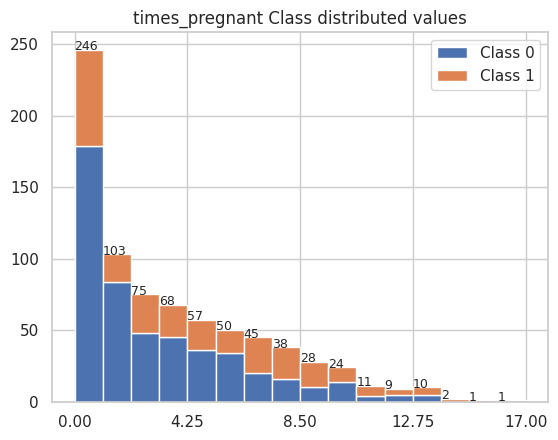

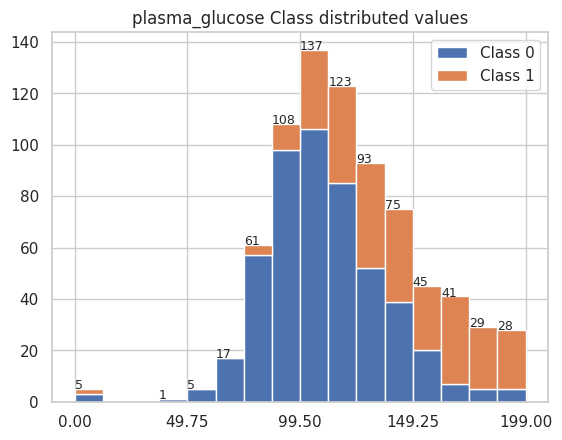

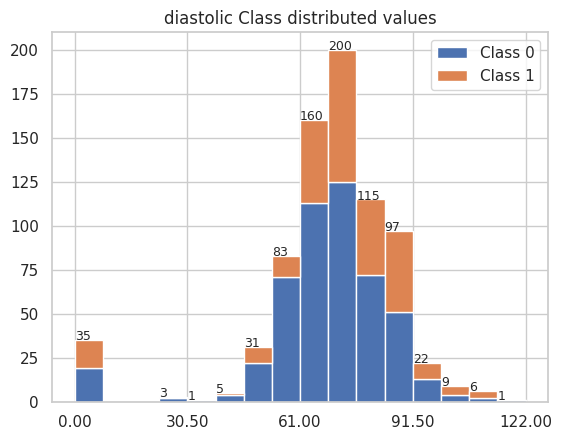

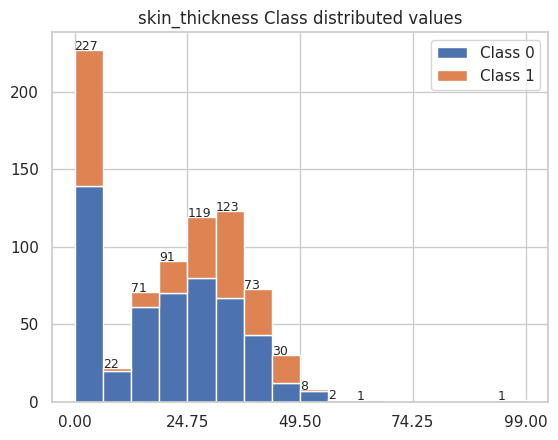

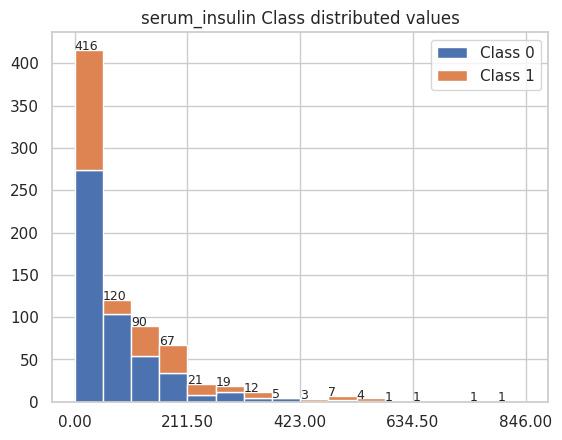

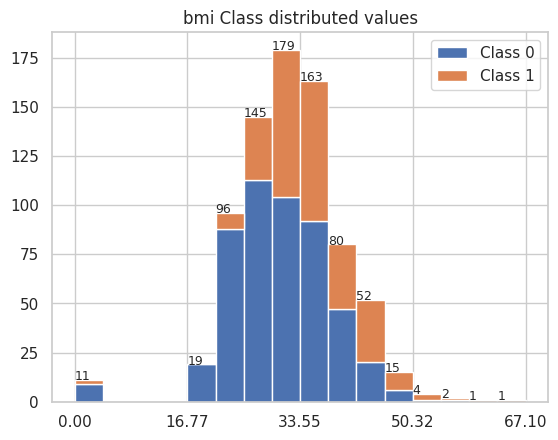

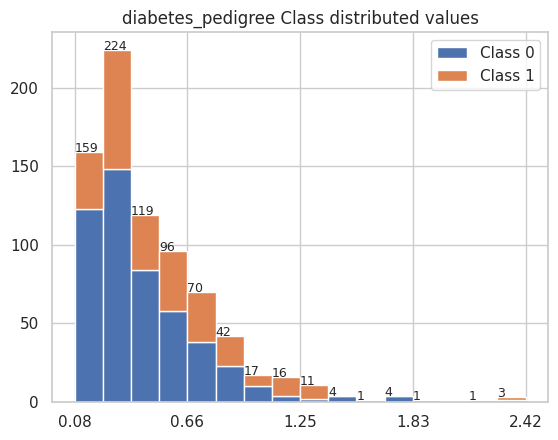

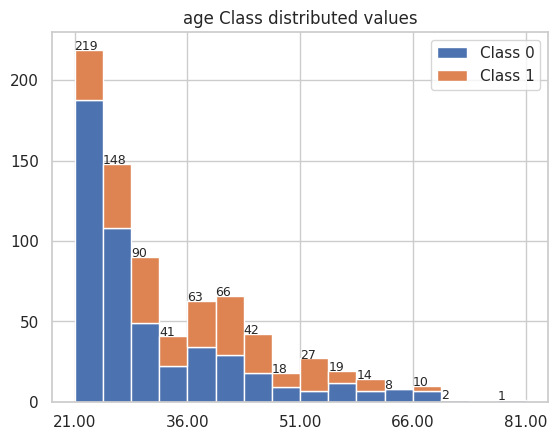

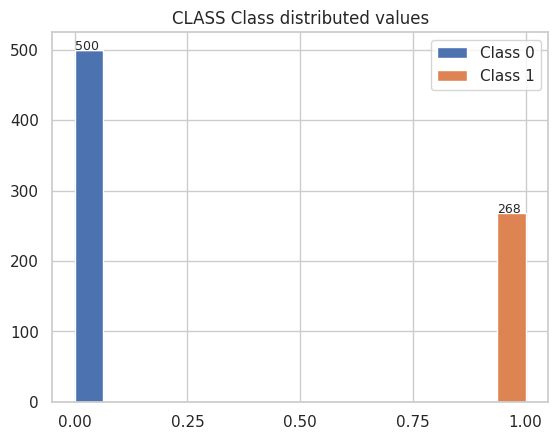

time: 3.7 s (started: 2025-10-01 16:54:56 +00:00)


In [ ]:
#@title Original PIMA - Class distributed values

interesantes = df_pima.columns.values
for i in interesantes:
  plt.figure(facecolor='w')
  min_df = df_pima[i].min()
  max_df = df_pima[i].max()
  n, bins, _ = plt.hist([df_pima[df_pima['CLASS']==0][i], df_pima[df_pima['CLASS']==1][i]],
          bins = 16, stacked=True, label=['Class 0', 'Class 1'])
  for j in range(len(bins)-1):
    if n[-1][j]:
      plt.text(bins[j], n[-1][j], str(int(n[-1][j])), fontsize=9)
  plt.xticks(np.linspace(min_df, max_df, num=5))
  plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title(f'{i} Class distributed values')
  plt.legend()
  if not os.path.exists('img/original/'):
    os.makedirs('img/original/', exist_ok=True)
  plt.savefig(''.join(['img/original/PIMA_' ,i , '_class_distribution', '.png']), bbox_inches='tight')
  plt.show()
  plt.close()

del interesantes, min_df, max_df, n, bins, i, j

# --- First set of experiments

MLP_Original	acc=65.1111% (+/- 0.0338)


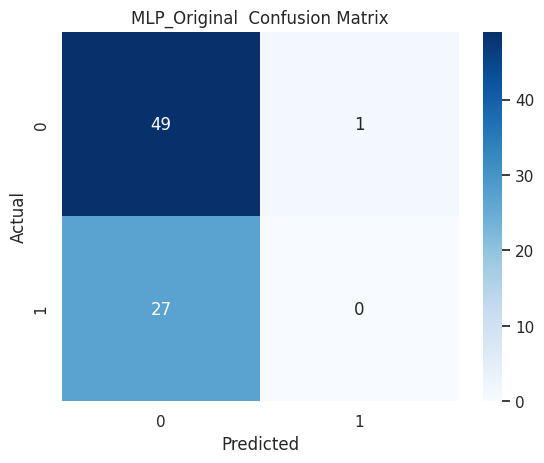

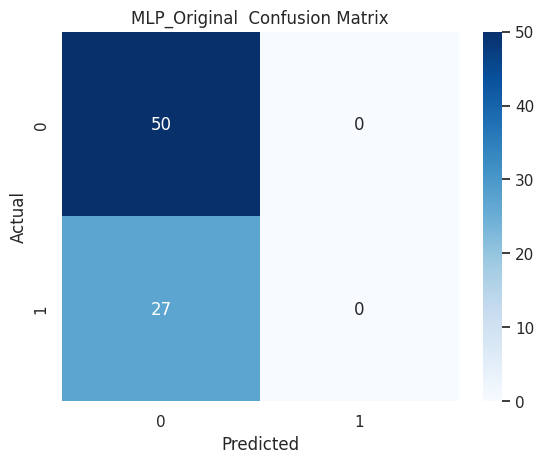

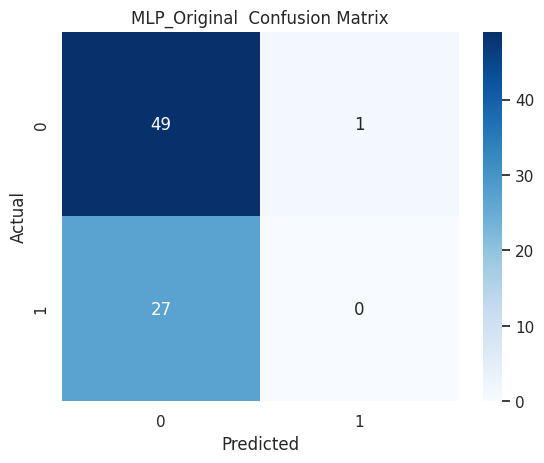

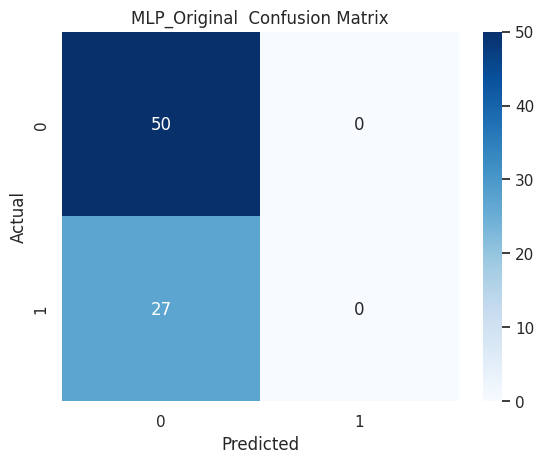

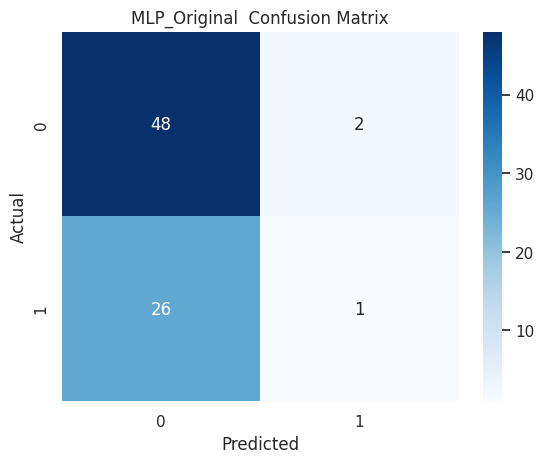

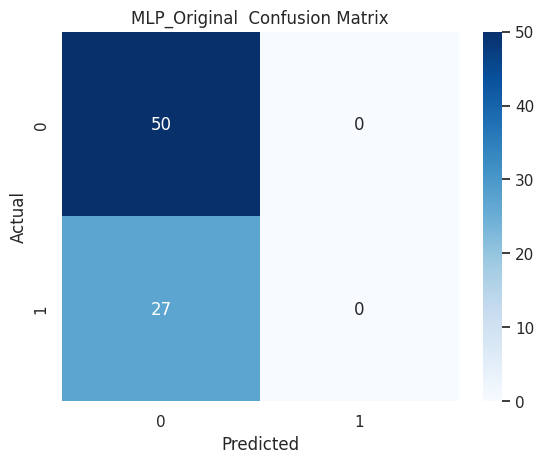

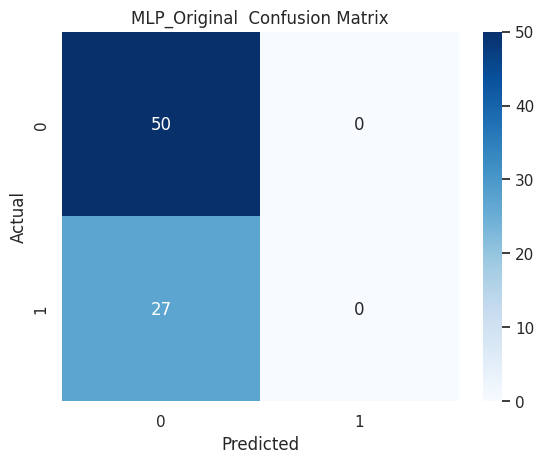

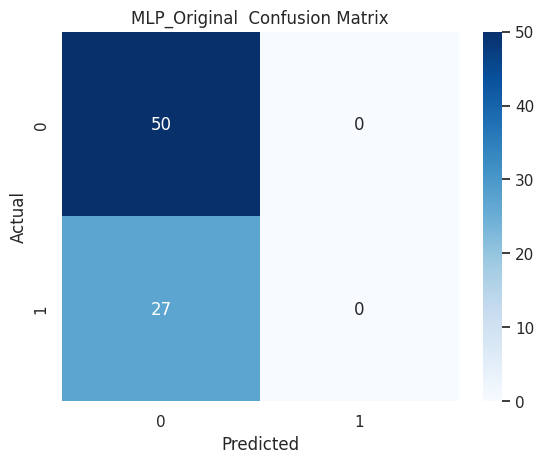

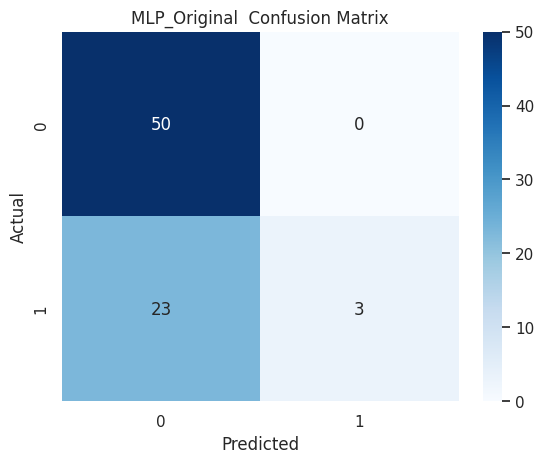

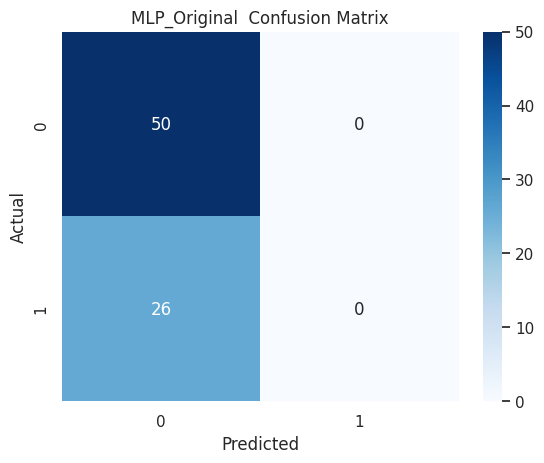

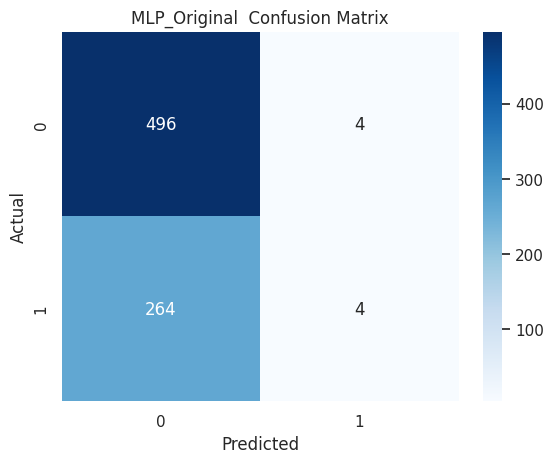



[0.63636364 0.64935065 0.63636364 0.64935065 0.63636364 0.64935065
 0.64935065 0.64935065 0.69736842 0.65789474]

{'fit_time': array([0.62410235, 0.71513128, 1.54360628, 0.5955658 , 1.05038285,
       0.33590698, 0.28877378, 0.29883409, 0.8352766 , 0.27614403]), 'score_time': array([0.00293446, 0.00392771, 0.0022738 , 0.00391507, 0.00198388,
       0.00398397, 0.00181794, 0.00379515, 0.00203538, 0.00381303]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adapti

In [ ]:
#@title MLP on ORIGINAL dataset

reproducibilidad()

pima = valCruzada('MLP_Original', df_pima.drop('CLASS', axis=1).values, df_pima['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

In [ ]:
#@title Convertir 0s a NaNs

df_pima_i = df_pima.copy(True)

df_pima_i['plasma_glucose'].replace(to_replace = 0, value = np.nan, inplace=True)
df_pima_i['diastolic'].replace(to_replace = 0, value = np.nan, inplace=True)
df_pima_i['skin_thickness'].replace(to_replace = 0, value = np.nan, inplace=True)
df_pima_i['serum_insulin'].replace(to_replace = 0, value = np.nan, inplace=True)
df_pima_i['bmi'].replace(to_replace = 0, value = np.nan, inplace=True)

count = df_pima_i.isnull().values.sum()
print("It contains " + str(count) + " null values")
count = np.isnan(df_pima_i).values.sum()
print("It contains " + str(count) + " NaN values")
count = np.isinf(df_pima_i).values.sum()
print("It contains " + str(count) + " infinite values")

It contains 652 null values
It contains 652 NaN values
It contains 0 infinite values
time: 18.4 ms (started: 2025-10-01 18:41:28 +00:00)


/tmp/ipython-input-1472162093.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pima_i['plasma_glucose'].replace(to_replace = 0, value = np.nan, inplace=True)
/tmp/ipython-input-1472162093.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

In [ ]:
#@title Imputar valores nulos
imputer = KNNImputer(n_neighbors=3)
df_pima_i = imputer.fit_transform(df_pima_i)

df_pima_i = pd.DataFrame(df_pima_i, columns = df_pima.columns.values)

count = df_pima_i.isnull().values.sum()
print("It contains " + str(count) + " null values")
count = np.isnan(df_pima_i).values.sum()
print("It contains " + str(count) + " NaN values")
count = np.isinf(df_pima_i).values.sum()
print("It contains " + str(count) + " infinite values")

#previsualizar
print(df_pima_i.head())
print('=====================')
print(df_pima_i.info())
print('=====================')
print(isOk(df_pima_i))
print('=====================')
df_pima_i.describe()

It contains 0 null values
It contains 0 NaN values
It contains 0 infinite values
   times_pregnant  plasma_glucose  diastolic  skin_thickness  serum_insulin  \
0             6.0           148.0       72.0            35.0     125.333333   
1             1.0            85.0       66.0            29.0      66.666667   
2             8.0           183.0       64.0            30.0     195.000000   
3             1.0            89.0       66.0            23.0      94.000000   
4             0.0           137.0       40.0            35.0     168.000000   

    bmi  diabetes_pedigree   age  CLASS  
0  33.6              0.627  50.0    1.0  
1  26.6              0.351  31.0    0.0  
2  23.3              0.672  32.0    1.0  
3  28.1              0.167  21.0    0.0  
4  43.1              2.288  33.0    1.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  

times_pregnant  plasma_glucose   diastolic  skin_thickness  \
count      768.000000      768.000000  768.000000      768.000000   
mean         3.845052      121.563368   72.342448       29.099392   
std          3.369578       30.550074   12.221390        9.580304   
min          0.000000       44.000000   24.000000        7.000000   
25%          1.000000       99.000000   64.000000       22.333333   
50%          3.000000      117.000000   72.000000       29.000000   
75%          6.000000      141.000000   80.000000       35.000000   
max         17.000000      199.000000  122.000000       99.000000   

       serum_insulin         bmi  diabetes_pedigree         age       CLASS  
count     768.000000  768.000000         768.000000  768.000000  768.000000  
mean      153.414062   32.426259           0.471876   33.240885    0.348958  
std       100.846193    6.889295           0.331329   11.760232    0.476951  
min        14.000000   18.200000           0.078000   21.000000    0.000000  
25%        83.000000   27.500000           0.243750   24.000000    0.000000  
50%       132.000000   32.150000           0.372500   29.000000    0.000000  
75%       191.000000   36.600000           0.626250   41.000000    1.000000  
max       846.000000   67.100000           2.420000   81.000000    1.000000

time: 236 ms (started: 2025-10-01 18:41:28 +00:00)


MLP_Original_imputed	acc=65.1059% (+/- 0.0068)


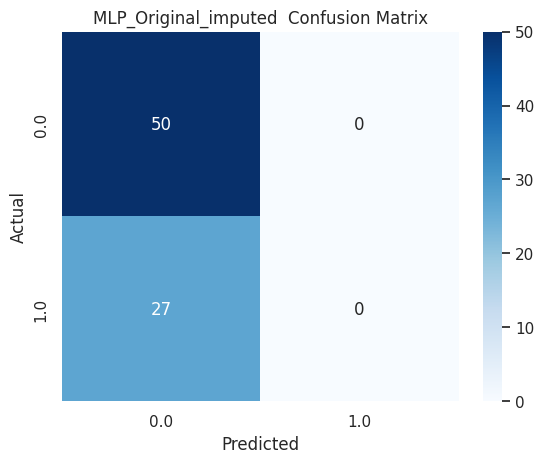

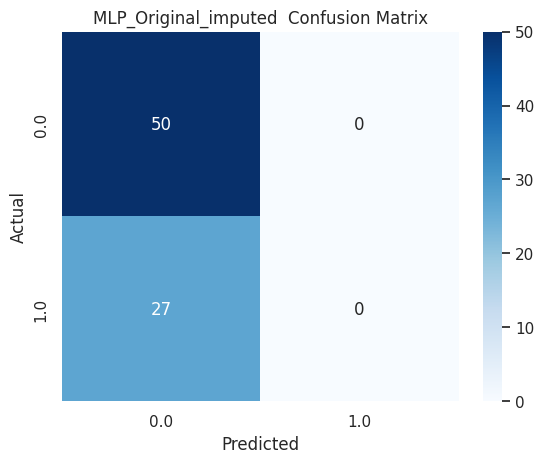

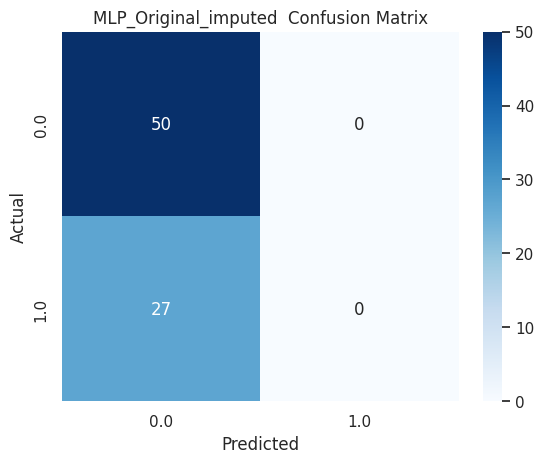

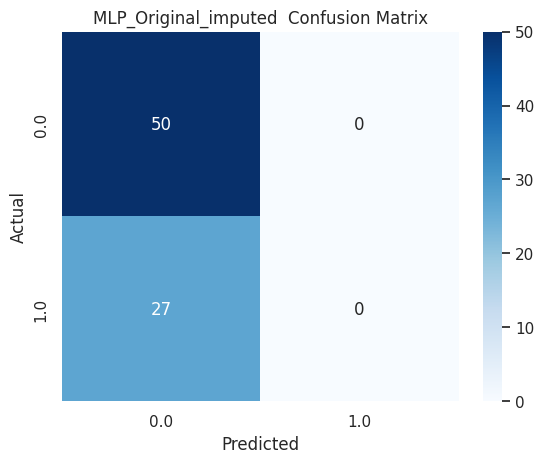

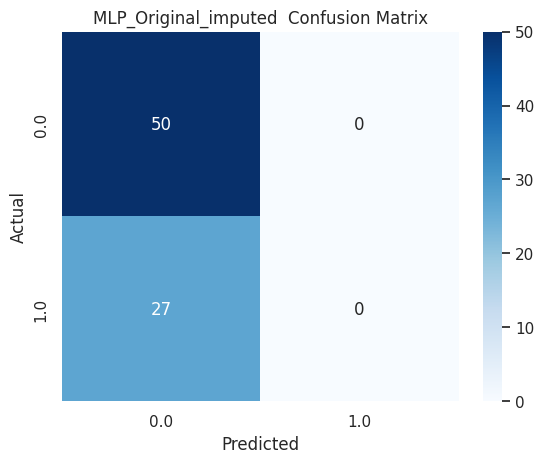

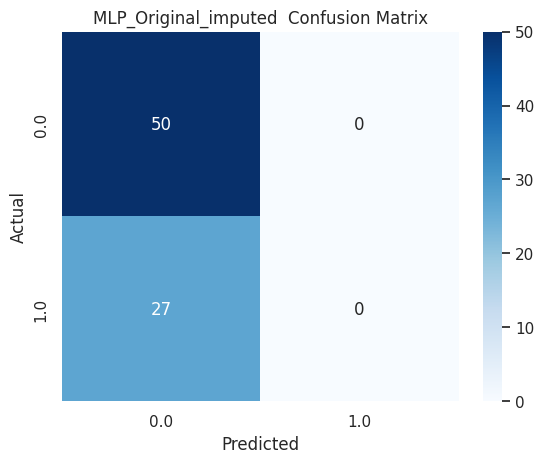

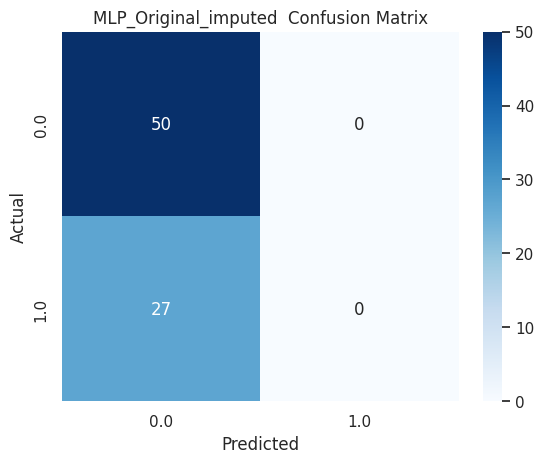

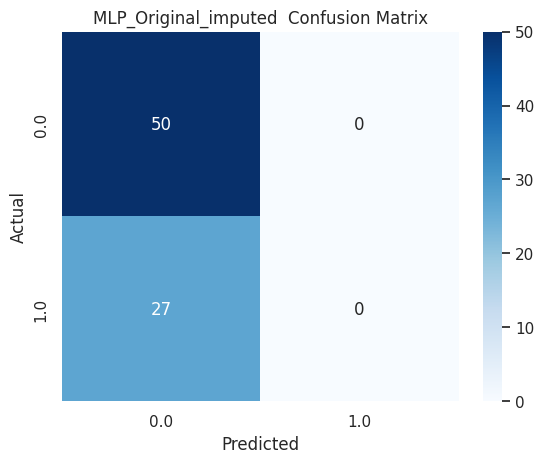

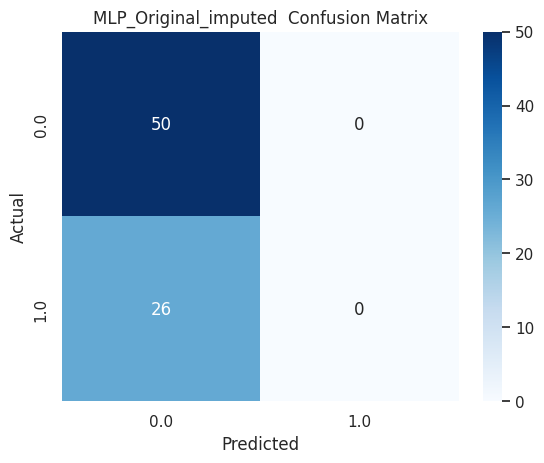

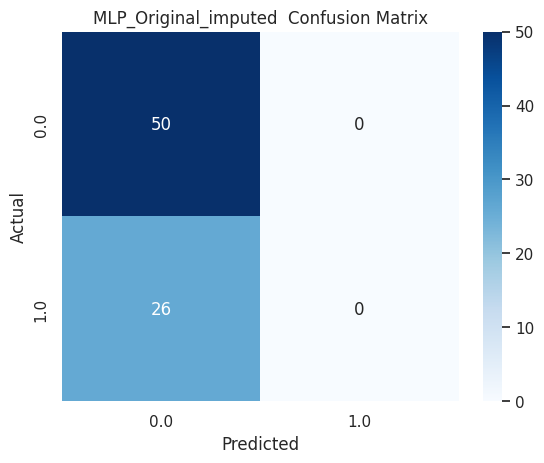

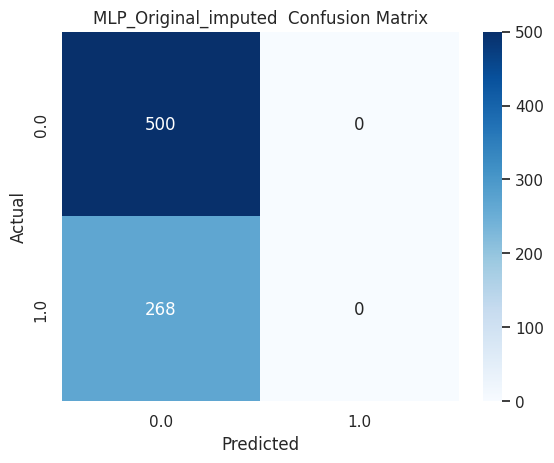



[0.64935065 0.64935065 0.64935065 0.64935065 0.64935065 0.64935065
 0.64935065 0.64935065 0.65789474 0.65789474]

{'fit_time': array([0.0201962 , 0.02082586, 0.02466798, 0.0215745 , 0.02839804,
       0.02083731, 0.02236581, 0.01824045, 0.02923369, 0.02932954]), 'score_time': array([0.00387907, 0.00368881, 0.00388002, 0.00385737, 0.00297117,
       0.00497246, 0.00381684, 0.00393629, 0.00395942, 0.00418425]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adapti

In [ ]:
#@title MLP on ORIGINAL dataset + imputed values

reproducibilidad()

pima = valCruzada('MLP_Original_imputed', df_pima_i.drop('CLASS', axis=1).values, df_pima_i['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

MLP_Original_imputed_norm	acc=74.7471% (+/- 0.0718)


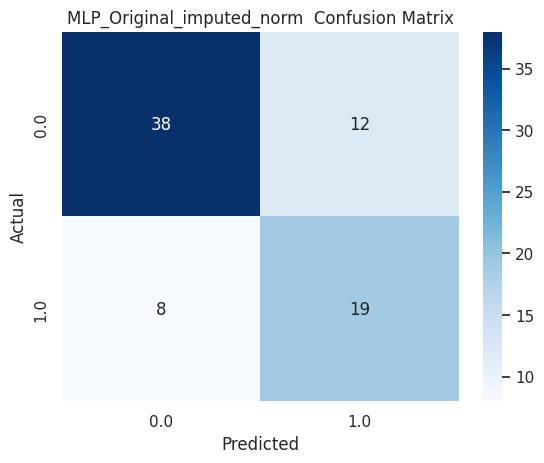

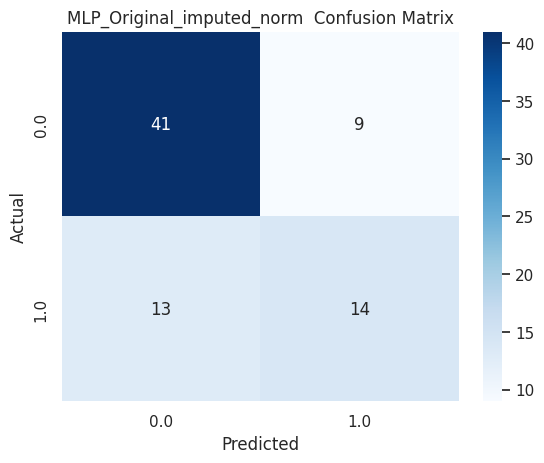

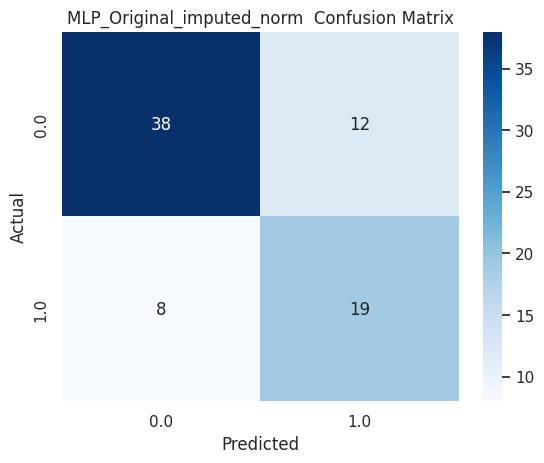

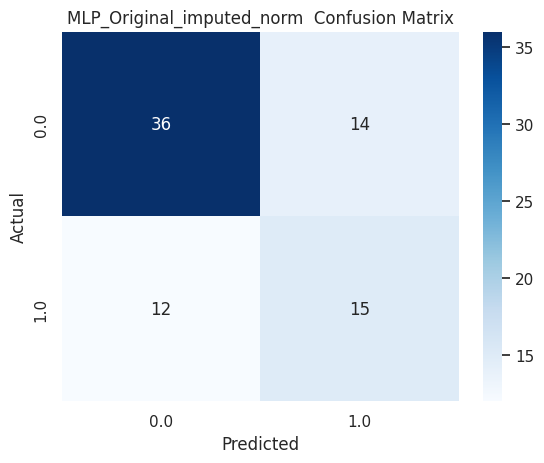

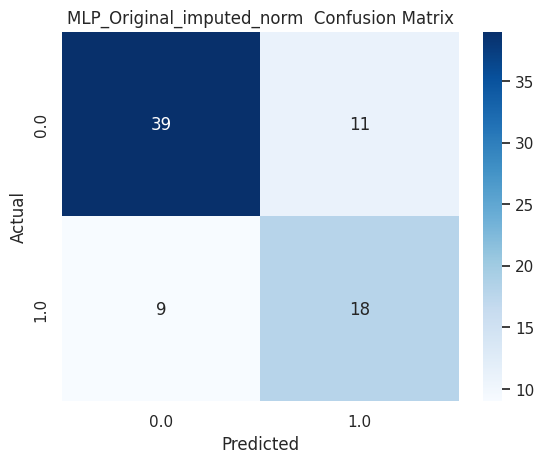

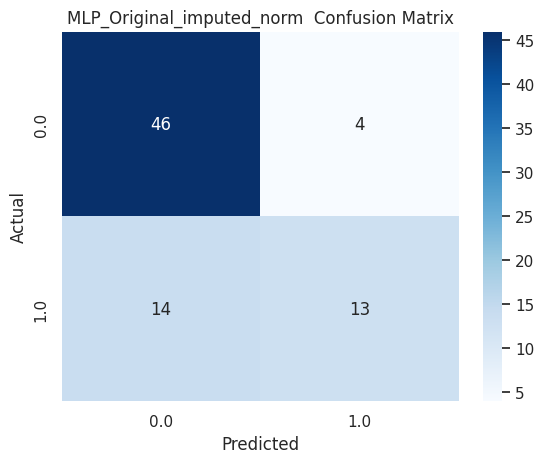

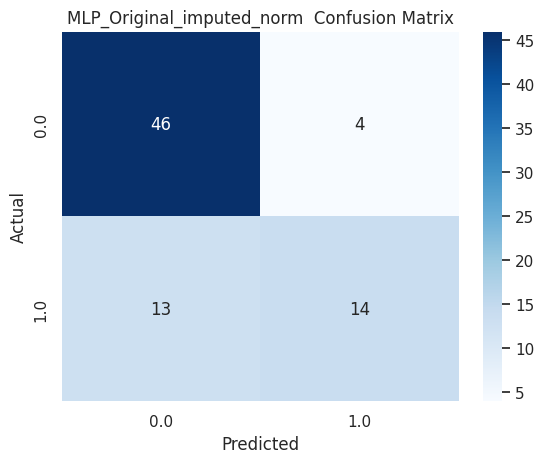

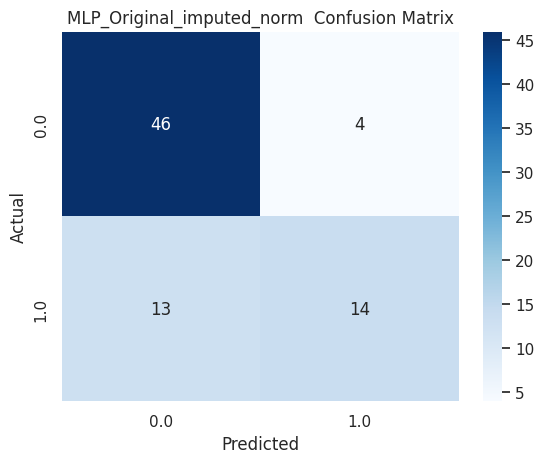

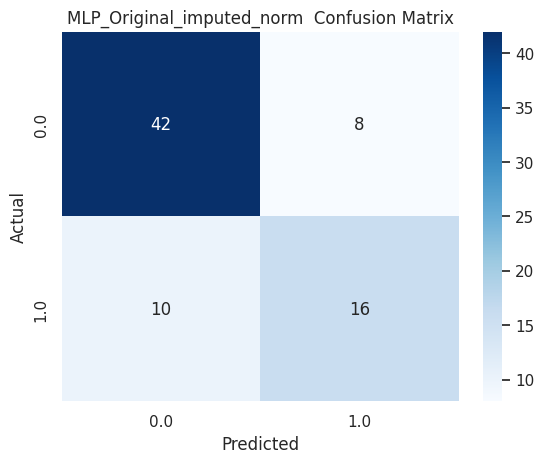

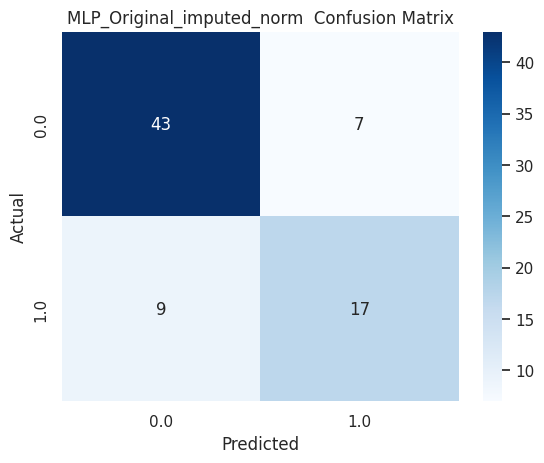

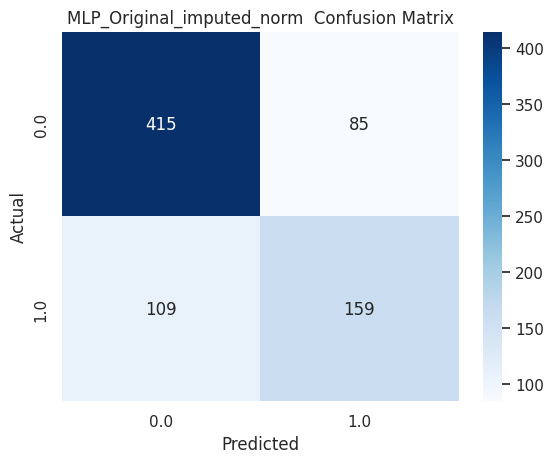



[0.74025974 0.71428571 0.74025974 0.66233766 0.74025974 0.76623377
 0.77922078 0.77922078 0.76315789 0.78947368]

{'fit_time': array([0.79495978, 0.73818398, 0.7744    , 0.84710908, 1.03345942,
       0.8355341 , 0.74093652, 0.72509432, 0.58884072, 0.74905586]), 'score_time': array([0.00195336, 0.00178289, 0.00417256, 0.0025146 , 0.00426888,
       0.00377798, 0.00164938, 0.00245023, 0.0022459 , 0.00179458]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adapti

In [ ]:
#@title MLP on ORIGINAL dataset + imputed + norm values
#from sklearn.metrics import zero_one_loss
reproducibilidad()

df_pima_i_n = pd.DataFrame(escalar(df_pima_i.drop('CLASS', axis=1).values, 1), columns=df_pima_i.columns[:-1]).copy(True)
df_pima_i_n.index = df_pima_i.index
df_pima_i_n['CLASS'] = df_pima_i['CLASS']

reproducibilidad()

pima = valCruzada('MLP_Original_imputed_norm', df_pima_i_n.drop('CLASS', axis=1).values, df_pima_i_n['CLASS'].values)#, 'Original')
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

In [ ]:
#@title Limpiar variables

del count, imputer

time: 598 µs (started: 2025-10-01 04:28:54 +00:00)


# --- Second set of experiments

In [ ]:
#@title Aplicar SMOTE a los Originales

reproducibilidad()

#from imblearn.over_sampling import BorderlineSMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline
oversample = SMOTE(sampling_strategy='auto', random_state=np.random.get_state()[1][0], k_neighbors=3)#, n_jobs=-1)
X, y = oversample.fit_resample(df_pima.drop('CLASS', axis=1), df_pima.CLASS)
X['CLASS'] = y
df_pima_s = X.copy(True)

# define pipeline
#over = SMOTE(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)
# transform the dataset
#X, y = pipeline.fit_resample(X, y)

print('SMOTE:')
print(df_pima_s.CLASS.value_counts())

SMOTE:
CLASS
1    500
0    500
Name: count, dtype: int64
time: 36.8 ms (started: 2025-10-01 04:28:54 +00:00)


MLP_SMOTE	acc=72.6000% (+/- 0.1529)


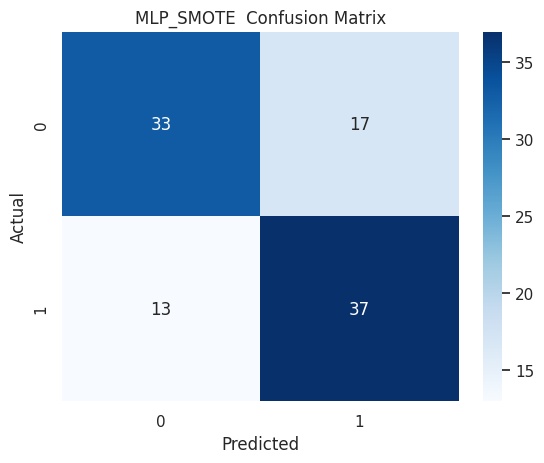

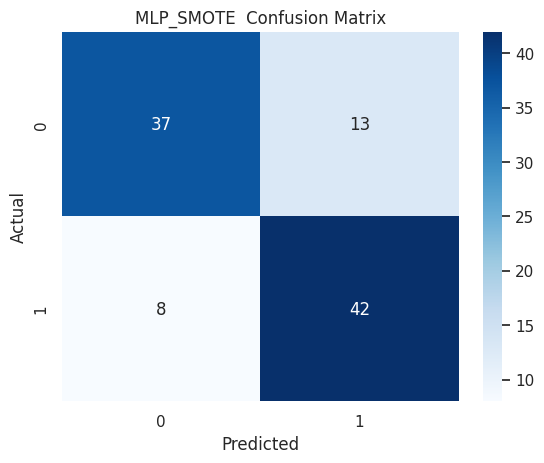

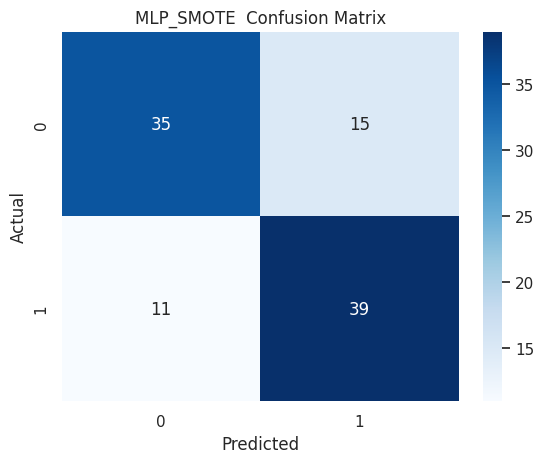

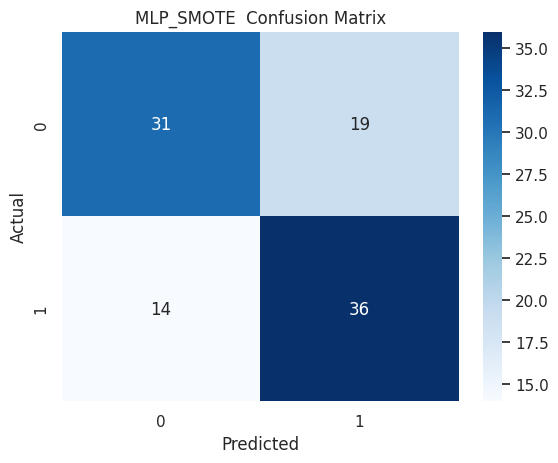

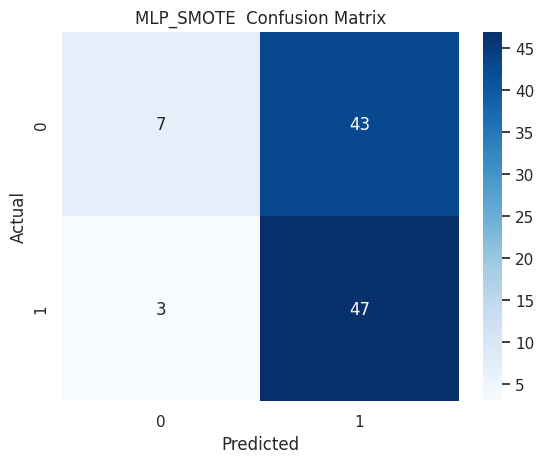

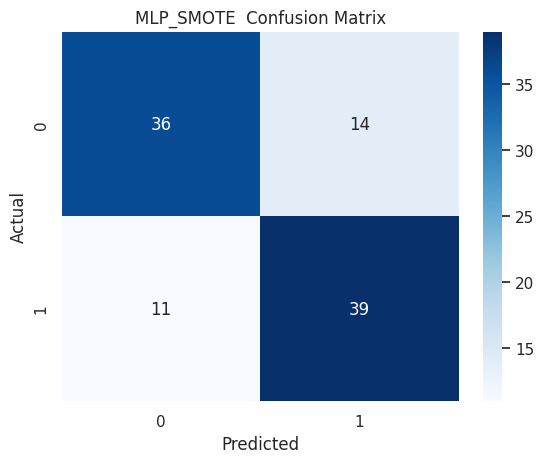

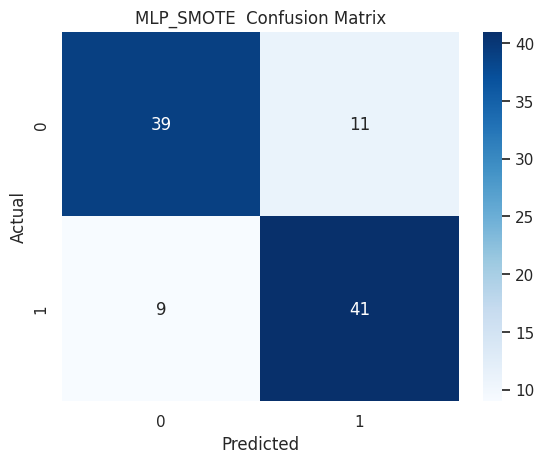

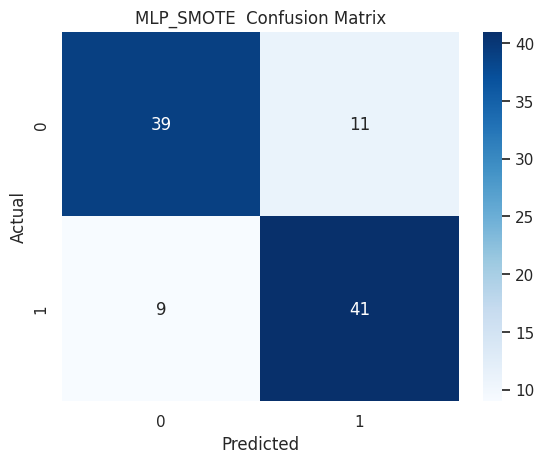

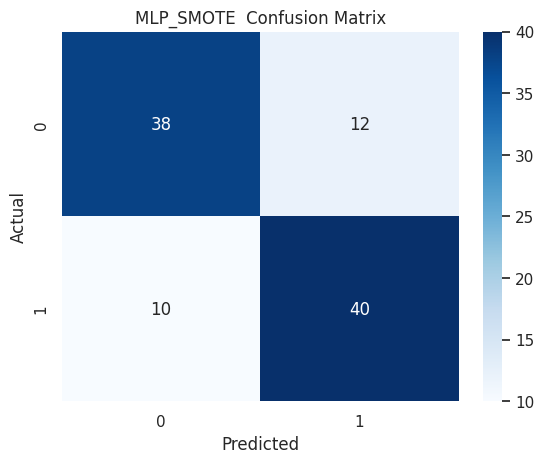

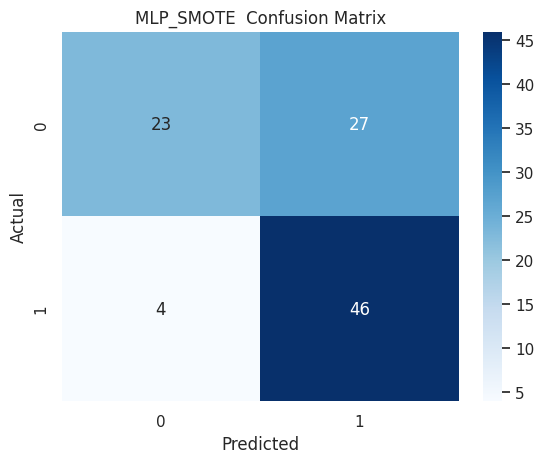

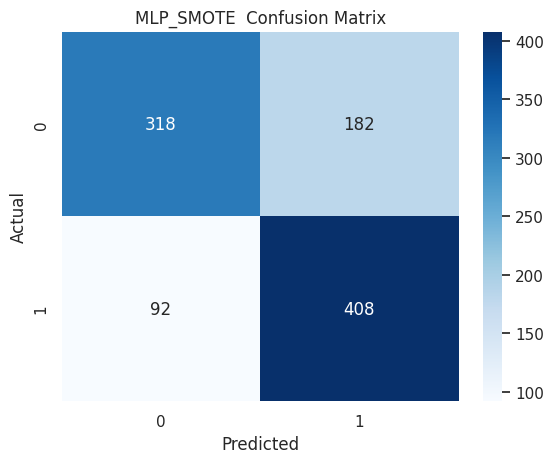



[0.7  0.79 0.74 0.67 0.54 0.75 0.8  0.8  0.78 0.69]

{'fit_time': array([0.81267023, 1.08315921, 0.68664169, 0.99165392, 1.18094063,
       0.98102164, 1.09265471, 0.82841825, 1.0112164 , 0.62679482]), 'score_time': array([0.00222182, 0.00703263, 0.00272799, 0.0037396 , 0.00173616,
       0.00602555, 0.00176501, 0.00179625, 0.0017693 , 0.00165701]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              mom

In [ ]:
#@title MLP on AUGMENTED dataset with SMOTE

reproducibilidad()

pima = valCruzada('MLP_SMOTE', df_pima_s.drop('CLASS', axis=1).values, df_pima_s['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

In [ ]:
#@title Aplicar SMOTE a los Imputados

reproducibilidad()

#from imblearn.over_sampling import BorderlineSMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline
oversample = SMOTE(sampling_strategy='auto', random_state=np.random.get_state()[1][0], k_neighbors=3)#, n_jobs=-1)
X, y = oversample.fit_resample(df_pima_i.drop('CLASS', axis=1), df_pima_i.CLASS)
X['CLASS'] = y
df_pima_i_s = X.copy(True)

# define pipeline
#over = SMOTE(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)
# transform the dataset
#X, y = pipeline.fit_resample(X, y)

print('SMOTE:')
print(df_pima_i_s.CLASS.value_counts())

SMOTE:
CLASS
1.0    500
0.0    500
Name: count, dtype: int64
time: 27.8 ms (started: 2025-10-01 04:29:04 +00:00)


MLP_SMOTE_imputed	acc=66.9000% (+/- 0.0896)


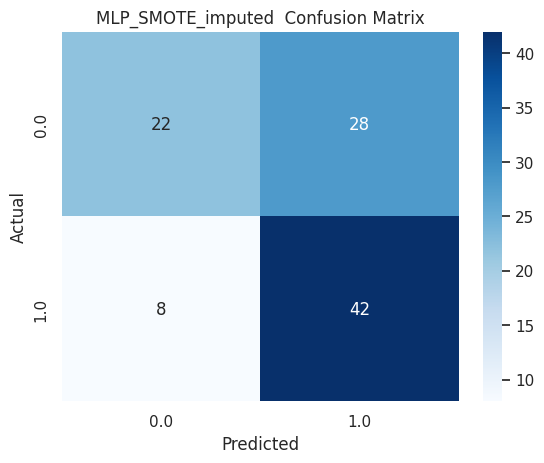

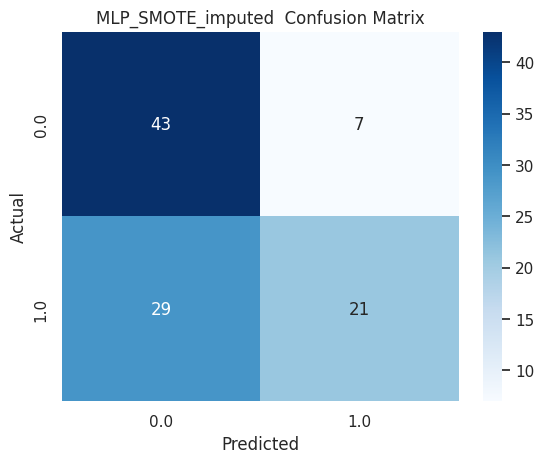

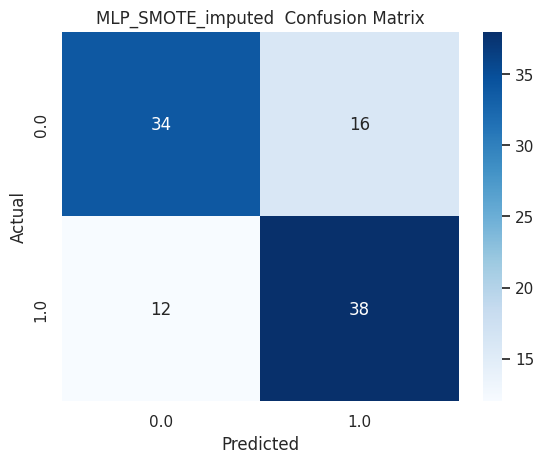

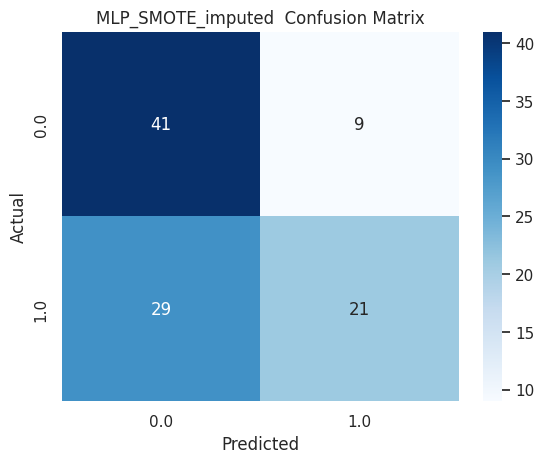

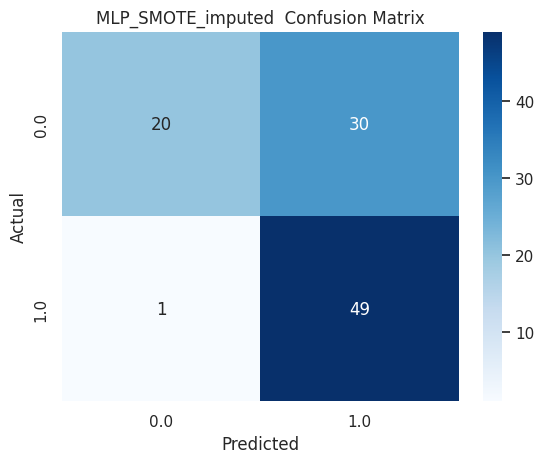

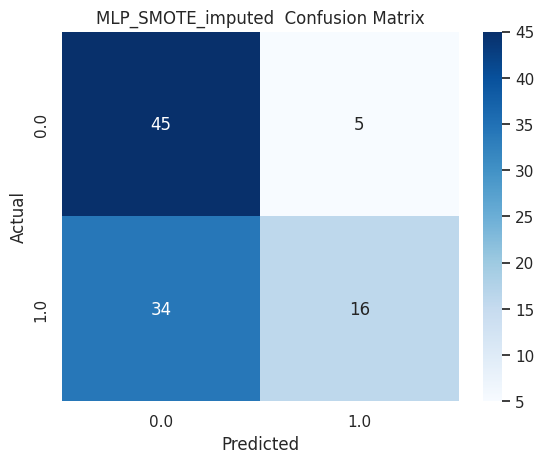

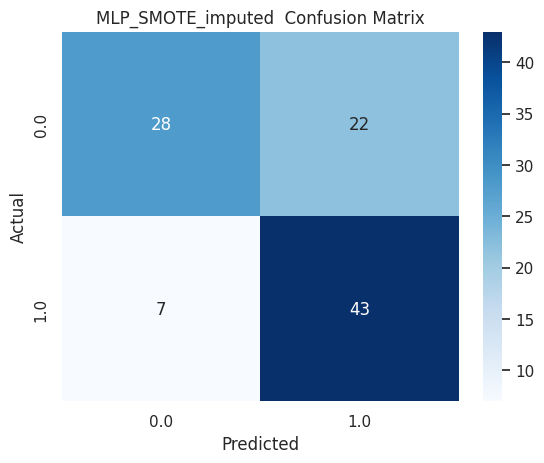

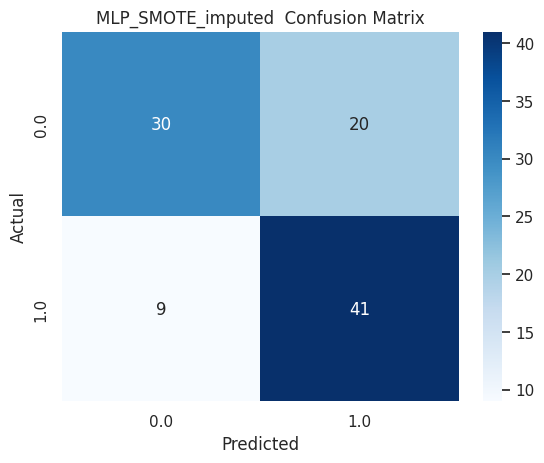

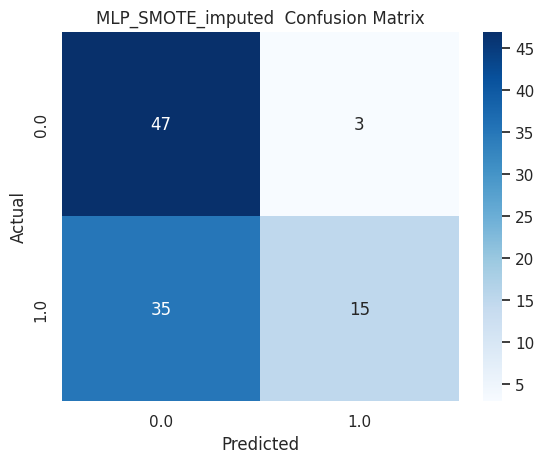

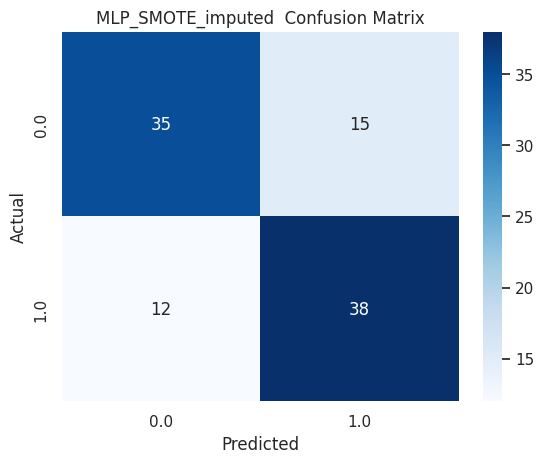

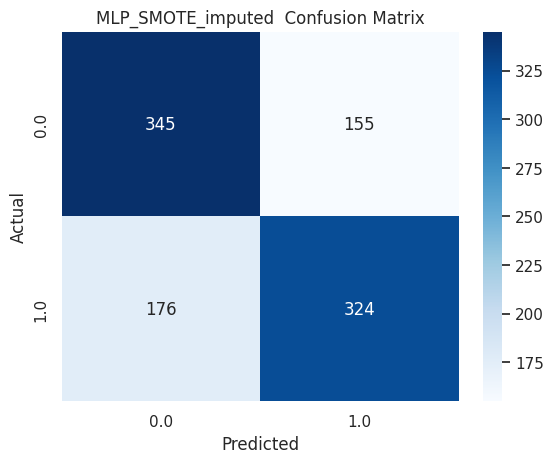



[0.64 0.64 0.72 0.62 0.69 0.61 0.71 0.71 0.62 0.73]

{'fit_time': array([0.41945052, 0.30817342, 1.01242471, 0.28977895, 0.39659357,
       0.21754217, 0.58674622, 0.65386367, 0.24632263, 0.61576843]), 'score_time': array([0.00377369, 0.00409722, 0.00190616, 0.00368547, 0.00223136,
       0.00162888, 0.00392652, 0.0048306 , 0.00401425, 0.00259113]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              mom

In [ ]:
#@title MLP on AUGMENTED dataset with SMOTE + imputed values

reproducibilidad()

pima = valCruzada('MLP_SMOTE_imputed', df_pima_i_s.drop('CLASS', axis=1).values, df_pima_i_s['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

In [ ]:
#@title Escalar datos SMOTE + imputed
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
df_pima_i_s_n = pd.DataFrame(escalar(df_pima_i_s.drop('CLASS', axis=1).values, 1), columns=df_pima_i_s.columns[:-1]).copy(True)
df_pima_i_s_n.index = df_pima_i_s.index
df_pima_i_s_n['CLASS']=df_pima_i_s['CLASS']
df_pima_i_s_n.head()

times_pregnant  plasma_glucose  diastolic  skin_thickness  serum_insulin  \
0        0.352941        0.670968   0.489796        0.304348       0.133814   
1        0.058824        0.264516   0.428571        0.239130       0.063301   
2        0.470588        0.896774   0.408163        0.250000       0.217548   
3        0.058824        0.290323   0.428571        0.173913       0.096154   
4        0.000000        0.600000   0.163265        0.304348       0.185096   

        bmi  diabetes_pedigree       age  CLASS  
0  0.314928           0.234415  0.483333    1.0  
1  0.171779           0.116567  0.166667    0.0  
2  0.104294           0.253629  0.183333    1.0  
3  0.202454           0.038002  0.000000    0.0  
4  0.509202           0.943638  0.200000    1.0

time: 27.6 ms (started: 2025-10-01 04:29:10 +00:00)


MLP_SMOTE_imputed_norm	acc=77.3000% (+/- 0.1203)


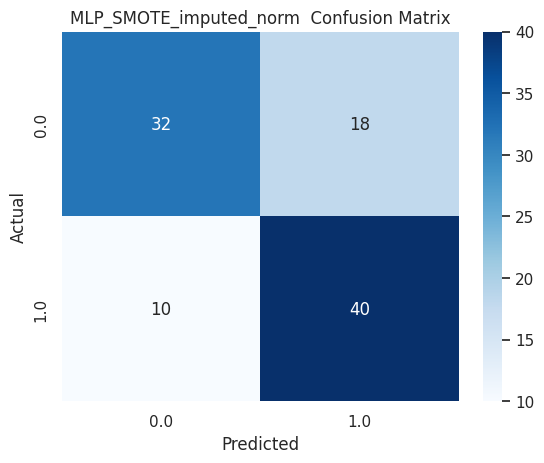

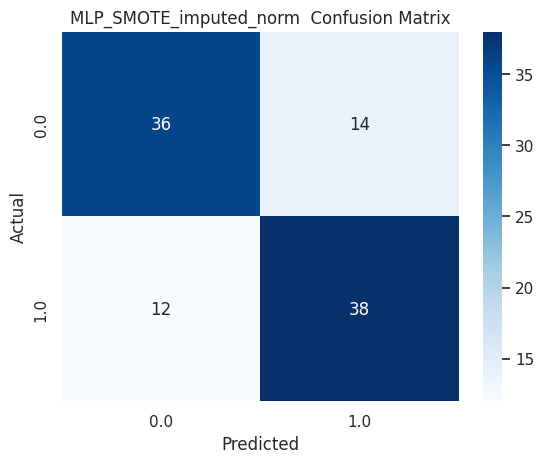

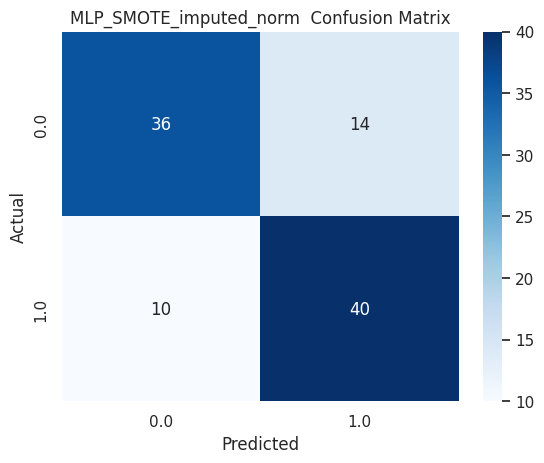

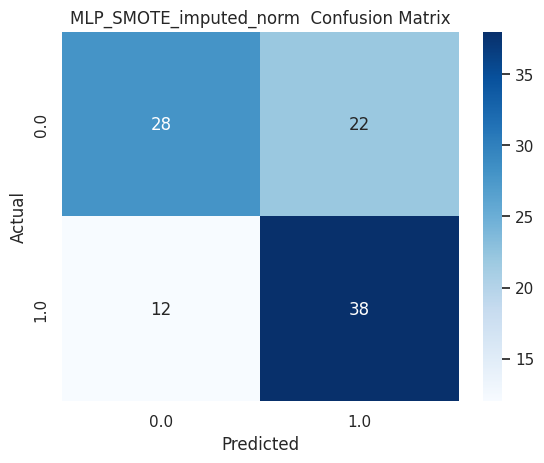

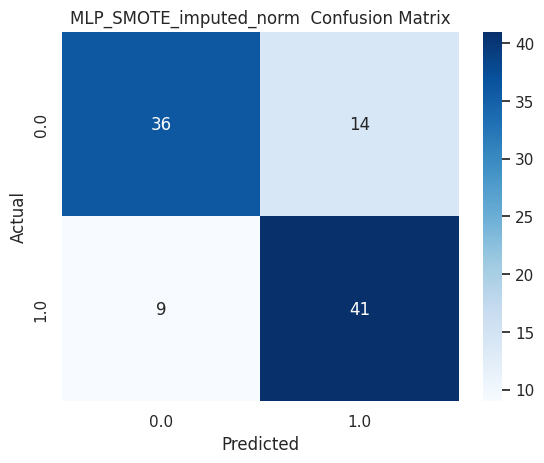

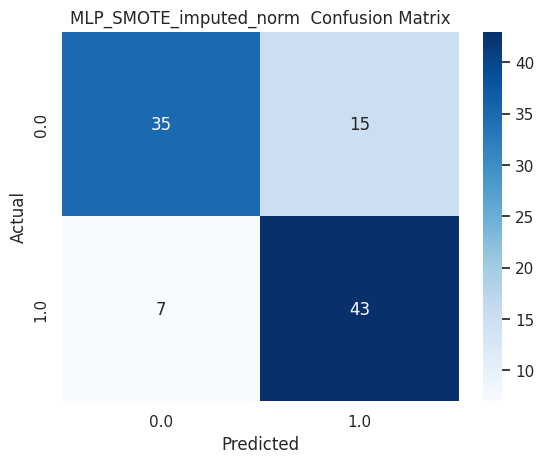

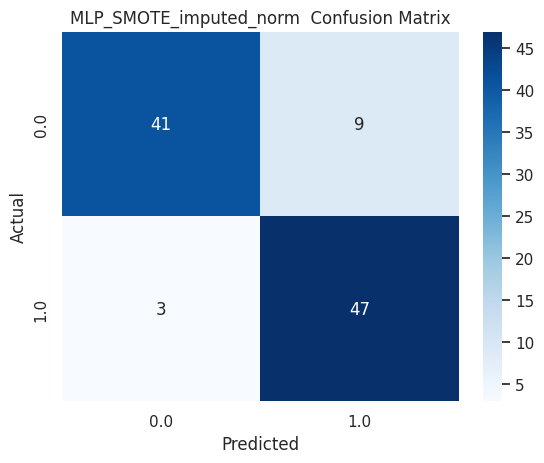

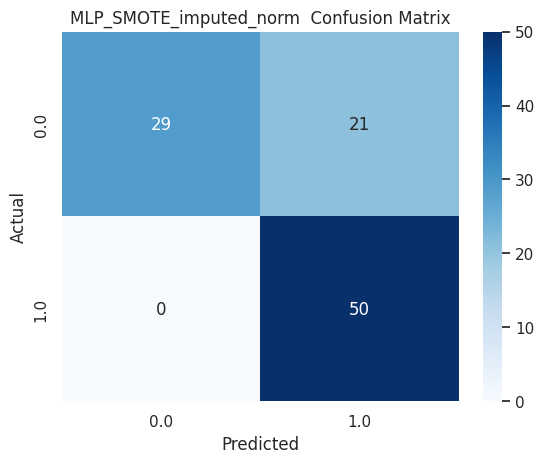

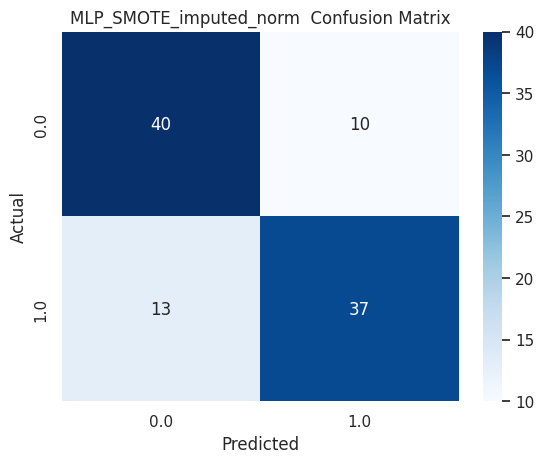

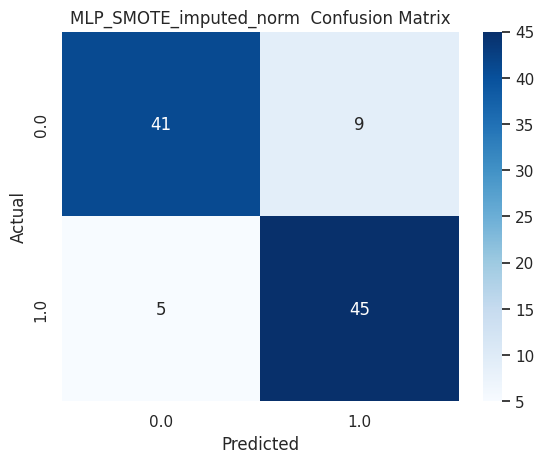

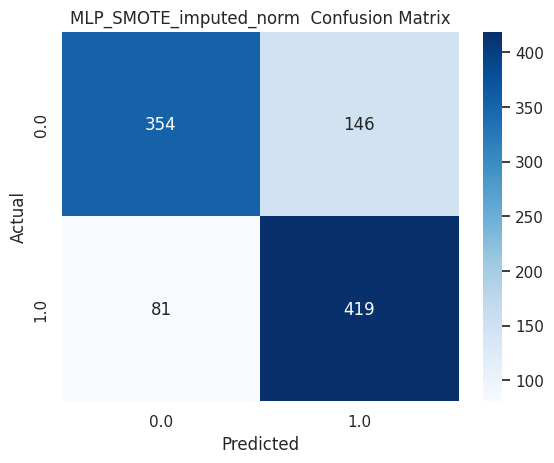



[0.72 0.74 0.76 0.66 0.77 0.78 0.88 0.79 0.77 0.86]

{'fit_time': array([0.55153537, 0.58166957, 0.51865506, 0.53760219, 0.43541956,
       0.57807612, 0.48412967, 0.3601675 , 0.32232094, 0.46400905]), 'score_time': array([0.00187373, 0.00173688, 0.00174332, 0.00314188, 0.00177836,
       0.002033  , 0.0017395 , 0.00182366, 0.00177908, 0.00174451]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              mom

In [ ]:
#@title MLP on AUGMENTED dataset with SMOTE + imputed + norm values

reproducibilidad()

pima = valCruzada('MLP_SMOTE_imputed_norm', df_pima_i_s_n.drop('CLASS', axis=1).values, df_pima_i_s_n['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

In [ ]:
#@title Limpiar variables

del X, oversample, y

time: 751 µs (started: 2025-10-01 04:29:15 +00:00)


# --- Third set of experiments

In [ ]:
#@title Configurar parámetros GAN

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_pima)
metadata.update_column(column_name='CLASS', sdtype='categorical')
#print(metadata.to_dict())
#print(metadata.validate())

model = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=False,#True,
    locales=['en_US'],
    embedding_dim=128,#10
    generator_dim=(5,5),#(128, 32, 17),#(256, 256),
    discriminator_dim=(5,5),#(128, 32, 17),#(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=100,#500,
    discriminator_steps=1,#5,
    log_frequency=True,
    verbose=True,#False,
    epochs=1000,#300,
    pac=10,
    cuda=True)

# https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/scalarrange

tp_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'times_pregnant',
      'low_value': df_pima['times_pregnant'].min(),
      'high_value': df_pima['times_pregnant'].max(),
      'strict_boundaries': False
  }
}
pg_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'plasma_glucose',
      'low_value': df_pima['plasma_glucose'].min(),
      'high_value': df_pima['plasma_glucose'].max(),
      'strict_boundaries': False
  }
}
d_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'diastolic',
      'low_value': df_pima['diastolic'].min(),
      'high_value': df_pima['diastolic'].max(),
      'strict_boundaries': False
  }
}
st_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'skin_thickness',
      'low_value': df_pima['skin_thickness'].min(),
      'high_value': df_pima['skin_thickness'].max(),
      'strict_boundaries': False
  }
}
si_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'serum_insulin',
      'low_value': df_pima['serum_insulin'].min(),
      'high_value': df_pima['serum_insulin'].max(),
      'strict_boundaries': False
  }
}
bmi_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'bmi',
      'low_value': df_pima['bmi'].min(),
      'high_value': df_pima['bmi'].max(),
      'strict_boundaries': False
  }
}
dp_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'diabetes_pedigree',
      'low_value': df_pima['diabetes_pedigree'].min(),
      'high_value': df_pima['diabetes_pedigree'].max(),
      'strict_boundaries': False
  }
}
age_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'age',
      'low_value': df_pima['age'].min(),
      'high_value': df_pima['age'].max(),
      'strict_boundaries': False
  }
}

model.add_constraints(constraints=[
    tp_constraint,
    pg_constraint,
    d_constraint,
    st_constraint,
    si_constraint,
    bmi_constraint,
    dp_constraint,
    age_constraint
])

time: 49 ms (started: 2025-10-01 04:29:15 +00:00)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sdv/cag/_utils.py:161: FutureWarning: The `add_constraints` function no longer supports constraints using the older dictionary-style definition. Such constraints will be ignored. Please supply objects from `sdv.cag` instead.
  warnings.warn(


In [ ]:
#@title Entrenar GAN

model.fit(df_pima)

#model.save('CTGAN_500e_256_64_17.pkl')
#model = model.load('CTGAN_500e_256_64_17.pkl')

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Gen. (0.11) | Discrim. (-0.67): 100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]

time: 2min 26s (started: 2025-10-01 04:29:15 +00:00)


In [ ]:
#@title Limpiar variables

del age_constraint, bmi_constraint, d_constraint, dp_constraint, pg_constraint, si_constraint, st_constraint, tp_constraint, metadata

time: 1.03 ms (started: 2025-10-01 04:31:42 +00:00)


In [ ]:
#@title Generar datos

#Generar Clase 1
pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 1}, num_rows=232)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
generated = generated.astype('float64')

df_pima_g = df_pima.merge(generated, how='outer')
df_pima_g

del conditions, generated, model

Sampling conditions: : 240it [00:04, 51.46it/s]

time: 4.69 s (started: 2025-10-01 04:31:42 +00:00)


In [ ]:
#@title Configurar parámetros GAN imputados

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_pima_i)
metadata.update_column(column_name='CLASS', sdtype='categorical')
#print(metadata.to_dict())
#print(metadata.validate())

model = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=False,#True,
    locales=['en_US'],
    embedding_dim=128,#10
    generator_dim=(5,5),#(128, 32, 17),#(256, 256),
    discriminator_dim=(5,5),#(128, 32, 17),#(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=100,#500,
    discriminator_steps=1,#5,
    log_frequency=True,
    verbose=True,#False,
    epochs=1000,#300,
    pac=10,
    cuda=True)

# https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/scalarrange

tp_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'times_pregnant',
      'low_value': df_pima_i['times_pregnant'].min(),
      'high_value': df_pima_i['times_pregnant'].max(),
      'strict_boundaries': False
  }
}
pg_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'plasma_glucose',
      'low_value': df_pima_i['plasma_glucose'].min(),
      'high_value': df_pima_i['plasma_glucose'].max(),
      'strict_boundaries': False
  }
}
d_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'diastolic',
      'low_value': df_pima_i['diastolic'].min(),
      'high_value': df_pima_i['diastolic'].max(),
      'strict_boundaries': False
  }
}
st_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'skin_thickness',
      'low_value': df_pima_i['skin_thickness'].min(),
      'high_value': df_pima_i['skin_thickness'].max(),
      'strict_boundaries': False
  }
}
si_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'serum_insulin',
      'low_value': df_pima_i['serum_insulin'].min(),
      'high_value': df_pima_i['serum_insulin'].max(),
      'strict_boundaries': False
  }
}
bmi_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'bmi',
      'low_value': df_pima_i['bmi'].min(),
      'high_value': df_pima_i['bmi'].max(),
      'strict_boundaries': False
  }
}
dp_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'diabetes_pedigree',
      'low_value': df_pima_i['diabetes_pedigree'].min(),
      'high_value': df_pima_i['diabetes_pedigree'].max(),
      'strict_boundaries': False
  }
}
age_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'age',
      'low_value': df_pima_i['age'].min(),
      'high_value': df_pima_i['age'].max(),
      'strict_boundaries': False
  }
}

model.add_constraints(constraints=[
    tp_constraint,
    pg_constraint,
    d_constraint,
    st_constraint,
    si_constraint,
    bmi_constraint,
    dp_constraint,
    age_constraint
])

time: 31.9 ms (started: 2025-10-01 04:31:47 +00:00)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sdv/cag/_utils.py:161: FutureWarning: The `add_constraints` function no longer supports constraints using the older dictionary-style definition. Such constraints will be ignored. Please supply objects from `sdv.cag` instead.
  warnings.warn(


In [ ]:
#@title Entrenar GAN imputados

model.fit(df_pima_i)

#model.save('CTGAN_500e_256_64_17.pkl')
#model = model.load('CTGAN_500e_256_64_17.pkl')

Gen. (0.34) | Discrim. (-1.30): 100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


time: 2min 16s (started: 2025-10-01 04:31:47 +00:00)


In [ ]:
#@title Limpiar variables

del age_constraint, bmi_constraint, d_constraint, dp_constraint, pg_constraint, si_constraint, st_constraint, tp_constraint, metadata

time: 847 µs (started: 2025-10-01 04:34:03 +00:00)


In [ ]:
#@title Generar datos imputados

pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 1}, num_rows=232)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
generated = generated.astype('float64')

df_pima_i_g = df_pima_i.merge(generated, how='outer')
df_pima_i_g

del conditions, generated, model

Sampling conditions: : 240it [00:05, 47.57it/s]

time: 5.06 s (started: 2025-10-01 04:34:03 +00:00)


In [ ]:
#@title Configurar parámetros GAN imputados + norm

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_pima_i_n)
metadata.update_column(column_name='CLASS', sdtype='categorical')
#print(metadata.to_dict())
#print(metadata.validate())

model = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=False,#True,
    locales=['en_US'],
    embedding_dim=128,#10
    generator_dim=(5,5),#(128, 32, 17),#(256, 256),
    discriminator_dim=(5,5),#(128, 32, 17),#(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=100,#500,
    discriminator_steps=1,#5,
    log_frequency=True,
    verbose=True,#False,
    epochs=1000,#300,
    pac=10,
    cuda=True)

# https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/scalarrange

tp_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'times_pregnant',
      'low_value': df_pima_i_n['times_pregnant'].min(),
      'high_value': df_pima_i_n['times_pregnant'].max(),
      'strict_boundaries': False
  }
}
pg_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'plasma_glucose',
      'low_value': df_pima_i_n['plasma_glucose'].min(),
      'high_value': df_pima_i_n['plasma_glucose'].max(),
      'strict_boundaries': False
  }
}
d_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'diastolic',
      'low_value': df_pima_i_n['diastolic'].min(),
      'high_value': df_pima_i_n['diastolic'].max(),
      'strict_boundaries': False
  }
}
st_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'skin_thickness',
      'low_value': df_pima_i_n['skin_thickness'].min(),
      'high_value': df_pima_i_n['skin_thickness'].max(),
      'strict_boundaries': False
  }
}
si_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'serum_insulin',
      'low_value': df_pima_i_n['serum_insulin'].min(),
      'high_value': df_pima_i_n['serum_insulin'].max(),
      'strict_boundaries': False
  }
}
bmi_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'bmi',
      'low_value': df_pima_i_n['bmi'].min(),
      'high_value': df_pima_i_n['bmi'].max(),
      'strict_boundaries': False
  }
}
dp_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'diabetes_pedigree',
      'low_value': df_pima_i_n['diabetes_pedigree'].min(),
      'high_value': df_pima_i_n['diabetes_pedigree'].max(),
      'strict_boundaries': False
  }
}
age_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'age',
      'low_value': df_pima_i_n['age'].min(),
      'high_value': df_pima_i_n['age'].max(),
      'strict_boundaries': False
  }
}

model.add_constraints(constraints=[
    tp_constraint,
    pg_constraint,
    d_constraint,
    st_constraint,
    si_constraint,
    bmi_constraint,
    dp_constraint,
    age_constraint
])

time: 30.8 ms (started: 2025-10-01 04:34:08 +00:00)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sdv/cag/_utils.py:161: FutureWarning: The `add_constraints` function no longer supports constraints using the older dictionary-style definition. Such constraints will be ignored. Please supply objects from `sdv.cag` instead.
  warnings.warn(


In [ ]:
#@title Entrenar GAN imputados + norm

model.fit(df_pima_i_n)

#model.save('CTGAN_500e_256_64_17.pkl')
#model = model.load('CTGAN_500e_256_64_17.pkl')

Gen. (0.56) | Discrim. (-0.01): 100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]

time: 2min 9s (started: 2025-10-01 04:34:09 +00:00)


In [ ]:
#@title Limpiar variables

del age_constraint, bmi_constraint, d_constraint, dp_constraint, pg_constraint, si_constraint, st_constraint, tp_constraint, metadata

time: 1.32 ms (started: 2025-10-01 04:36:18 +00:00)


In [ ]:
#@title Generar datos imputados + norm

pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 1}, num_rows=232)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
generated = generated.astype('float64')

df_pima_i_n_g = df_pima_i_n.merge(generated, how='outer')
df_pima_i_n_g

del conditions, generated, model

Sampling conditions: : 240it [00:05, 43.28it/s]

time: 5.56 s (started: 2025-10-01 04:36:18 +00:00)


In [ ]:
def estadist(data):
  columns = data.drop('CLASS', axis=1).columns
  for col in columns:
    print(data[col].describe())
    print()


print('\t\t\t\t---------- df_pima ----------')
estadist(df_pima)
print('\t\t\t\t---------- df_pima_i ----------')
estadist(df_pima_i)
print('\t\t\t\t---------- df_pima_i_n ----------')
estadist(df_pima_i_n)

print('\t\t\t\t---------- df_pima_s ----------')
estadist(df_pima_s)
print('\t\t\t\t---------- df_pima_i_s ----------')
estadist(df_pima_i_s)
print('\t\t\t\t---------- df_pima_i_s_n ----------')
estadist(df_pima_i_s_n)

print('\t\t\t\t---------- df_pima_g ----------')
estadist(df_pima_g)
print('\t\t\t\t---------- df_pima_i_g ----------')
estadist(df_pima_i_g)
print('\t\t\t\t---------- df_pima_i_n_g ----------')
estadist(df_pima_i_n_g)

				---------- df_pima ----------
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: times_pregnant, dtype: float64

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: plasma_glucose, dtype: float64

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: diastolic, dtype: float64

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: skin_thickness, dtype: float64

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: serum_insulin

In [ ]:
df_pima.describe()

times_pregnant  plasma_glucose   diastolic  skin_thickness  \
count      768.000000      768.000000  768.000000      768.000000   
mean         3.845052      120.894531   69.105469       20.536458   
std          3.369578       31.972618   19.355807       15.952218   
min          0.000000        0.000000    0.000000        0.000000   
25%          1.000000       99.000000   62.000000        0.000000   
50%          3.000000      117.000000   72.000000       23.000000   
75%          6.000000      140.250000   80.000000       32.000000   
max         17.000000      199.000000  122.000000       99.000000   

       serum_insulin         bmi  diabetes_pedigree         age       CLASS  
count     768.000000  768.000000         768.000000  768.000000  768.000000  
mean       79.799479   31.992578           0.471876   33.240885    0.348958  
std       115.244002    7.884160           0.331329   11.760232    0.476951  
min         0.000000    0.000000           0.078000   21.000000    0.000000  
25%         0.000000   27.300000           0.243750   24.000000    0.000000  
50%        30.500000   32.000000           0.372500   29.000000    0.000000  
75%       127.250000   36.600000           0.626250   41.000000    1.000000  
max       846.000000   67.100000           2.420000   81.000000    1.000000

time: 33.2 ms (started: 2025-10-01 04:36:23 +00:00)


In [ ]:
df_pima_i.describe()

times_pregnant  plasma_glucose   diastolic  skin_thickness  \
count      768.000000      768.000000  768.000000      768.000000   
mean         3.845052      121.563368   72.342448       29.099392   
std          3.369578       30.550074   12.221390        9.580304   
min          0.000000       44.000000   24.000000        7.000000   
25%          1.000000       99.000000   64.000000       22.333333   
50%          3.000000      117.000000   72.000000       29.000000   
75%          6.000000      141.000000   80.000000       35.000000   
max         17.000000      199.000000  122.000000       99.000000   

       serum_insulin         bmi  diabetes_pedigree         age       CLASS  
count     768.000000  768.000000         768.000000  768.000000  768.000000  
mean      153.414062   32.426259           0.471876   33.240885    0.348958  
std       100.846193    6.889295           0.331329   11.760232    0.476951  
min        14.000000   18.200000           0.078000   21.000000    0.000000  
25%        83.000000   27.500000           0.243750   24.000000    0.000000  
50%       132.000000   32.150000           0.372500   29.000000    0.000000  
75%       191.000000   36.600000           0.626250   41.000000    1.000000  
max       846.000000   67.100000           2.420000   81.000000    1.000000

time: 34 ms (started: 2025-10-01 04:36:23 +00:00)


In [ ]:
df_pima_i_n.describe()

times_pregnant  plasma_glucose   diastolic  skin_thickness  \
count      768.000000      768.000000  768.000000      768.000000   
mean         0.226180        0.500409    0.493290        0.240211   
std          0.198210        0.197097    0.124708        0.104134   
min          0.000000        0.000000    0.000000        0.000000   
25%          0.058824        0.354839    0.408163        0.166667   
50%          0.176471        0.470968    0.489796        0.239130   
75%          0.352941        0.625806    0.571429        0.304348   
max          1.000000        1.000000    1.000000        1.000000   

       serum_insulin         bmi  diabetes_pedigree         age       CLASS  
count     768.000000  768.000000         768.000000  768.000000  768.000000  
mean        0.167565    0.290926           0.168179    0.204015    0.348958  
std         0.121209    0.140885           0.141473    0.196004    0.476951  
min         0.000000    0.000000           0.000000    0.000000    0.000000  
25%         0.082933    0.190184           0.070773    0.050000    0.000000  
50%         0.141827    0.285276           0.125747    0.133333    0.000000  
75%         0.212740    0.376278           0.234095    0.333333    1.000000  
max         1.000000    1.000000           1.000000    1.000000    1.000000

time: 34.7 ms (started: 2025-10-01 04:36:23 +00:00)


In [ ]:
df_pima_s.describe()

times_pregnant  plasma_glucose    diastolic  skin_thickness  \
count     1000.000000     1000.000000  1000.000000     1000.000000   
mean         4.080595      125.471205    69.422866       20.546817   
std          3.348567       32.789992    20.053086       16.155582   
min          0.000000        0.000000     0.000000        0.000000   
25%          1.000000      102.225027    64.000000        0.000000   
50%          3.000000      122.000000    72.000000       23.205804   
75%          6.451279      147.000000    80.000000       32.918511   
max         17.000000      199.000000   122.000000       99.000000   

       serum_insulin          bmi  diabetes_pedigree          age       CLASS  
count    1000.000000  1000.000000        1000.000000  1000.000000  1000.00000  
mean       81.574955    32.604060           0.482482    34.037287     0.50000  
std       117.518367     7.629701           0.323135    11.412610     0.50025  
min         0.000000     0.000000           0.078000    21.000000     0.00000  
25%         0.000000    28.183885           0.252750    25.000000     0.00000  
50%        14.500000    32.409022           0.394630    30.997545     0.50000  
75%       130.181089    36.811029           0.640000    41.000000     1.00000  
max       846.000000    67.100000           2.420000    81.000000     1.00000

time: 34.2 ms (started: 2025-10-01 04:36:24 +00:00)


In [ ]:
df_pima_i_s.describe()

times_pregnant  plasma_glucose    diastolic  skin_thickness  \
count     1000.000000     1000.000000  1000.000000     1000.000000   
mean         4.089512      126.153462    73.087089       29.799044   
std          3.379199       31.146349    11.858696        9.138007   
min          0.000000       44.000000    24.000000        7.000000   
25%          1.000000      102.628453    65.185890       23.666667   
50%          3.000000      122.000000    72.372450       30.000000   
75%          6.000000      147.000000    80.000000       35.666667   
max         17.000000      199.000000   122.000000       99.000000   

       serum_insulin          bmi  diabetes_pedigree          age       CLASS  
count    1000.000000  1000.000000        1000.000000  1000.000000  1000.00000  
mean      159.955775    33.054222           0.488730    33.953362     0.50000  
std       101.076999     6.763198           0.324363    11.407015     0.50025  
min        14.000000    18.200000           0.078000    21.000000     0.00000  
25%        92.293042    28.400000           0.254750    25.000000     0.00000  
50%       140.000000    32.800000           0.402570    30.548115     0.50000  
75%       195.000000    36.900000           0.646250    41.000000     1.00000  
max       846.000000    67.100000           2.420000    81.000000     1.00000

time: 43 ms (started: 2025-10-01 04:36:24 +00:00)


In [ ]:
df_pima_i_s_n.describe()

times_pregnant  plasma_glucose    diastolic  skin_thickness  \
count     1000.000000     1000.000000  1000.000000     1000.000000   
mean         0.240560        0.530022     0.500889        0.247816   
std          0.198776        0.200944     0.121007        0.099326   
min          0.000000        0.000000     0.000000        0.000000   
25%          0.058824        0.378248     0.420264        0.181159   
50%          0.176471        0.503226     0.493596        0.250000   
75%          0.352941        0.664516     0.571429        0.311594   
max          1.000000        1.000000     1.000000        1.000000   

       serum_insulin          bmi  diabetes_pedigree          age       CLASS  
count    1000.000000  1000.000000        1000.000000  1000.000000  1000.00000  
mean        0.175428     0.303767           0.175376     0.215889     0.50000  
std         0.121487     0.138307           0.138498     0.190117     0.50025  
min         0.000000     0.000000           0.000000     0.000000     0.00000  
25%         0.094102     0.208589           0.075470     0.066667     0.00000  
50%         0.151442     0.298569           0.138587     0.159135     0.50000  
75%         0.217548     0.382413           0.242635     0.333333     1.00000  
max         1.000000     1.000000           1.000000     1.000000     1.00000

time: 48.1 ms (started: 2025-10-01 04:36:24 +00:00)


In [ ]:
df_pima_g.describe()

times_pregnant  plasma_glucose    diastolic  skin_thickness  \
count     1000.000000     1000.000000  1000.000000     1000.000000   
mean         3.720894      119.691169    69.473529       20.490339   
std          3.420646       34.294727    20.752906       16.357830   
min          0.000000        0.000000     0.000000        0.000000   
25%          1.000000       95.937886    62.000000        0.000000   
50%          3.000000      117.000000    72.000000       22.000000   
75%          6.000000      143.000000    81.961496       33.000000   
max         17.000000      199.000000   122.000000       99.000000   

       serum_insulin          bmi  diabetes_pedigree          age       CLASS  
count    1000.000000  1000.000000        1000.000000  1000.000000  1000.00000  
mean       73.601811    31.795184           0.474832    33.281840     0.50000  
std       111.742670     8.503588           0.354263    12.225474     0.50025  
min         0.000000     0.000000           0.078000    21.000000     0.00000  
25%         0.000000    26.296005           0.234000    24.000000     0.00000  
50%        14.500000    31.796293           0.370500    29.000000     0.50000  
75%       120.000000    36.702261           0.627500    40.054414     1.00000  
max       846.000000    67.100000           2.420000    81.000000     1.00000

time: 42.7 ms (started: 2025-10-01 04:36:24 +00:00)


In [ ]:
df_pima_i_g.describe()

times_pregnant  plasma_glucose    diastolic  skin_thickness  \
count     1000.000000     1000.000000  1000.000000     1000.000000   
mean         3.836261      121.311090    72.582399       29.100276   
std          3.578901       33.071808    15.004747       11.016847   
min          0.000000       44.000000    24.000000        7.000000   
25%          1.000000       97.000000    64.000000       21.993318   
50%          3.000000      117.000000    72.000000       29.000000   
75%          6.000000      142.166667    82.000000       36.000000   
max         17.000000      199.000000   122.000000       99.000000   

       serum_insulin          bmi  diabetes_pedigree          age       CLASS  
count    1000.000000  1000.000000        1000.000000  1000.000000  1000.00000  
mean      156.105098    32.613664           0.476124    34.044032     0.50000  
std       112.567467     7.606222           0.358396    13.023945     0.50025  
min        14.000000    18.200000           0.078000    21.000000     0.00000  
25%        82.000000    27.285299           0.235750    24.000000     0.00000  
50%       131.895407    32.306720           0.371465    29.000000     0.50000  
75%       192.333333    36.950279           0.629250    41.000000     1.00000  
max       846.000000    67.100000           2.420000    81.000000     1.00000

time: 35.2 ms (started: 2025-10-01 04:36:24 +00:00)


In [ ]:
df_pima_i_n_g.describe()

times_pregnant  plasma_glucose    diastolic  skin_thickness  \
count     1000.000000     1000.000000  1000.000000     1000.000000   
mean         0.235113        0.507799     0.499806        0.242195   
std          0.215863        0.201939     0.138812        0.113409   
min          0.000000        0.000000     0.000000        0.000000   
25%          0.058824        0.361290     0.408163        0.165408   
50%          0.176471        0.483871     0.489796        0.239130   
75%          0.352941        0.638710     0.589702        0.314284   
max          1.000000        1.000000     1.000000        1.000000   

       serum_insulin          bmi  diabetes_pedigree          age       CLASS  
count    1000.000000  1000.000000        1000.000000  1000.000000  1000.00000  
mean        0.167767     0.294726           0.163701     0.199478     0.50000  
std         0.127182     0.153058           0.149791     0.198077     0.50025  
min         0.000000     0.000000           0.000000     0.000000     0.00000  
25%         0.082933     0.186094           0.060983     0.050000     0.00000  
50%         0.141339     0.290389           0.118702     0.133333     0.50000  
75%         0.213642     0.385206           0.231533     0.316667     1.00000  
max         1.000000     1.000000           1.000000     1.000000     1.00000

time: 37.1 ms (started: 2025-10-01 04:36:24 +00:00)


In [ ]:
if True:
  from google.colab import files

  df_pima.to_csv('df_pima.csv')
  df_pima_i.to_csv('df_pima_i.csv')
  df_pima_i_n.to_csv('df_pima_i_n.csv')

  df_pima_s.to_csv('df_pima_s.csv')
  df_pima_i_s.to_csv('df_pima_i_s.csv')
  df_pima_i_s_n.to_csv('df_pima_i_s_n.csv')

  df_pima_g.to_csv('df_pima_g.csv')
  df_pima_i_g.to_csv('df_pima_i_g.csv')
  df_pima_i_n_g.to_csv('df_pima_i_n_g.csv')

  !zip -r dataframes.zip df_pim*
  files.download("dataframes.zip")

  adding: df_pima.csv (deflated 68%)
  adding: df_pima_g.csv (deflated 59%)
  adding: df_pima_i.csv (deflated 70%)
  adding: df_pima_i_g.csv (deflated 60%)
  adding: df_pima_i_n.csv (deflated 81%)
  adding: df_pima_i_n_g.csv (deflated 74%)
  adding: df_pima_i_s.csv (deflated 61%)
  adding: df_pima_i_s_n.csv (deflated 74%)
  adding: df_pima_s.csv (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 211 ms (started: 2025-10-01 04:42:06 +00:00)


MLP_GAN	acc=51.5000% (+/- 0.0628)


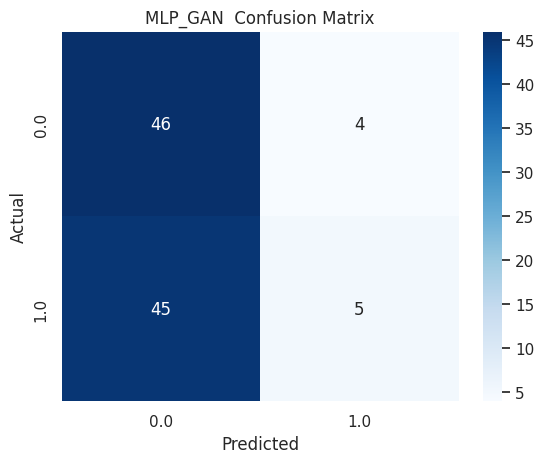

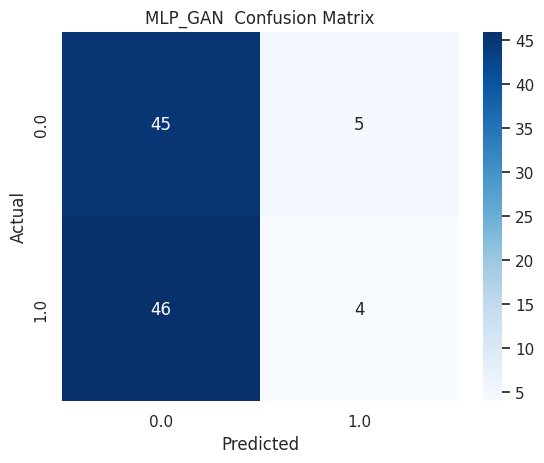

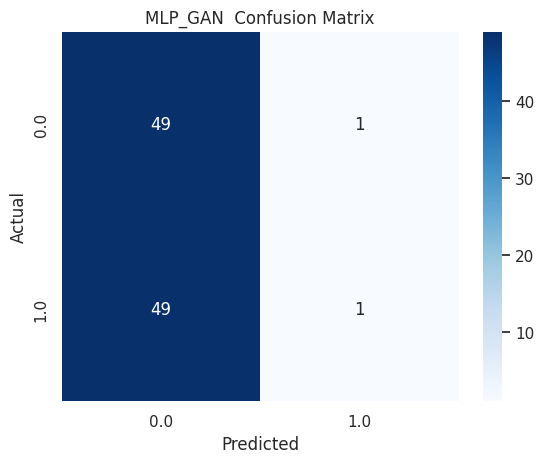

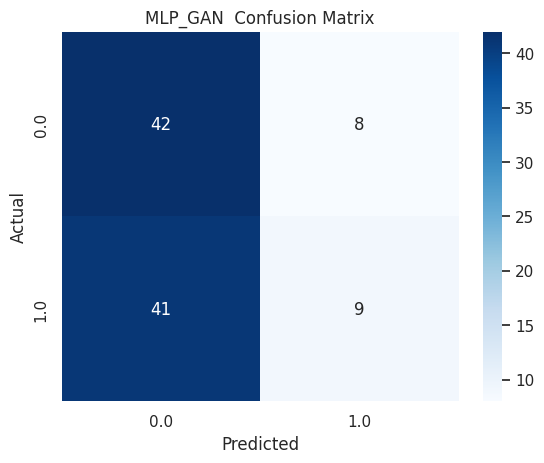

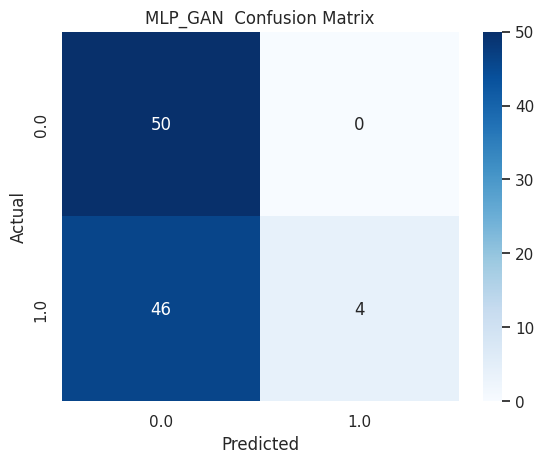

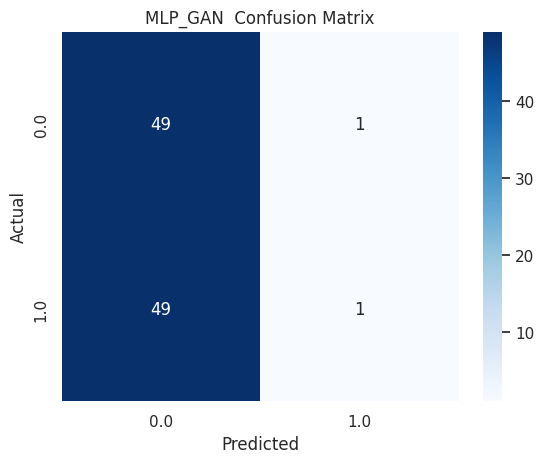

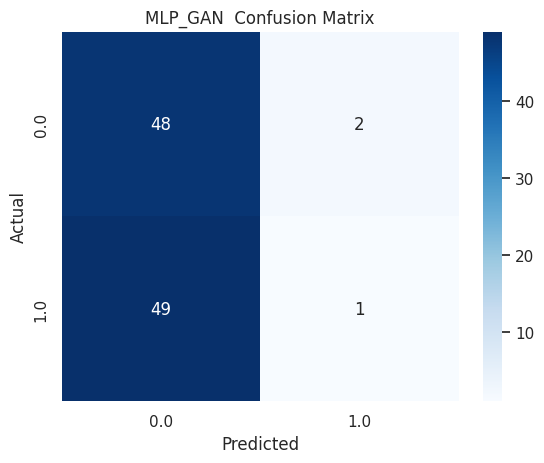

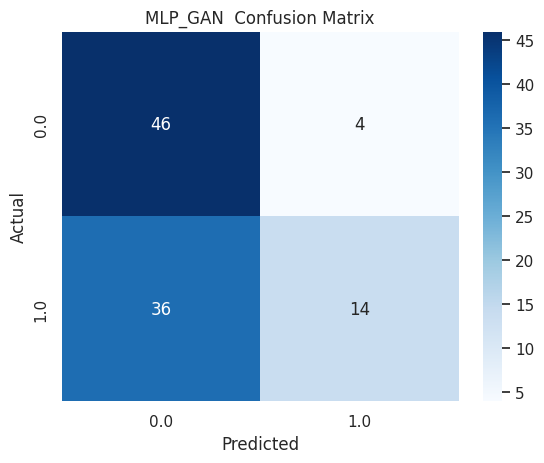

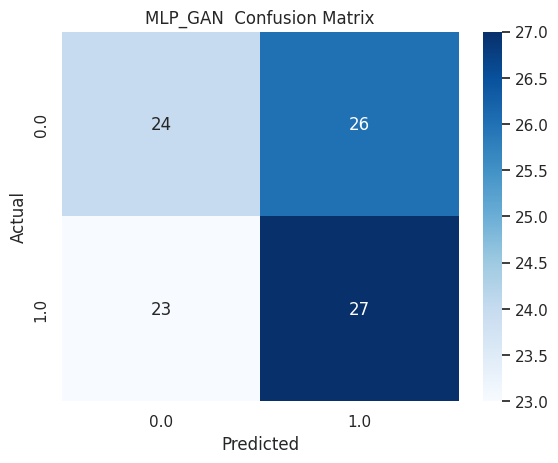

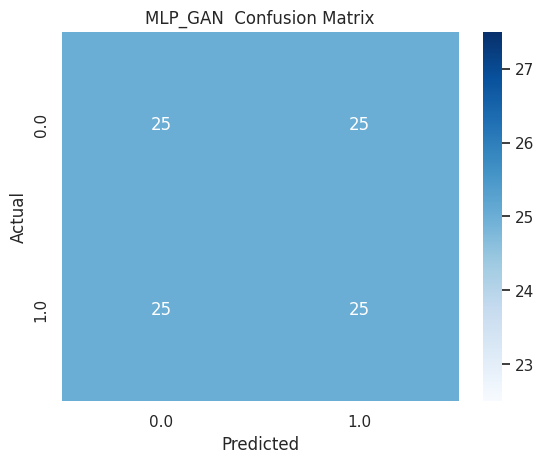

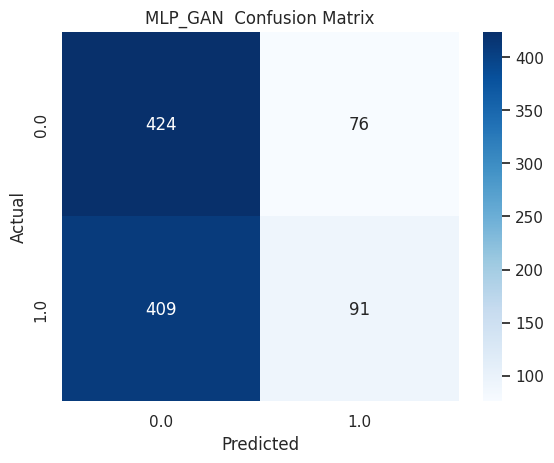



[0.51 0.49 0.5  0.51 0.54 0.5  0.49 0.6  0.51 0.5 ]

{'fit_time': array([0.23839283, 0.10714507, 0.23165417, 0.21909857, 0.17843747,
       0.15049577, 0.45301342, 0.19553185, 0.4120326 , 0.33414459]), 'score_time': array([0.002321  , 0.00236845, 0.00185418, 0.0019002 , 0.00175047,
       0.00188327, 0.00188804, 0.00176096, 0.00198603, 0.00124002]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              mom

In [ ]:
#@title MLP on GAN dataset

reproducibilidad()

pima = valCruzada('MLP_GAN', df_pima_g.drop('CLASS', axis=1).values, df_pima_g['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

MLP_GAN_imputed	acc=58.9000% (+/- 0.0994)


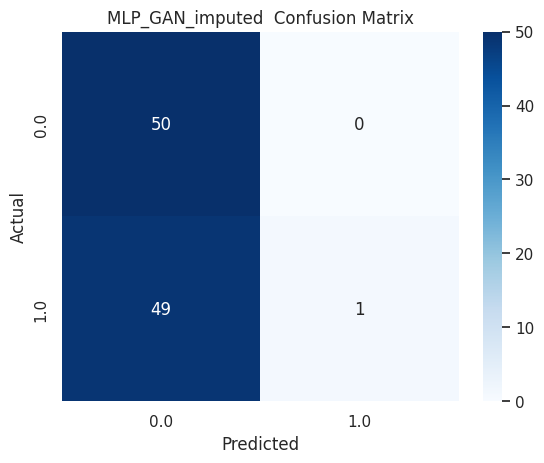

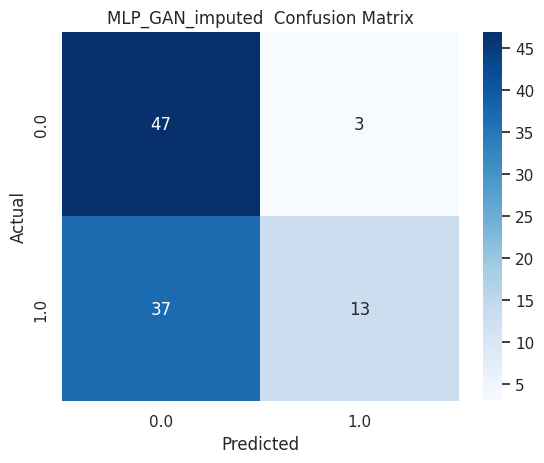

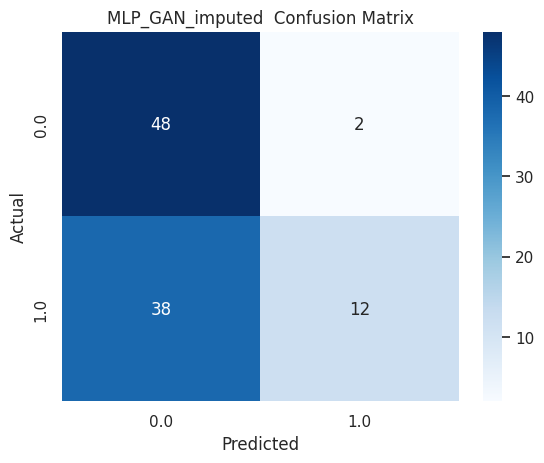

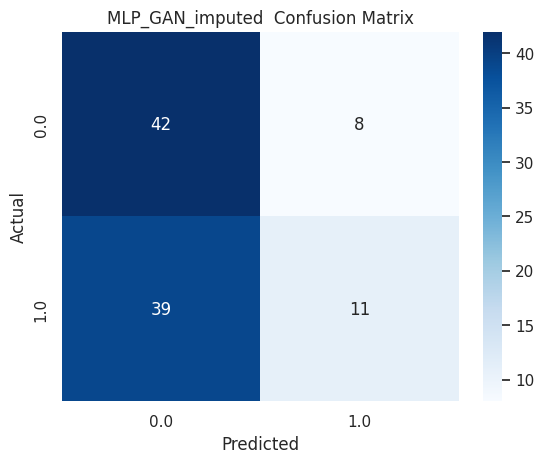

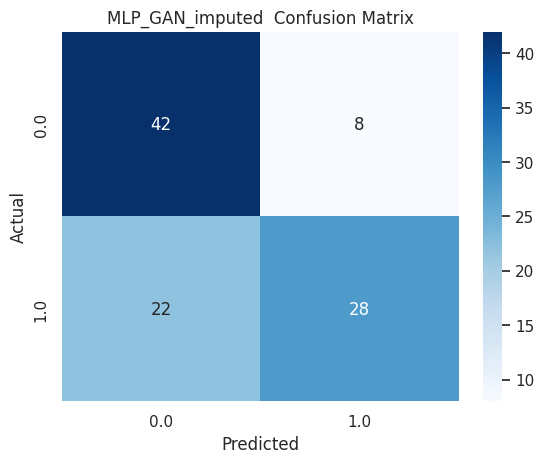

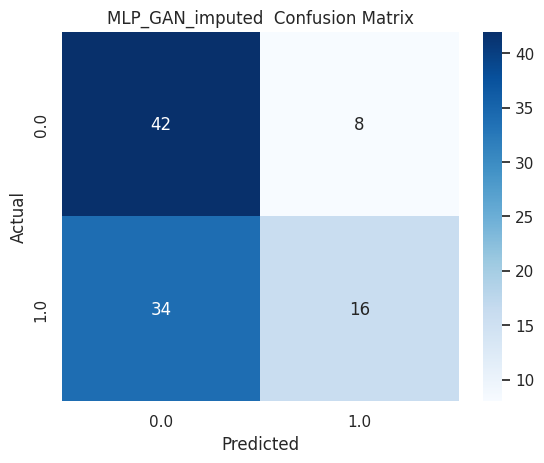

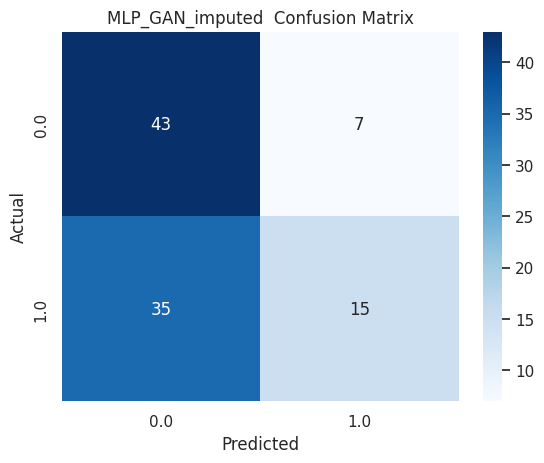

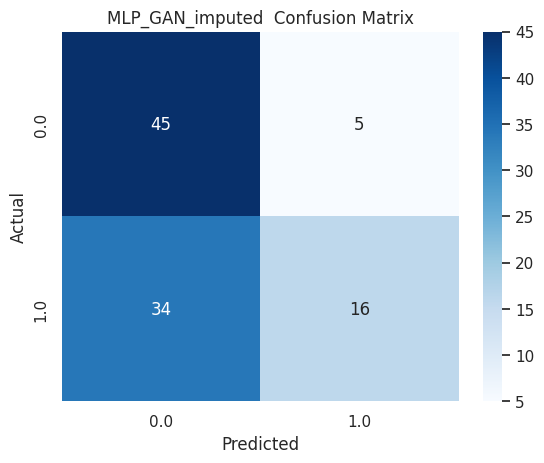

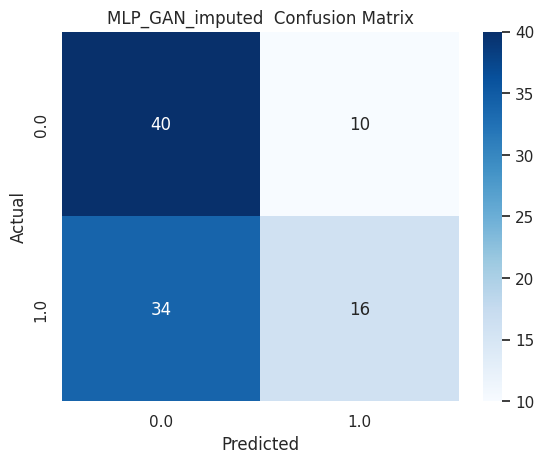

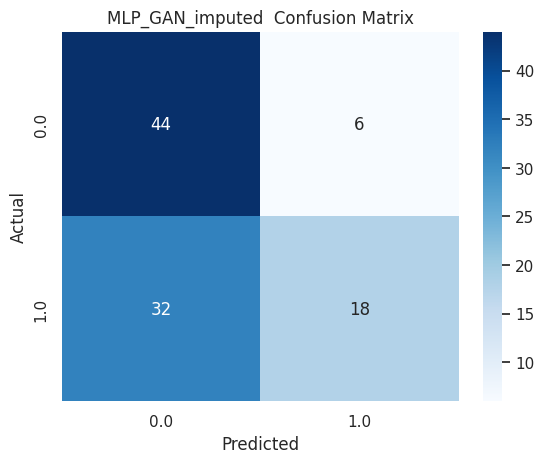

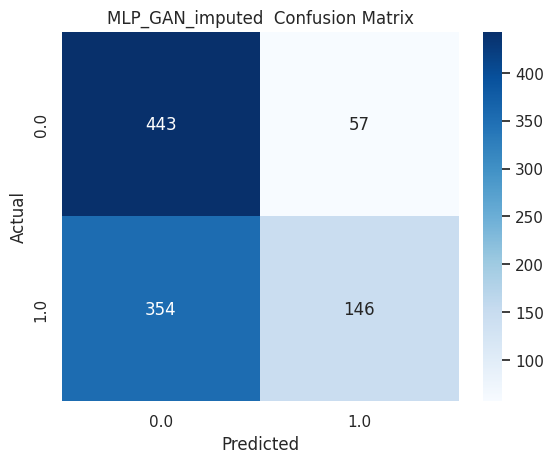



[0.51 0.6  0.6  0.53 0.7  0.58 0.58 0.61 0.56 0.62]

{'fit_time': array([0.25376916, 0.20446634, 0.26865983, 0.25851226, 0.14492583,
       0.15991402, 0.21901655, 0.16105199, 0.18288398, 0.19533324]), 'score_time': array([0.00185704, 0.00174022, 0.00173259, 0.00210571, 0.00180054,
       0.00175428, 0.00170541, 0.00177026, 0.00180864, 0.00132298]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              mom

In [ ]:
#@title MLP on GAN dataset + imputed values

reproducibilidad()

pima = valCruzada('MLP_GAN_imputed', df_pima_i_g.drop('CLASS', axis=1).values, df_pima_i_g['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

MLP_GAN_imputed_norm	acc=69.2000% (+/- 0.1528)


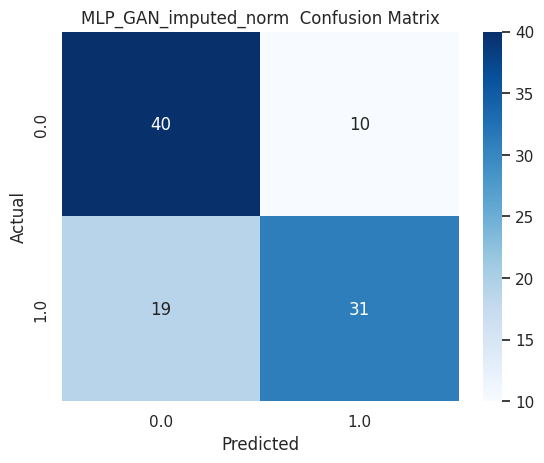

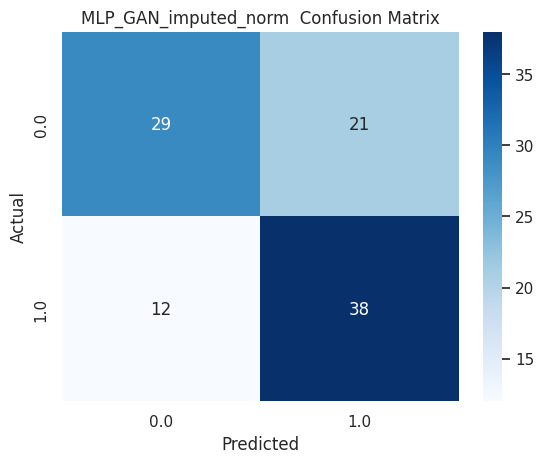

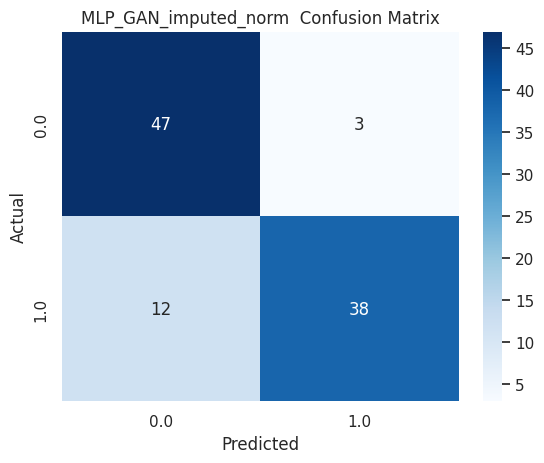

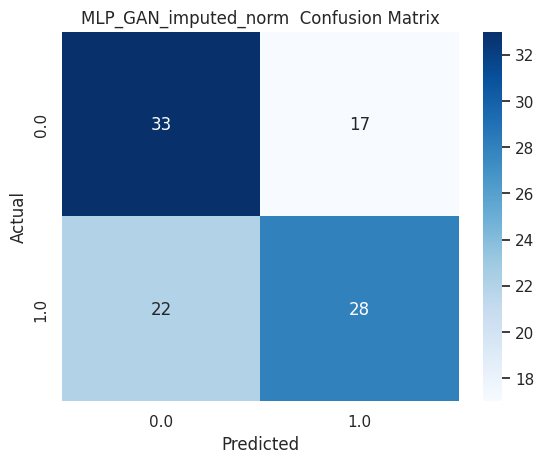

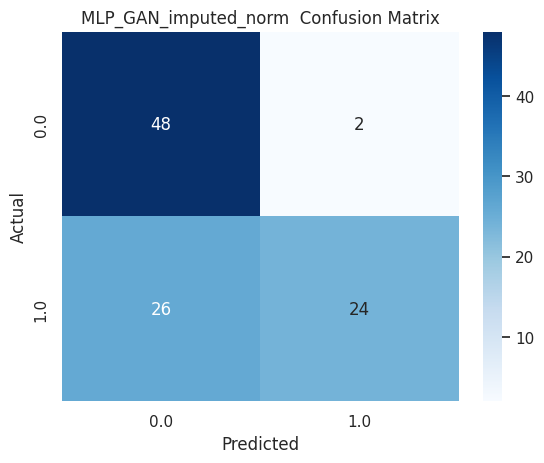

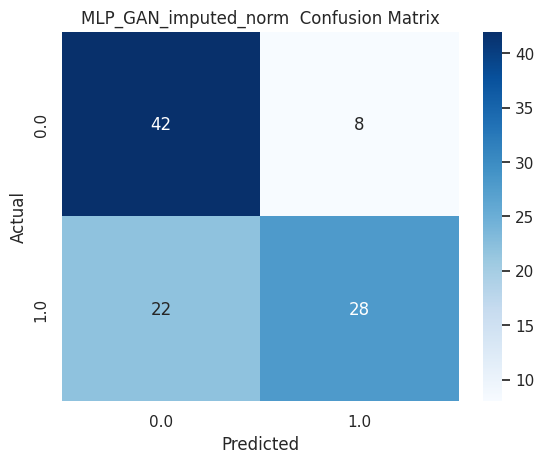

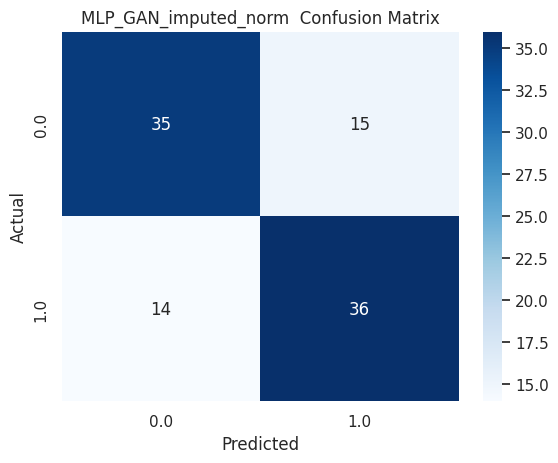

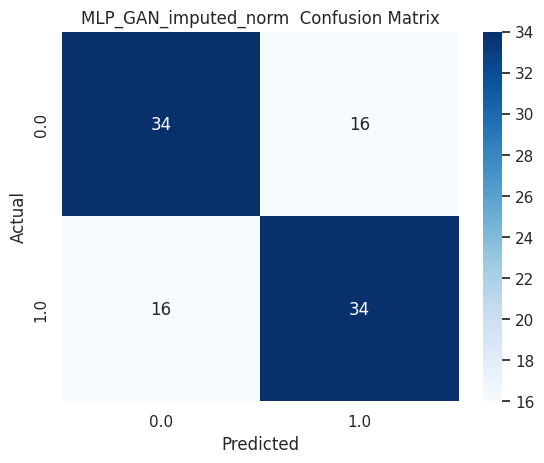

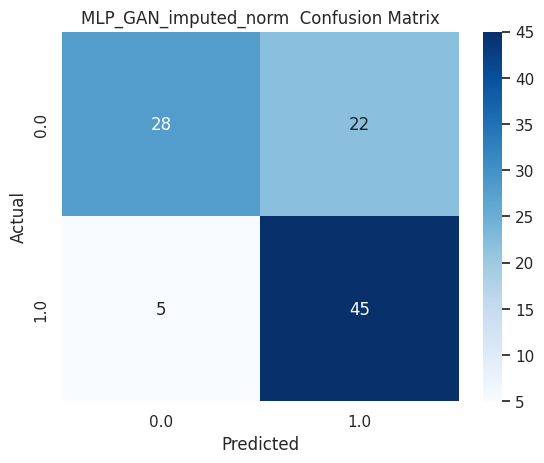

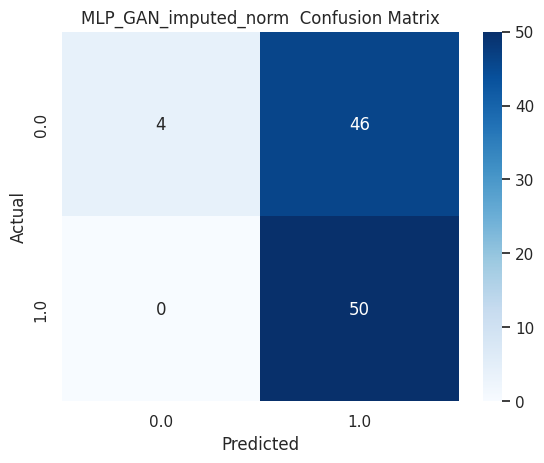

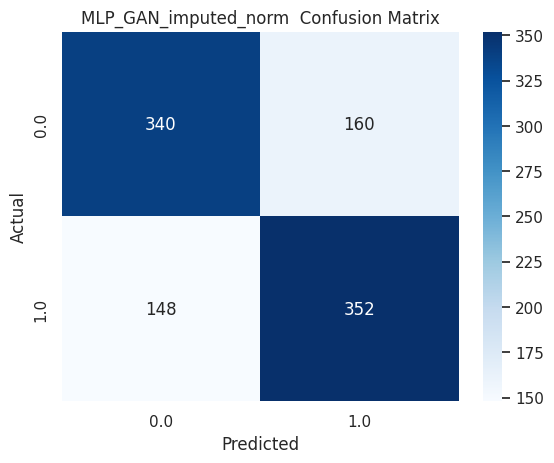



[0.71 0.67 0.85 0.61 0.72 0.7  0.71 0.68 0.73 0.54]

{'fit_time': array([0.64874125, 0.87324047, 0.98247623, 0.92112398, 0.60010457,
       0.77427292, 0.86959553, 0.75292039, 0.77985477, 0.70735693]), 'score_time': array([0.00335908, 0.00397754, 0.00380445, 0.00167298, 0.00296497,
       0.00221848, 0.00402141, 0.00221825, 0.00382304, 0.00223827]), 'estimator': [MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              momentum=0.2, random_state=np.uint32(1211), solver='lbfgs'), MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
              learning_rate='adaptive', learning_rate_init=0.03, max_iter=500,
              mom

In [ ]:
#@title MLP on GAN dataset + imputed + norm values

reproducibilidad()

pima = valCruzada('MLP_GAN_imputed_norm', df_pima_i_n_g.drop('CLASS', axis=1).values, df_pima_i_n_g['CLASS'].values)
print(pima['test_accuracy'])
print()
print(pima)
print()

del pima

In [ ]:
!ls
!zip -r img.zip img/
from google.colab import files
files.download('img.zip')

img  pima_indians_diabetes.arff  sample_data
  adding: img/ (stored 0%)
  adding: img/confusion_matrix/ (stored 0%)
  adding: img/confusion_matrix/MLP_Original_imputed_confusion_matrix_2.png (deflated 12%)
  adding: img/confusion_matrix/MLP_SMOTE_imputed_norm_confusion_matrix_4.png (deflated 13%)
  adding: img/confusion_matrix/MLP_Original_confusion_matrix_1.png (deflated 13%)
  adding: img/confusion_matrix/MLP_GAN_imputed_norm_confusion_matrix_4.png (deflated 12%)
  adding: img/confusion_matrix/MLP_GAN_imputed_confusion_matrix_2.png (deflated 11%)
  adding: img/confusion_matrix/MLP_SMOTE_imputed_norm_confusion_matrix_0.png (deflated 12%)
  adding: img/confusion_matrix/MLP_Original_imputed_norm_confusion_matrix_5.png (deflated 13%)
  adding: img/confusion_matrix/MLP_GAN_imputed_confusion_matrix_8.png (deflated 12%)
  adding: img/confusion_matrix/MLP_SMOTE_imputed_confusion_matrix_9.png (deflated 12%)
  adding: img/confusion_matrix/MLP_GAN_confusion_matrix_2.png (deflated 13%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 216 ms (started: 2025-10-01 04:36:39 +00:00)


In [ ]:
#@title Importar librerías para métricas de distancia entre distribuciones
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def calculate_distribution_distances(original_data, generated_data, feature_name):
    """
    Calcula múltiples métricas de distancia entre distribuciones originales y generadas

    Args:
        original_data: array de datos originales
        generated_data: array de datos generados
        feature_name: nombre de la característica

    Returns:
        dict: diccionario con las métricas calculadas
    """
    results = {}

    # 1. Euclidean Distance entre medias y desviaciones estándar
    orig_mean = np.mean(original_data)
    gen_mean = np.mean(generated_data)
    orig_std = np.std(original_data)
    gen_std = np.std(generated_data)

    euclidean_mean = euclidean([orig_mean], [gen_mean])
    euclidean_std = euclidean([orig_std], [gen_std])
    euclidean_combined = euclidean([orig_mean, orig_std], [gen_mean, gen_std])

    results['euclidean_mean'] = euclidean_mean
    results['euclidean_std'] = euclidean_std
    results['euclidean_combined'] = euclidean_combined

    # 2. Kolmogorov-Smirnov Test
    ks_statistic, ks_pvalue = ks_2samp(original_data, generated_data)
    results['ks_statistic'] = ks_statistic
    results['ks_pvalue'] = ks_pvalue

    # 3. Wasserstein Distance (Earth Mover's Distance)
    wasserstein_dist = wasserstein_distance(original_data, generated_data)
    results['wasserstein_distance'] = wasserstein_dist

    # 4. Kernel Density Estimation - Jensen-Shannon Divergence
    try:
        # Crear puntos de evaluación para KDE
        min_val = min(np.min(original_data), np.min(generated_data))
        max_val = max(np.max(original_data), np.max(generated_data))
        eval_points = np.linspace(min_val, max_val, 1000).reshape(-1, 1)

        # Ajustar KDE para datos originales
        kde_orig = KernelDensity(kernel='gaussian', bandwidth=0.1)
        kde_orig.fit(original_data.reshape(-1, 1))
        log_dens_orig = kde_orig.score_samples(eval_points)
        dens_orig = np.exp(log_dens_orig)

        # Ajustar KDE para datos generados
        kde_gen = KernelDensity(kernel='gaussian', bandwidth=0.1)
        kde_gen.fit(generated_data.reshape(-1, 1))
        log_dens_gen = kde_gen.score_samples(eval_points)
        dens_gen = np.exp(log_dens_gen)

        # Normalizar densidades
        dens_orig = dens_orig / np.sum(dens_orig)
        dens_gen = dens_gen / np.sum(dens_gen)

        # Calcular Jensen-Shannon Divergence
        def jensen_shannon_divergence(p, q):
            p = np.asarray(p)
            q = np.asarray(q)
            p = p / np.sum(p)
            q = q / np.sum(q)
            m = (p + q) / 2
            return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

        js_divergence = jensen_shannon_divergence(dens_orig, dens_gen)
        results['js_divergence'] = js_divergence

        # 5. KDE-based distance (L2 norm entre densidades)
        kde_l2_distance = np.sqrt(np.sum((dens_orig - dens_gen)**2))
        results['kde_l2_distance'] = kde_l2_distance

    except Exception as e:
        print(f"Error calculating KDE metrics for {feature_name}: {e}")
        results['js_divergence'] = np.nan
        results['kde_l2_distance'] = np.nan

    # 6. Mean Squared Error entre distribuciones empíricas
    # Crear histogramas con los mismos bins
    hist_orig, bins = np.histogram(original_data, bins=50, density=True)
    hist_gen, _ = np.histogram(generated_data, bins=bins, density=True)
    mse_distributions = mean_squared_error(hist_orig, hist_gen)
    results['mse_distributions'] = mse_distributions

    return results

print("Librerías importadas y función de métricas definida")


Librerías importadas y función de métricas definida
time: 4.14 ms (started: 2025-10-01 04:36:40 +00:00)


In [ ]:
#@title Calcular métricas de distancia para datos PIMA - SMOTE vs Original
print("=== ANÁLISIS DE DISTANCIAS ENTRE DISTRIBUCIONES - PIMA DATASET ===")
print("Comparando datos originales vs datos generados con SMOTE")
print()

# Obtener solo los datos de la clase minoritaria (clase 1) para comparación
original_class1 = df_pima[df_pima['CLASS'] == 1].drop('CLASS', axis=1)
smote_class1 = df_pima_s[df_pima_s['CLASS'] == 1].drop('CLASS', axis=1)

# Crear diccionario para almacenar resultados
pima_smote_results = {}

# Calcular métricas para cada característica
for feature in original_class1.columns:
    print(f"Calculando métricas para {feature}...")

    orig_data = original_class1[feature].values
    smote_data = smote_class1[feature].values

    # Calcular métricas
    metrics = calculate_distribution_distances(orig_data, smote_data, feature)
    pima_smote_results[feature] = metrics

    print(f"  Wasserstein Distance: {metrics['wasserstein_distance']:.6f}")
    print(f"  KS Statistic: {metrics['ks_statistic']:.6f}")
    print(f"  JS Divergence: {metrics['js_divergence']:.6f}")
    print()

print("Métricas calculadas para SMOTE vs Original")


=== ANÁLISIS DE DISTANCIAS ENTRE DISTRIBUCIONES - PIMA DATASET ===
Comparando datos originales vs datos generados con SMOTE

Calculando métricas para times_pregnant...
  Wasserstein Distance: 0.247513
  KS Statistic: 0.062000
  JS Divergence: 0.074896

Calculando métricas para plasma_glucose...
  Wasserstein Distance: 0.749980
  KS Statistic: 0.018866
  JS Divergence: nan

Calculando métricas para diastolic...
  Wasserstein Distance: 0.754189
  KS Statistic: 0.028716
  JS Divergence: nan

Calculando métricas para skin_thickness...
  Wasserstein Distance: 0.738609
  KS Statistic: 0.030358
  JS Divergence: nan

Calculando métricas para serum_insulin...
  Wasserstein Distance: 6.787699
  KS Statistic: 0.024209
  JS Divergence: nan

Calculando métricas para bmi...
  Wasserstein Distance: 0.453539
  KS Statistic: 0.044866
  JS Divergence: nan

Calculando métricas para diabetes_pedigree...
  Wasserstein Distance: 0.025378
  KS Statistic: 0.033463
  JS Divergence: 0.001212

Calculando métrica

In [ ]:
#@title Calcular métricas de distancia para datos PIMA - GAN vs Original
print("=== ANÁLISIS DE DISTANCIAS ENTRE DISTRIBUCIONES - PIMA DATASET ===")
print("Comparando datos originales vs datos generados con GAN")
print()

# Obtener solo los datos de la clase minoritaria (clase 1) para comparación
original_class1 = df_pima[df_pima['CLASS'] == 1].drop('CLASS', axis=1)
gan_class1 = df_pima_g[df_pima_g['CLASS'] == 1].drop('CLASS', axis=1)

# Crear diccionario para almacenar resultados
pima_gan_results = {}

# Calcular métricas para cada característica
for feature in original_class1.columns:
    print(f"Calculando métricas para {feature}...")

    orig_data = original_class1[feature].values
    gan_data = gan_class1[feature].values

    # Calcular métricas
    metrics = calculate_distribution_distances(orig_data, gan_data, feature)
    pima_gan_results[feature] = metrics

    print(f"  Wasserstein Distance: {metrics['wasserstein_distance']:.6f}")
    print(f"  KS Statistic: {metrics['ks_statistic']:.6f}")
    print(f"  JS Divergence: {metrics['js_divergence']:.6f}")
    print()

print("Métricas calculadas para GAN vs Original")


=== ANÁLISIS DE DISTANCIAS ENTRE DISTRIBUCIONES - PIMA DATASET ===
Comparando datos originales vs datos generados con GAN

Calculando métricas para times_pregnant...
  Wasserstein Distance: 0.725671
  KS Statistic: 0.139104
  JS Divergence: 0.082054

Calculando métricas para plasma_glucose...
  Wasserstein Distance: 12.138109
  KS Statistic: 0.162299
  JS Divergence: nan

Calculando métricas para diastolic...
  Wasserstein Distance: 3.047297
  KS Statistic: 0.082478
  JS Divergence: nan

Calculando métricas para skin_thickness...
  Wasserstein Distance: 1.699185
  KS Statistic: 0.073821
  JS Divergence: nan

Calculando métricas para serum_insulin...
  Wasserstein Distance: 23.012775
  KS Statistic: 0.102448
  JS Divergence: nan

Calculando métricas para bmi...
  Wasserstein Distance: 2.149481
  KS Statistic: 0.157672
  JS Divergence: nan

Calculando métricas para diabetes_pedigree...
  Wasserstein Distance: 0.038532
  KS Statistic: 0.094866
  JS Divergence: 0.003241

Calculando métrica

In [ ]:
#@title Crear tabla comparativa de métricas de distancia
print("=== TABLA COMPARATIVA DE MÉTRICAS DE DISTANCIA ===")
print("PIMA Dataset - Comparación SMOTE vs GAN")
print()

# Crear DataFrame con los resultados
comparison_data = []

for feature in pima_smote_results.keys():
    smote_metrics = pima_smote_results[feature]
    gan_metrics = pima_gan_results[feature]

    comparison_data.append({
        'Feature': feature,
        'SMOTE_Wasserstein': smote_metrics['wasserstein_distance'],
        'GAN_Wasserstein': gan_metrics['wasserstein_distance'],
        'SMOTE_KS_Stat': smote_metrics['ks_statistic'],
        'GAN_KS_Stat': gan_metrics['ks_statistic'],
        'SMOTE_JS_Div': smote_metrics['js_divergence'],
        'GAN_JS_Div': gan_metrics['js_divergence'],
        'SMOTE_KDE_L2': smote_metrics['kde_l2_distance'],
        'GAN_KDE_L2': gan_metrics['kde_l2_distance'],
        'SMOTE_MSE': smote_metrics['mse_distributions'],
        'GAN_MSE': gan_metrics['mse_distributions']
    })

# Crear DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Mostrar tabla
print("Tabla de Métricas de Distancia entre Distribuciones:")
print("=" * 80)
print(comparison_df.round(6))

# Guardar tabla en CSV
comparison_df.to_csv('distribution_distance_metrics.csv', index=False)
print("\nTabla guardada como 'distribution_distance_metrics.csv'")

# Análisis de resultados
print("\n=== ANÁLISIS DE RESULTADOS ===")
print("Interpretación de las métricas:")
print("- Wasserstein Distance: Menor valor = distribuciones más similares")
print("- KS Statistic: Menor valor = distribuciones más similares")
print("- JS Divergence: Menor valor = distribuciones más similares")
print("- KDE L2 Distance: Menor valor = densidades más similares")
print()

# Identificar qué método produce distribuciones más similares
wasserstein_smote_avg = comparison_df['SMOTE_Wasserstein'].mean()
wasserstein_gan_avg = comparison_df['GAN_Wasserstein'].mean()

print(f"Wasserstein Distance Promedio:")
print(f"  SMOTE: {wasserstein_smote_avg:.6f}")
print(f"  GAN: {wasserstein_gan_avg:.6f}")

if wasserstein_smote_avg < wasserstein_gan_avg:
    print("  → SMOTE produce distribuciones más similares a los datos originales")
else:
    print("  → GAN produce distribuciones más similares a los datos originales")

print("\nTabla de comparación creada exitosamente")


=== TABLA COMPARATIVA DE MÉTRICAS DE DISTANCIA ===
PIMA Dataset - Comparación SMOTE vs GAN

Tabla de Métricas de Distancia entre Distribuciones:
             Feature  SMOTE_Wasserstein  GAN_Wasserstein  SMOTE_KS_Stat  \
0     times_pregnant           0.247513         0.725671       0.062000   
1     plasma_glucose           0.749980        12.138109       0.018866   
2          diastolic           0.754189         3.047297       0.028716   
3     skin_thickness           0.738609         1.699185       0.030358   
4      serum_insulin           6.787699        23.012775       0.024209   
5                bmi           0.453539         2.149481       0.044866   
6  diabetes_pedigree           0.025378         0.038532       0.033463   
7                age           0.575576         2.338896       0.037910   

   GAN_KS_Stat  SMOTE_JS_Div  GAN_JS_Div  SMOTE_KDE_L2  GAN_KDE_L2  SMOTE_MSE  \
0     0.139104      0.074896    0.082054      0.022493    0.027407   0.001811   
1     0.162299   

=== VISUALIZACIÓN DE DISTRIBUCIONES ===
Creando gráficos comparativos para análisis visual

Creando gráficos para times_pregnant...


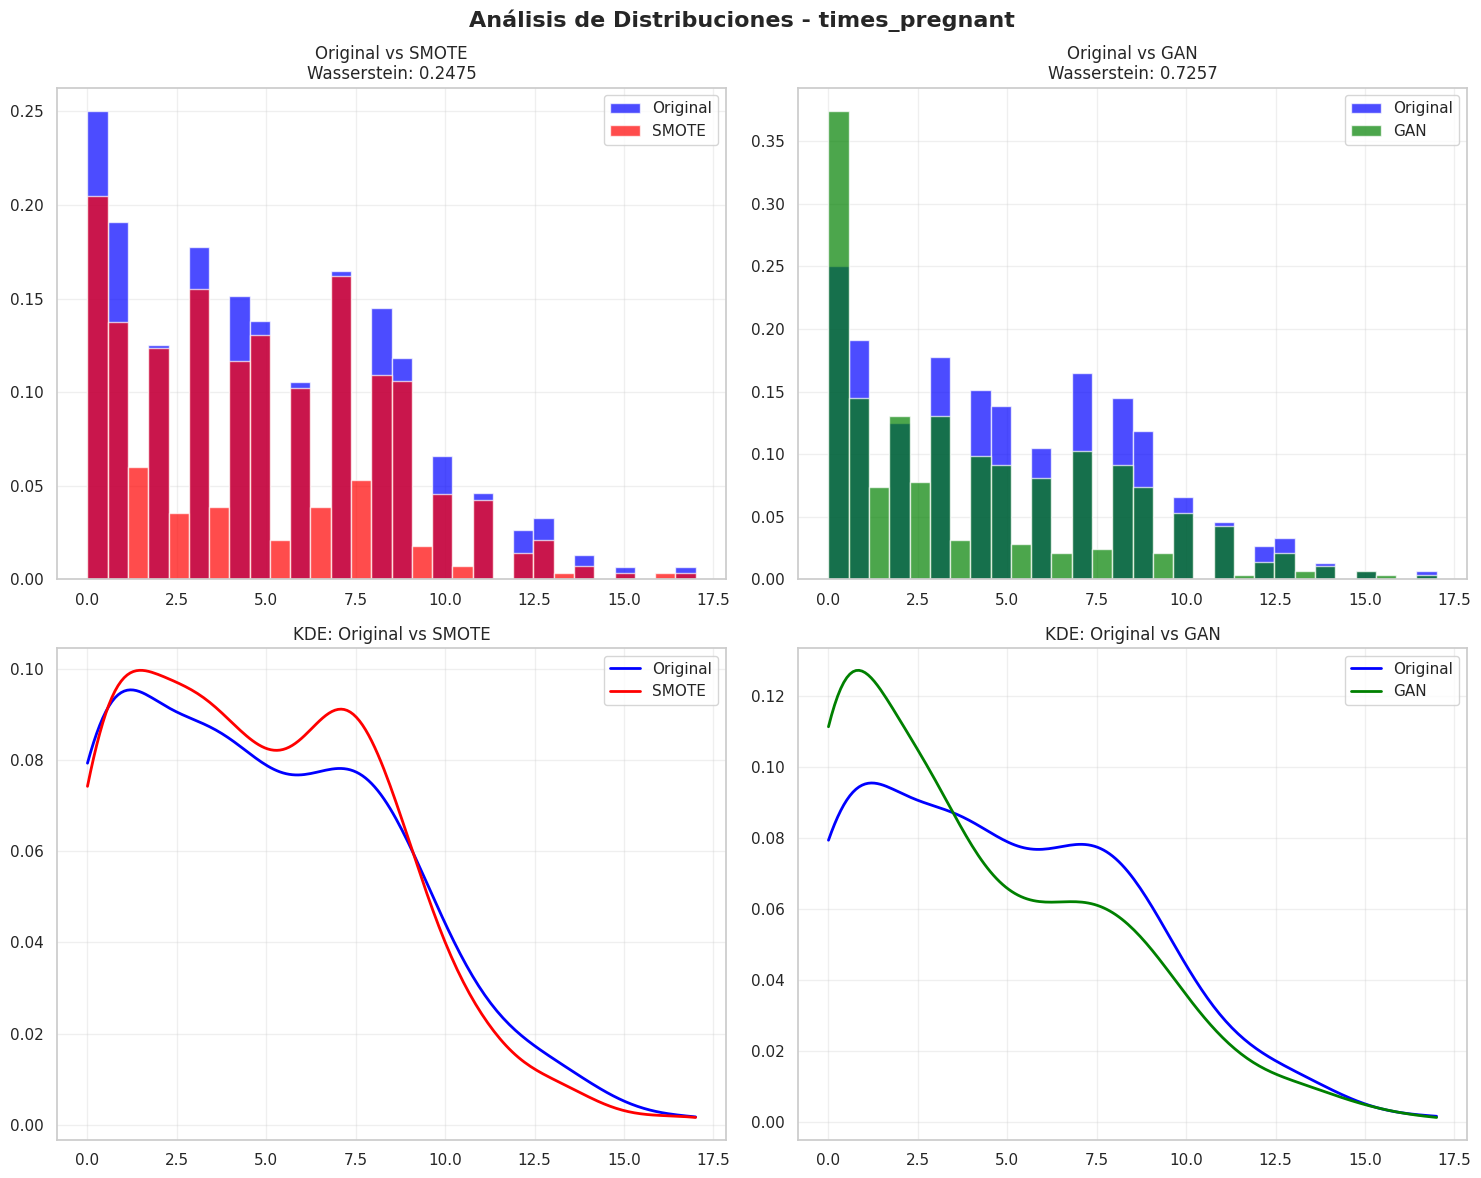

Creando gráficos para plasma_glucose...


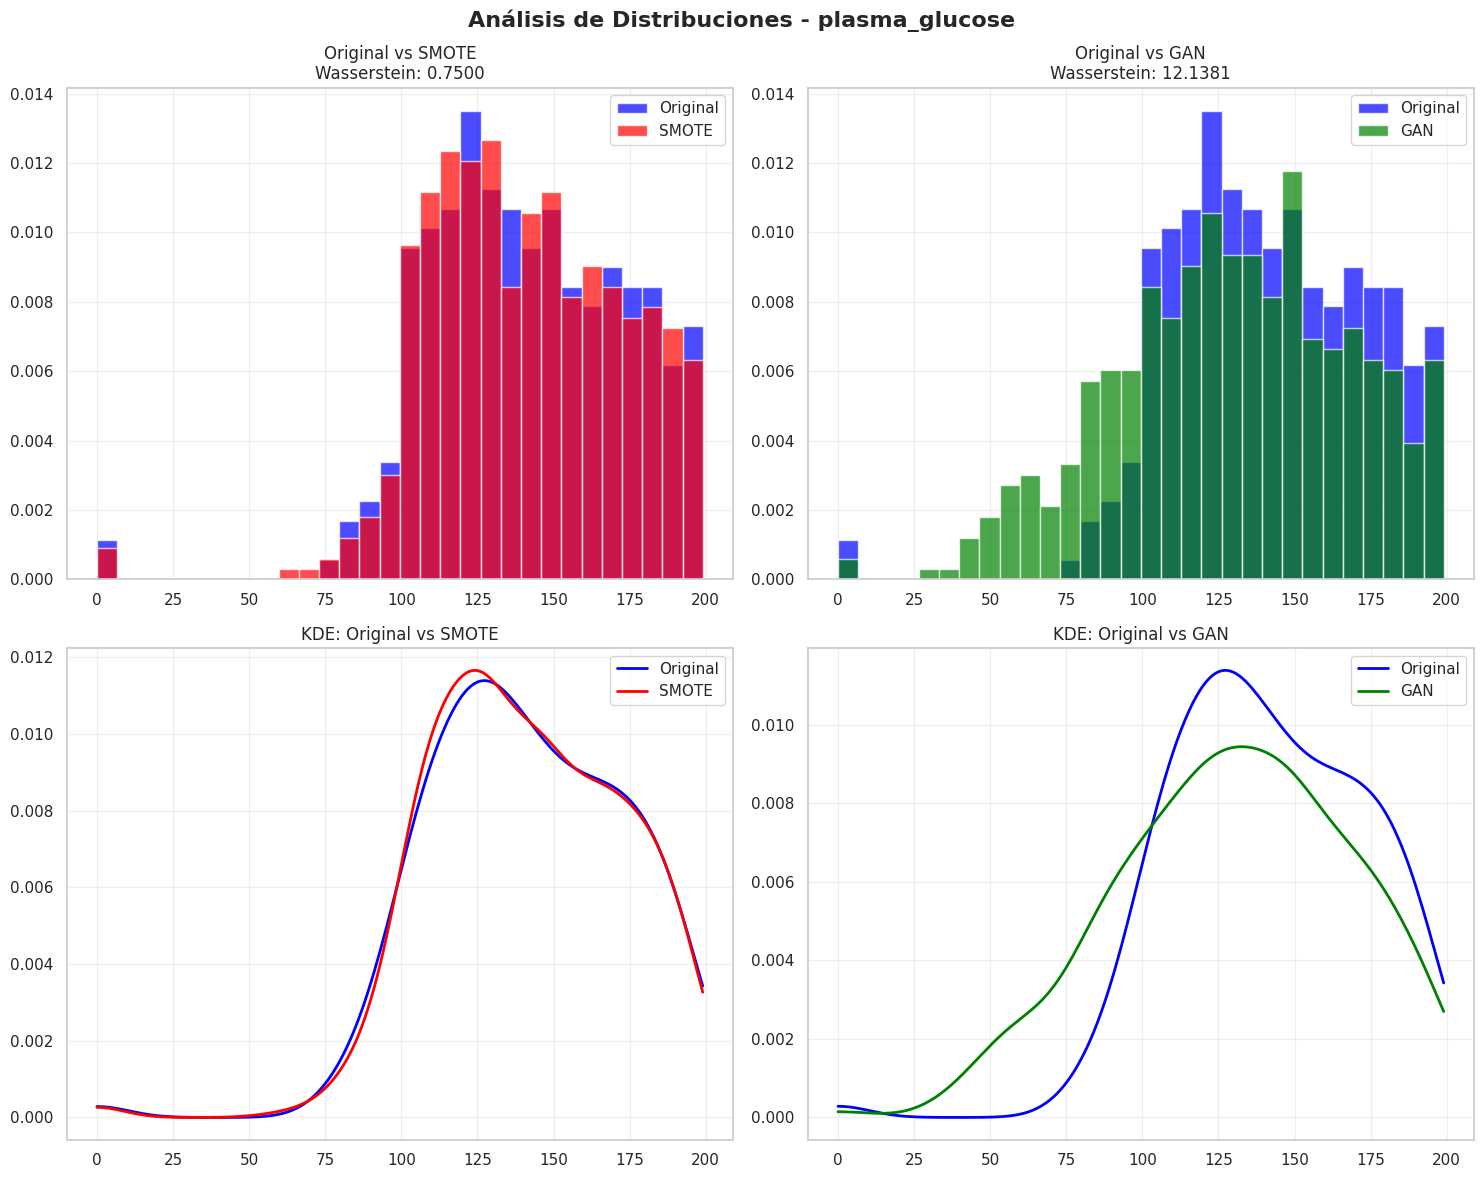

Creando gráficos para diastolic...


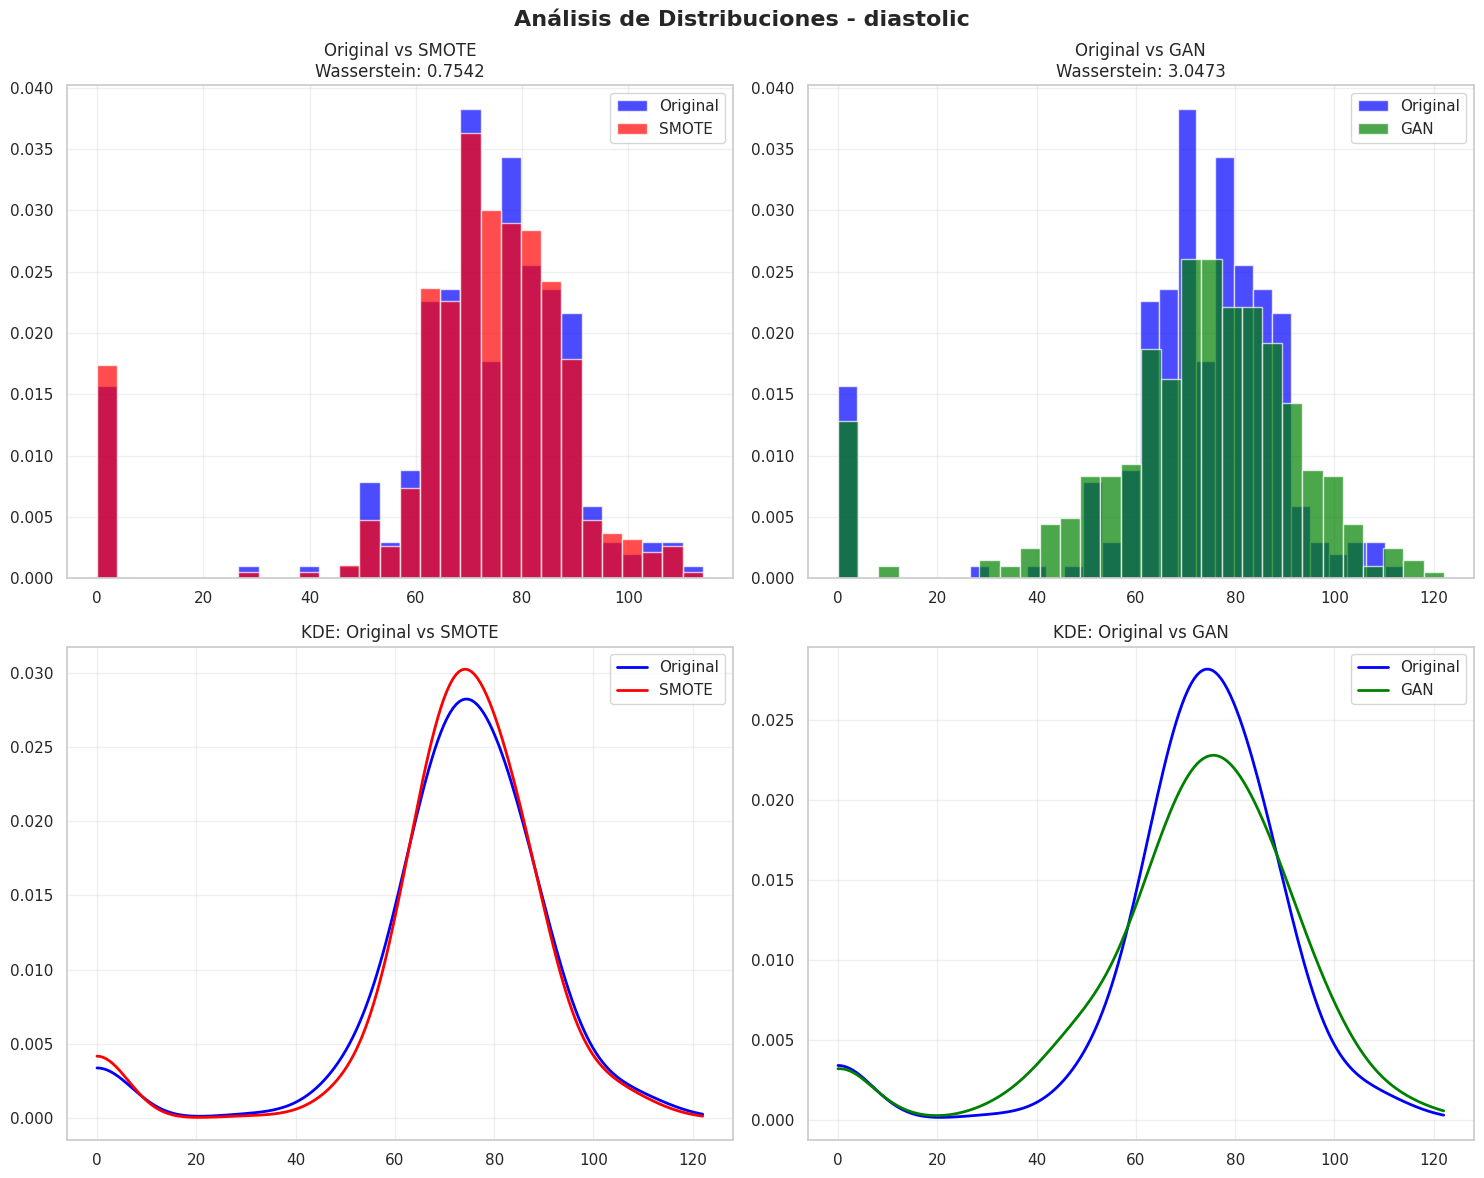

Creando gráficos para skin_thickness...


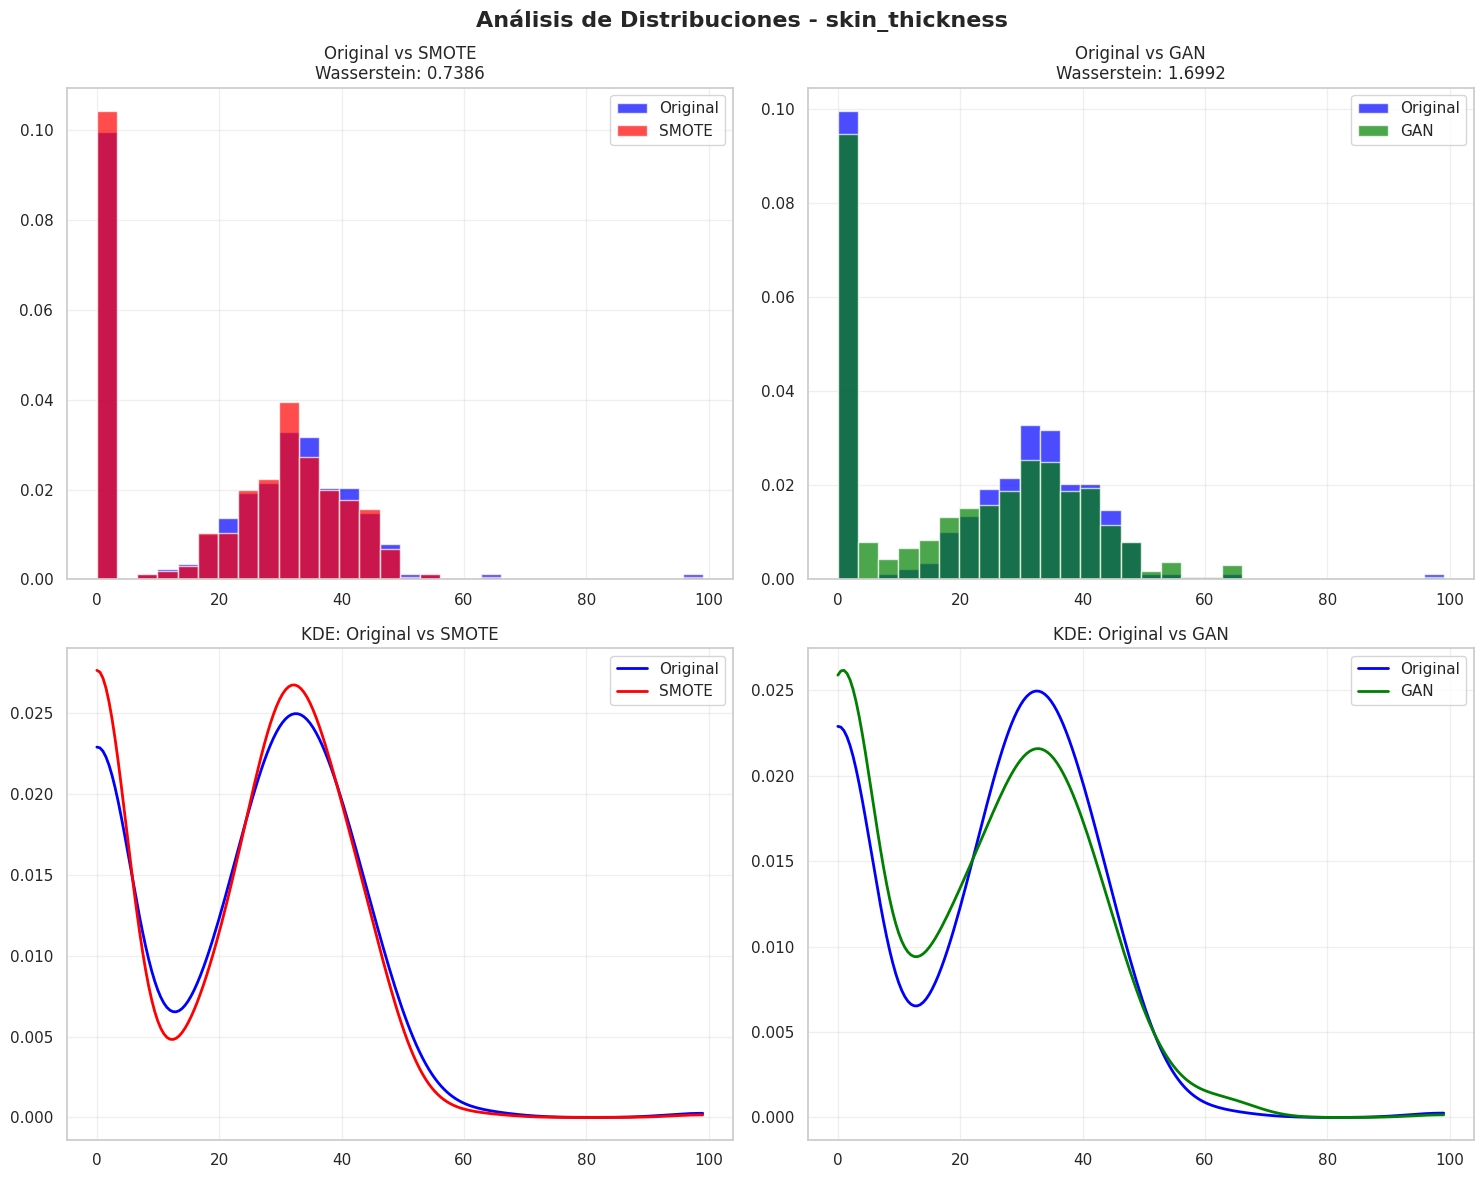

Creando gráficos para serum_insulin...


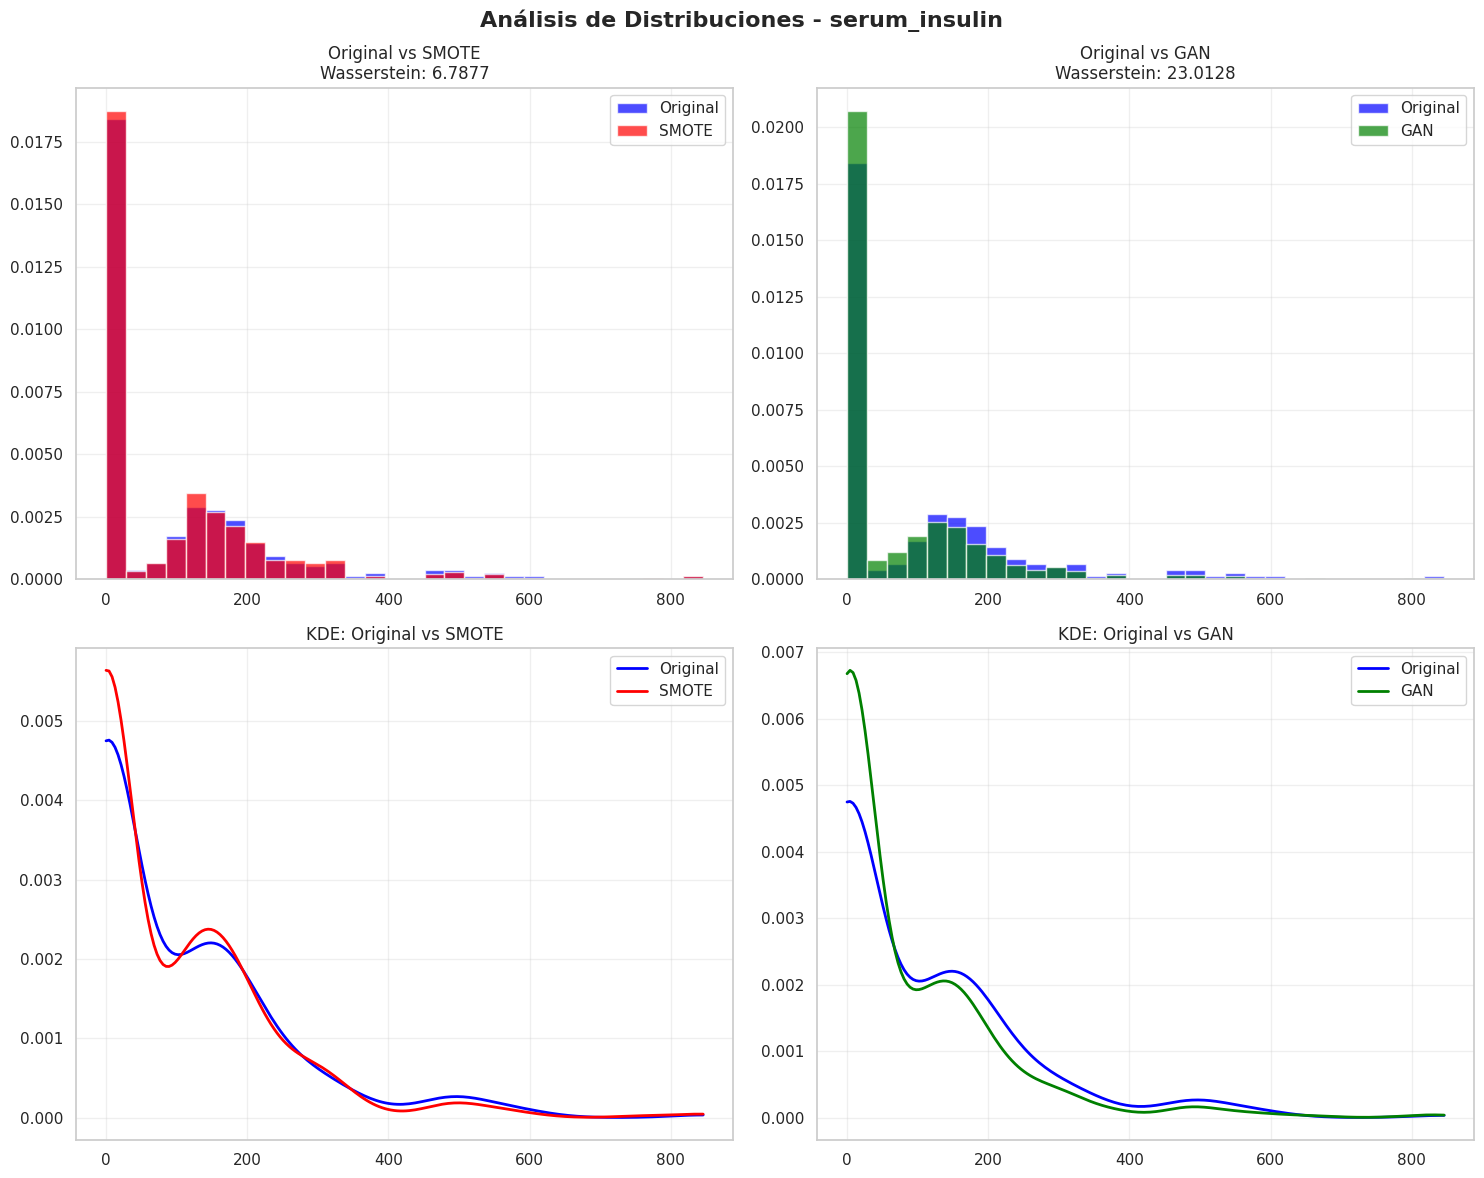

Creando gráficos para bmi...


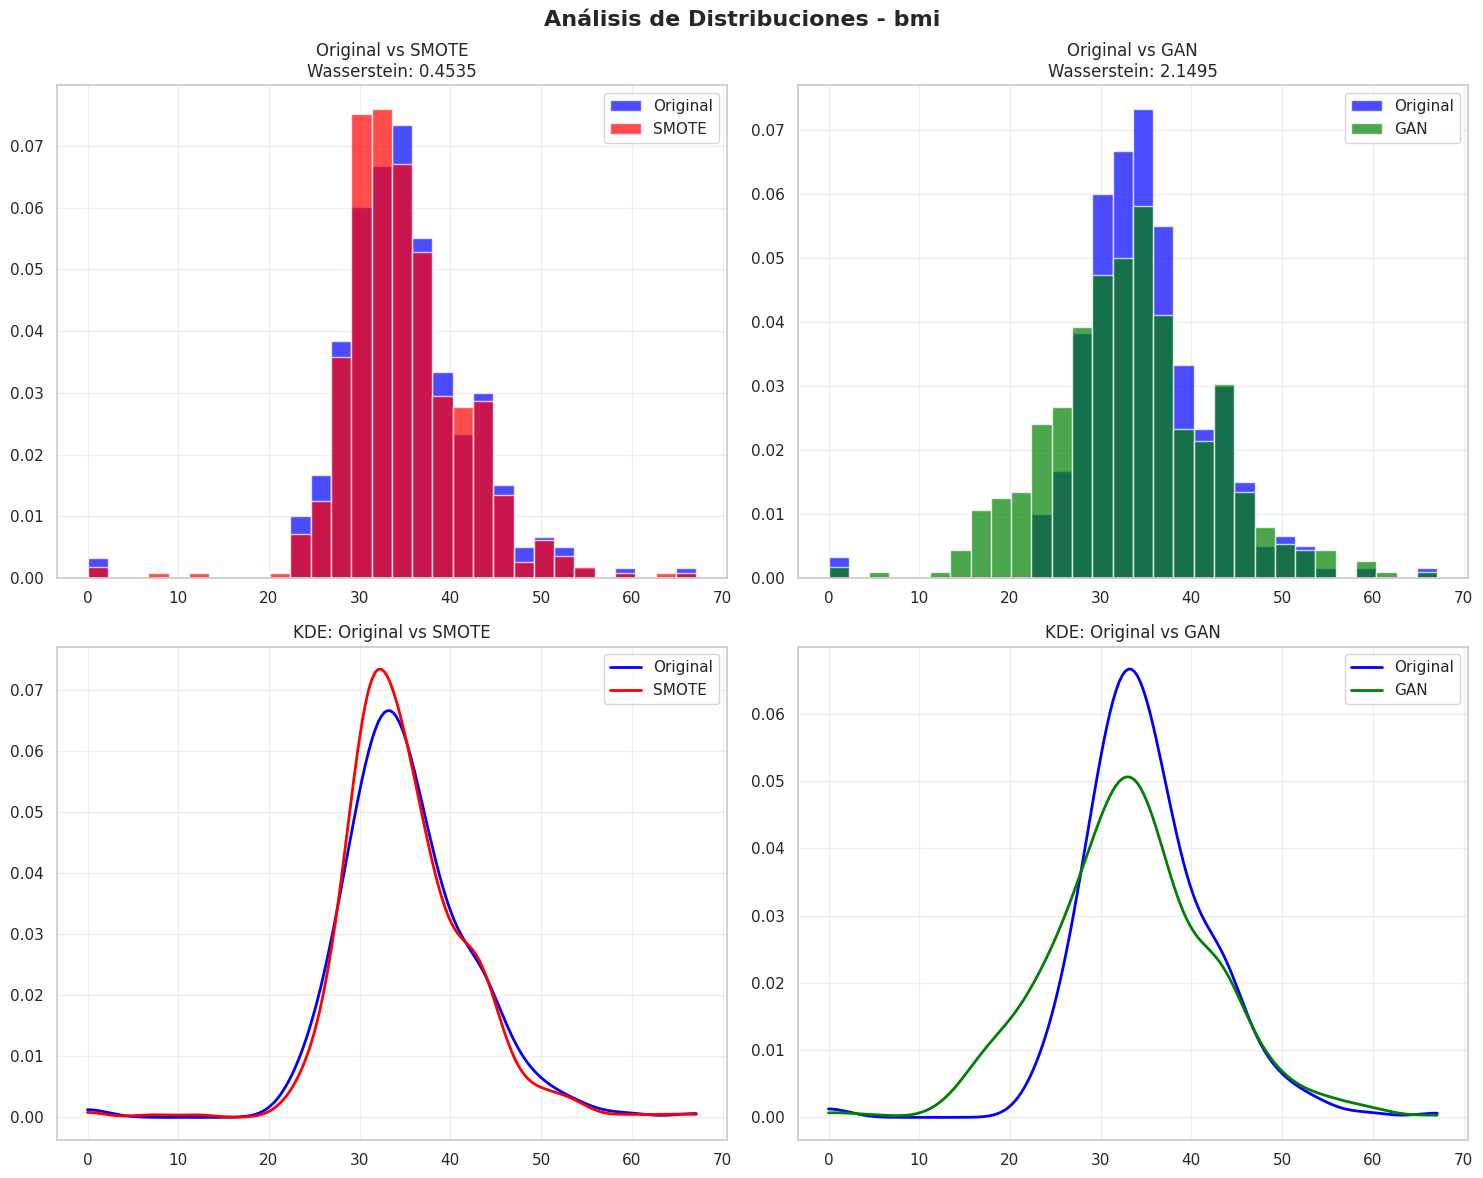

Creando gráficos para diabetes_pedigree...


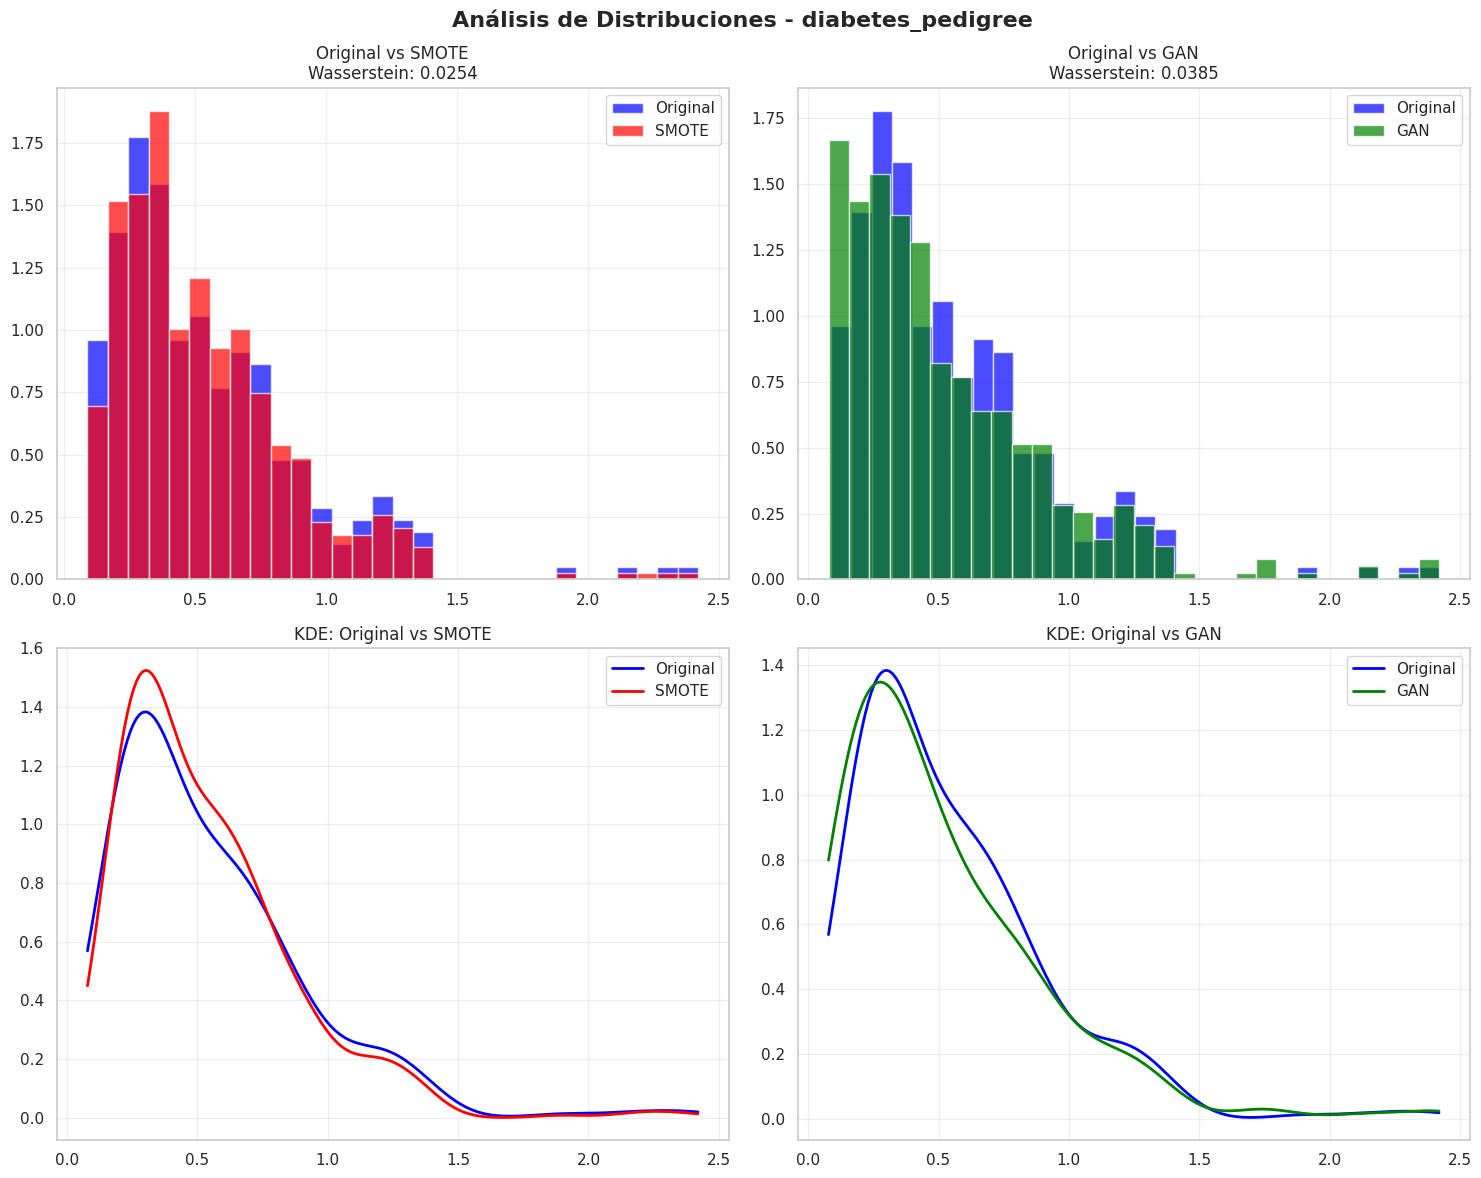

Creando gráficos para age...


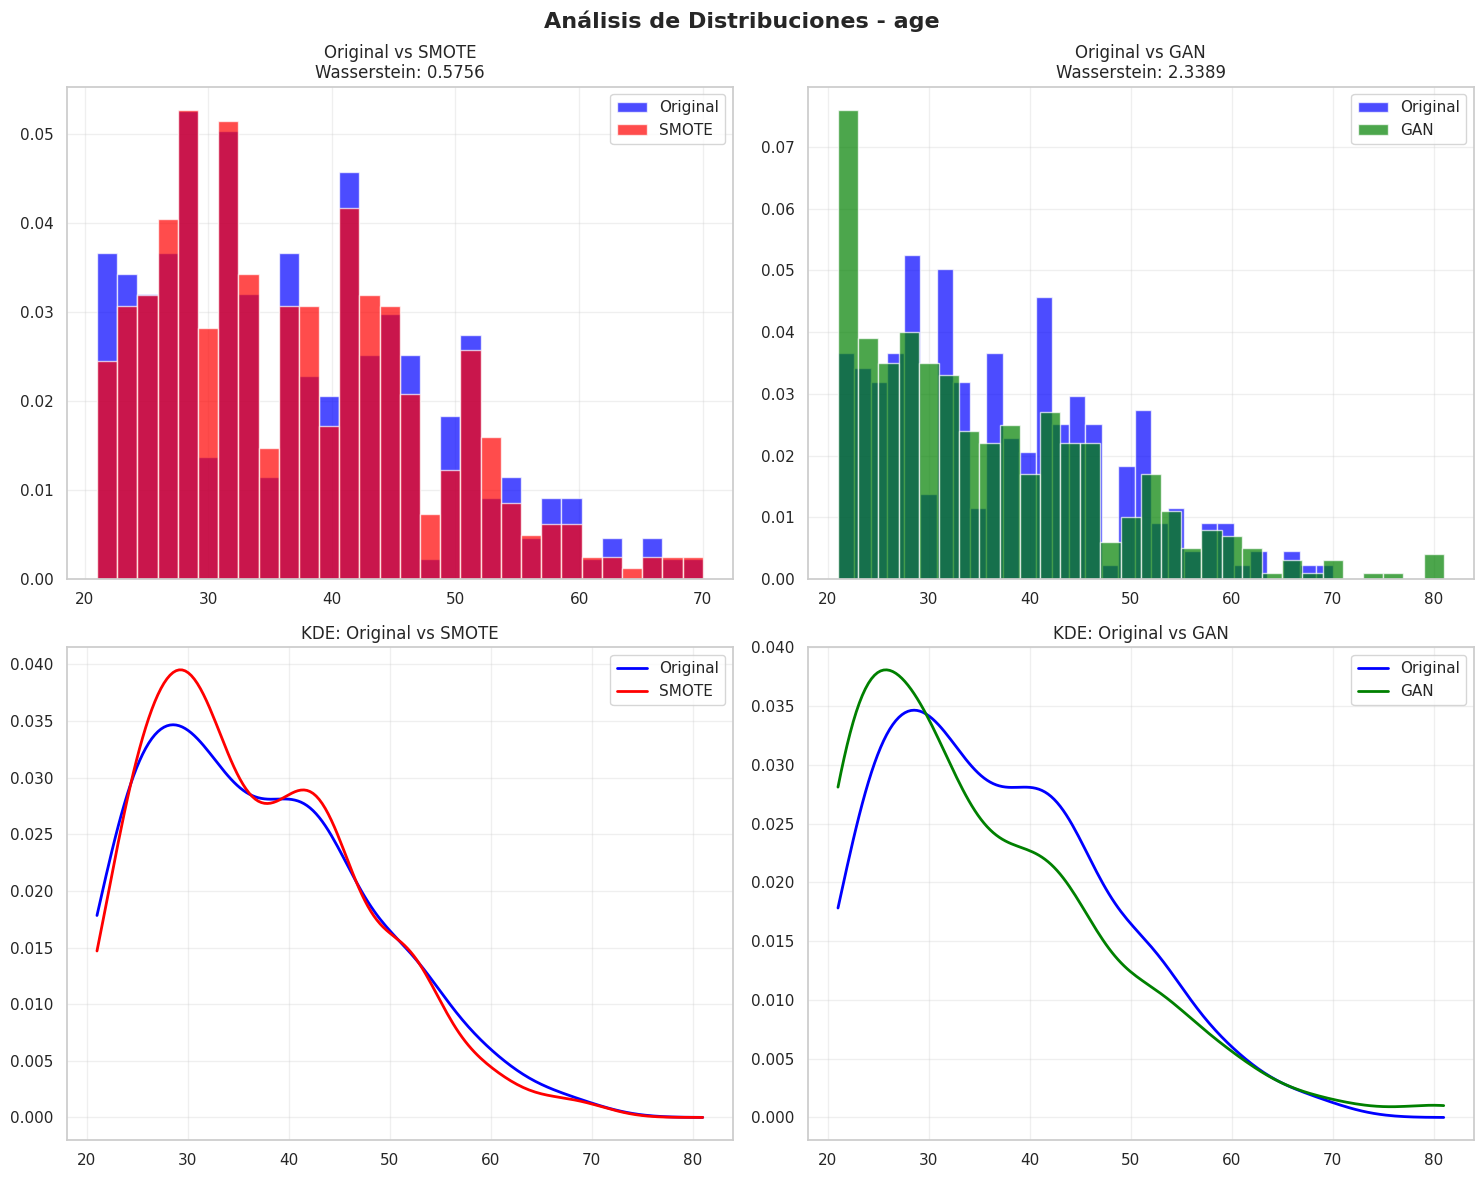


=== RESUMEN PARA ESCRITURA ACADÉMICA ===
Basado en los resultados obtenidos, puedes escribir algo como:

'Since the Wasserstein metric measures the "distance" between two probability
distributions, the smaller the value, the closer the two distributions are to each other
regarding their mass distribution. For example, consider the [FEATURE_NAME] element,
which has a value of [VALUE] in the comparison; if we compare it to the distribution
plots, we can see how the histograms of the original and the generated data have
similar shapes and support or have similar mass concentration in different regions.
This indicates that the two distributions are similar in shape and support.
In this case, only a small amount of work is required to transform one distribution
into the other, resulting in a small distance value.'

On the other hand, a large value of the Wasserstein metric indicates that the two
distributions are significantly different and require a large amount of work to be
transformed 

In [ ]:
#@title Visualizar distribuciones y crear gráficos comparativos
print("=== VISUALIZACIÓN DE DISTRIBUCIONES ===")
print("Creando gráficos comparativos para análisis visual")
print()

# Crear directorio para guardar imágenes
if not os.path.exists('img/distribution_analysis/'):
    os.makedirs('img/distribution_analysis/', exist_ok=True)

# Función para crear gráficos comparativos
def plot_distribution_comparison(original_data, smote_data, gan_data, feature_name, wasserstein_smote, wasserstein_gan):
    """
    Crea gráficos comparativos de distribuciones
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis de Distribuciones - {feature_name}', fontsize=16, fontweight='bold')

    # 1. Histogramas superpuestos
    axes[0, 0].hist(original_data, bins=30, alpha=0.7, label='Original', color='blue', density=True)
    axes[0, 0].hist(smote_data, bins=30, alpha=0.7, label='SMOTE', color='red', density=True)
    axes[0, 0].set_title(f'Original vs SMOTE\nWasserstein: {wasserstein_smote:.4f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(original_data, bins=30, alpha=0.7, label='Original', color='blue', density=True)
    axes[0, 1].hist(gan_data, bins=30, alpha=0.7, label='GAN', color='green', density=True)
    axes[0, 1].set_title(f'Original vs GAN\nWasserstein: {wasserstein_gan:.4f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 2. KDE plots
    from scipy.stats import gaussian_kde

    # KDE para datos originales
    kde_orig = gaussian_kde(original_data)
    kde_smote = gaussian_kde(smote_data)
    kde_gan = gaussian_kde(gan_data)

    x_range = np.linspace(min(original_data.min(), smote_data.min(), gan_data.min()),
                         max(original_data.max(), smote_data.max(), gan_data.max()), 200)

    axes[1, 0].plot(x_range, kde_orig(x_range), label='Original', color='blue', linewidth=2)
    axes[1, 0].plot(x_range, kde_smote(x_range), label='SMOTE', color='red', linewidth=2)
    axes[1, 0].set_title('KDE: Original vs SMOTE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(x_range, kde_orig(x_range), label='Original', color='blue', linewidth=2)
    axes[1, 1].plot(x_range, kde_gan(x_range), label='GAN', color='green', linewidth=2)
    axes[1, 1].set_title('KDE: Original vs GAN')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Guardar imagen
    plt.savefig(f'img/distribution_analysis/{feature_name}_distribution_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Crear gráficos para cada característica
for feature in pima_smote_results.keys():
    print(f"Creando gráficos para {feature}...")

    # Obtener datos
    orig_data = df_pima[df_pima['CLASS'] == 1][feature].values
    smote_data = df_pima_s[df_pima_s['CLASS'] == 1][feature].values
    gan_data = df_pima_g[df_pima_g['CLASS'] == 1][feature].values

    # Obtener métricas Wasserstein
    wasserstein_smote = pima_smote_results[feature]['wasserstein_distance']
    wasserstein_gan = pima_gan_results[feature]['wasserstein_distance']

    # Crear gráfico
    plot_distribution_comparison(orig_data, smote_data, gan_data, feature,
                               wasserstein_smote, wasserstein_gan)

print("\n=== RESUMEN PARA ESCRITURA ACADÉMICA ===")
print("Basado en los resultados obtenidos, puedes escribir algo como:")
print()
print("'Since the Wasserstein metric measures the \"distance\" between two probability")
print("distributions, the smaller the value, the closer the two distributions are to each other")
print("regarding their mass distribution. For example, consider the [FEATURE_NAME] element,")
print("which has a value of [VALUE] in the comparison; if we compare it to the distribution")
print("plots, we can see how the histograms of the original and the generated data have")
print("similar shapes and support or have similar mass concentration in different regions.")
print("This indicates that the two distributions are similar in shape and support.")
print("In this case, only a small amount of work is required to transform one distribution")
print("into the other, resulting in a small distance value.'")
print()
print("On the other hand, a large value of the Wasserstein metric indicates that the two")
print("distributions are significantly different and require a large amount of work to be")
print("transformed into each other.")
print()
print("Gráficos guardados en 'img/distribution_analysis/'")
print("Análisis de distribuciones completado")


time: 24 s (started: 2025-10-01 04:36:40 +00:00)


# --- A partir de aqui ya no hacer caso

In [ ]:
#@title Leer archivo ECOLI

df_ecoli = loadFile('https://raw.githubusercontent.com/elMaxPain/files/master/SMOTE_v_GAN/ecoli.arff', 'ecoli.arff')

#previsualizar
print(df_ecoli.head())
print('=====================')
print(df_ecoli.info())
print('=====================')
print(isOk(df_ecoli))
print('=====================')
df_ecoli.describe()

Download file... ecoli.arff ...
File downloaded
File loaded
    mcg   gvh   lip  chg   aac  alm1  alm2  CLASS
0  0.49  0.29  0.48  0.5  0.56  0.24  0.35      0
1  0.07  0.40  0.48  0.5  0.54  0.35  0.44      0
2  0.56  0.40  0.48  0.5  0.49  0.37  0.46      0
3  0.59  0.49  0.48  0.5  0.52  0.45  0.36      0
4  0.23  0.32  0.48  0.5  0.55  0.25  0.35      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     336 non-null    float64
 1   gvh     336 non-null    float64
 2   lip     336 non-null    float64
 3   chg     336 non-null    float64
 4   aac     336 non-null    float64
 5   alm1    336 non-null    float64
 6   alm2    336 non-null    float64
 7   CLASS   336 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 21.1 KB
None
Has null/nan values? False
Index has duplicates? False

Columns and data types:
mcg      float64
gvh      floa

mcg         gvh         lip         chg         aac        alm1  \
count  336.000000  336.000000  336.000000  336.000000  336.000000  336.000000   
mean     0.500060    0.500000    0.495476    0.501488    0.500030    0.500179   
std      0.194634    0.148157    0.088495    0.027277    0.122376    0.215751   
min      0.000000    0.160000    0.480000    0.500000    0.000000    0.030000   
25%      0.340000    0.400000    0.480000    0.500000    0.420000    0.330000   
50%      0.500000    0.470000    0.480000    0.500000    0.495000    0.455000   
75%      0.662500    0.570000    0.480000    0.500000    0.570000    0.710000   
max      0.890000    1.000000    1.000000    1.000000    0.880000    1.000000   

             alm2       CLASS  
count  336.000000  336.000000  
mean     0.499732    1.241071  
std      0.209411    1.442917  
min      0.000000    0.000000  
25%      0.350000    0.000000  
50%      0.430000    1.000000  
75%      0.710000    2.000000  
max      0.990000    7.000000

time: 159 ms (started: 2025-10-01 04:37:04 +00:00)


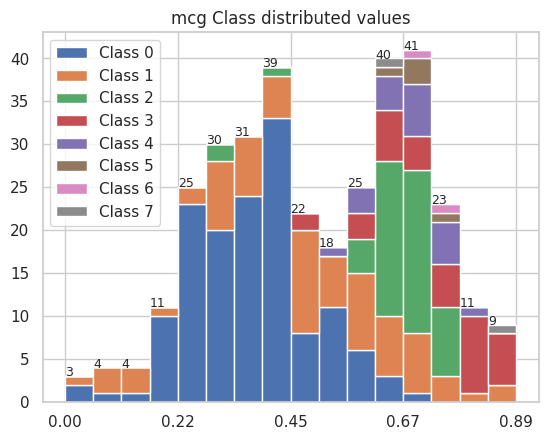

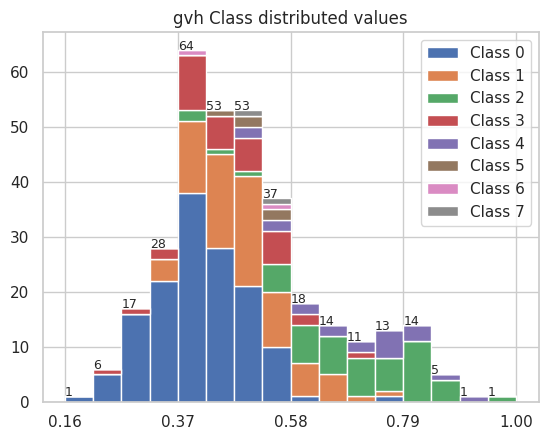

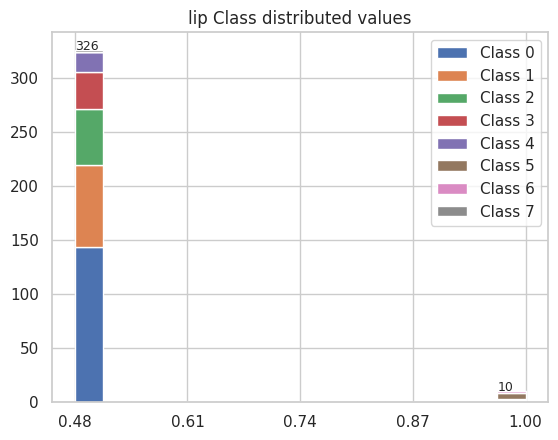

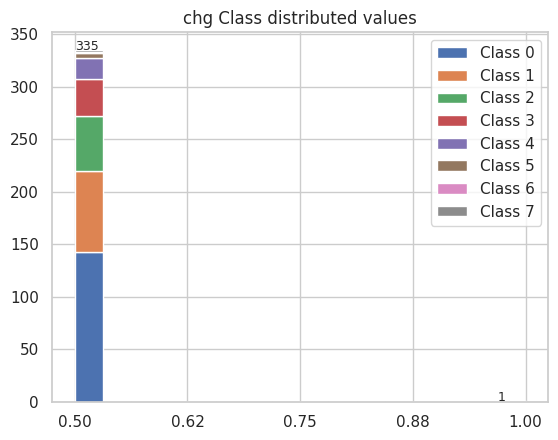

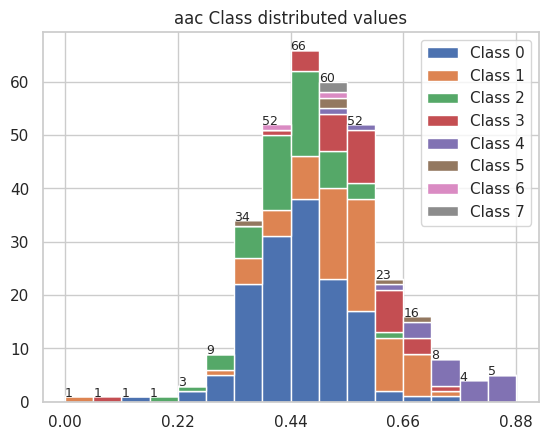

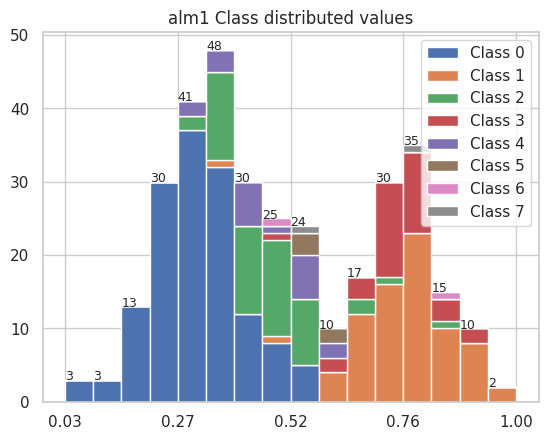

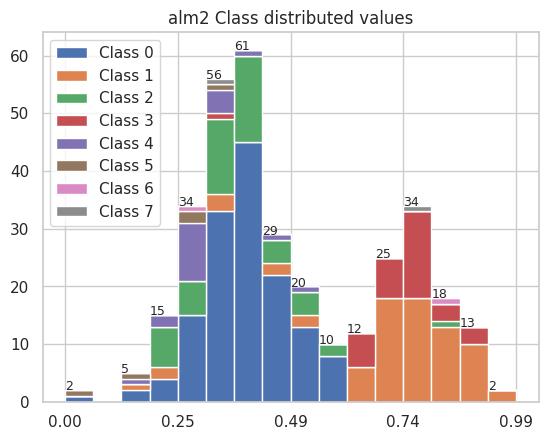

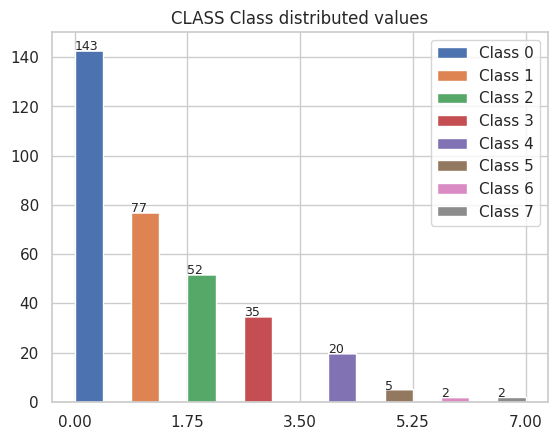

time: 5.82 s (started: 2025-10-01 04:37:04 +00:00)


In [ ]:
#@title Original ECOLI - Class distributed values

interesantes = df_ecoli.columns.values
for i in interesantes:
  plt.figure(facecolor='w')
  min_df = df_ecoli[i].min()
  max_df = df_ecoli[i].max()
  n, bins, _ = plt.hist([df_ecoli[df_ecoli['CLASS']==0][i], df_ecoli[df_ecoli['CLASS']==1][i], df_ecoli[df_ecoli['CLASS']==2][i], df_ecoli[df_ecoli['CLASS']==3][i], df_ecoli[df_ecoli['CLASS']==4][i], df_ecoli[df_ecoli['CLASS']==5][i], df_ecoli[df_ecoli['CLASS']==6][i], df_ecoli[df_ecoli['CLASS']==7][i]],
          bins = 16, stacked=True, label=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
  for j in range(len(bins)-1):
    if n[-1][j]:
      plt.text(bins[j], n[-1][j], str(int(n[-1][j])), fontsize=9)
  plt.xticks(np.linspace(min_df, max_df, num=5))
  plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title(f'{i} Class distributed values')
  plt.legend()
  if not os.path.exists('img/original/'):
    os.makedirs('img/original/', exist_ok=True)
  plt.savefig(''.join(['img/original/ECOLI_' ,i , '_class_distribution', '.png']), bbox_inches='tight')
  plt.show()
  plt.close()

del interesantes, min_df, max_df, n, bins, i, j

In [ ]:
df_ecoli.drop(df_ecoli[df_ecoli['CLASS'] == 5].index, inplace = True)
df_ecoli.drop(df_ecoli[df_ecoli['CLASS'] == 6].index, inplace = True)
df_ecoli.drop(df_ecoli[df_ecoli['CLASS'] == 7].index, inplace = True)

time: 8.51 ms (started: 2025-10-01 04:37:10 +00:00)


In [ ]:
df_ecoli.describe()

mcg         gvh         lip    chg         aac        alm1  \
count  327.000000  327.000000  327.000000  327.0  327.000000  327.000000   
mean     0.494190    0.499939    0.484771    0.5    0.499450    0.497462   
std      0.193719    0.149935    0.049654    0.0    0.123165    0.217333   
min      0.000000    0.160000    0.480000    0.5    0.000000    0.030000   
25%      0.340000    0.400000    0.480000    0.5    0.420000    0.330000   
50%      0.490000    0.470000    0.480000    0.5    0.490000    0.450000   
75%      0.655000    0.570000    0.480000    0.5    0.570000    0.710000   
max      0.890000    1.000000    1.000000    0.5    0.880000    1.000000   

             alm2       CLASS  
count  327.000000  327.000000  
mean     0.503119    1.119266  
std      0.206947    1.251194  
min      0.000000    0.000000  
25%      0.350000    0.000000  
50%      0.430000    1.000000  
75%      0.710000    2.000000  
max      0.990000    4.000000

time: 30.4 ms (started: 2025-10-01 04:37:10 +00:00)


In [ ]:
#@title ECOLI original NORM
reproducibilidad()

df_ecoli_n = pd.DataFrame(escalar(df_ecoli.drop('CLASS', axis=1).values, 1), columns=df_ecoli.columns[:-1]).copy(True)
df_ecoli_n.index = df_ecoli.index
df_ecoli_n['CLASS'] = df_ecoli['CLASS']
df_ecoli_n.head()

mcg       gvh  lip  chg       aac      alm1      alm2  CLASS
0  0.550562  0.154762  0.0  0.0  0.636364  0.216495  0.353535      0
1  0.078652  0.285714  0.0  0.0  0.613636  0.329897  0.444444      0
2  0.629213  0.285714  0.0  0.0  0.556818  0.350515  0.464646      0
3  0.662921  0.392857  0.0  0.0  0.590909  0.432990  0.363636      0
4  0.258427  0.190476  0.0  0.0  0.625000  0.226804  0.353535      0

time: 26.3 ms (started: 2025-10-01 04:37:10 +00:00)


In [ ]:
#@title MLP a ECOLI original norm
reproducibilidad()

hidden_layer_sizes = int((df_ecoli_n.drop('CLASS', axis=1).values.shape[1] + len(np.unique(df_ecoli_n['CLASS'].values))) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='logistic', solver='lbfgs',
                  batch_size='auto', learning_rate='adaptive', learning_rate_init=0.03, max_iter=100,
                  random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

X_train, X_test, Y_train, Y_test = train_test_split(df_ecoli_n.drop('CLASS', axis=1).values, df_ecoli_n['CLASS'].values, test_size=0.33, random_state=np.random.get_state()[1][0])

Y_pred = fit_predict(mlp, X_train, Y_train, X_test, Y_test)

print(mlp.score(df_ecoli_n.drop('CLASS', axis=1).values, df_ecoli_n['CLASS'].values, sample_weight=None))
print()
print()

Accuracy: 78.70 %

Confussion matrix
[[42  4  1  0  2]
 [ 1 20  0  1  0]
 [ 1  4 10  1  2]
 [ 0  6  0  7  0]
 [ 0  0  0  0  6]]
0.8623853211009175


time: 74.5 ms (started: 2025-10-01 04:37:10 +00:00)


In [ ]:
#@title MLP a ECOLI DROP norm
reproducibilidad()

hidden_layer_sizes = int((df_ecoli_n.drop('CLASS', axis=1).values.shape[1] + len(np.unique(df_ecoli_n['CLASS'].values))) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='logistic', solver='lbfgs',
                  batch_size='auto', learning_rate='adaptive', learning_rate_init=0.03, max_iter=100,
                  random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

X_train, X_test, Y_train, Y_test = train_test_split(df_ecoli_n.drop('CLASS', axis=1).values, df_ecoli_n['CLASS'].values, test_size=0.33, random_state=np.random.get_state()[1][0])

Y_pred = fit_predict(mlp, X_train, Y_train, X_test, Y_test)

print(mlp.score(df_ecoli_n.drop('CLASS', axis=1).values, df_ecoli_n['CLASS'].values, sample_weight=None))
print()
print()

Accuracy: 78.70 %

Confussion matrix
[[42  4  1  0  2]
 [ 1 20  0  1  0]
 [ 1  4 10  1  2]
 [ 0  6  0  7  0]
 [ 0  0  0  0  6]]
0.8623853211009175


time: 75.6 ms (started: 2025-10-01 04:37:10 +00:00)


ECOLI Base norm	acc=82.8598% (+/- 0.1383)


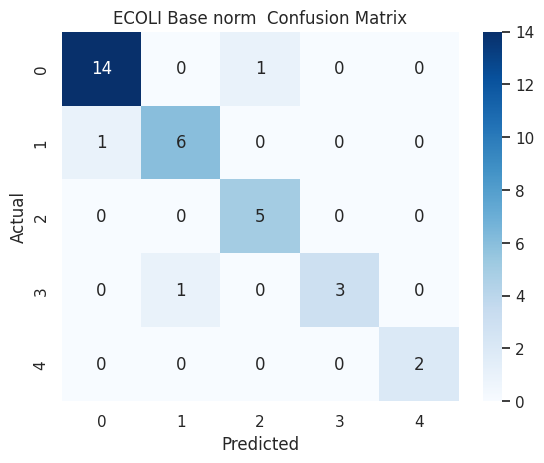

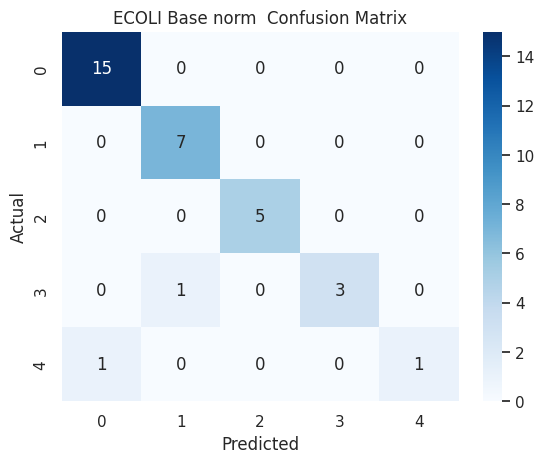

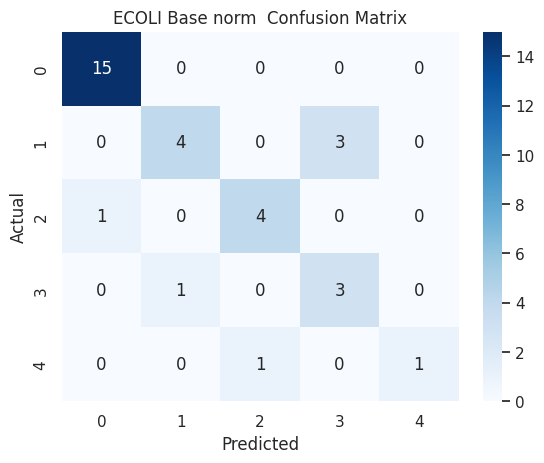

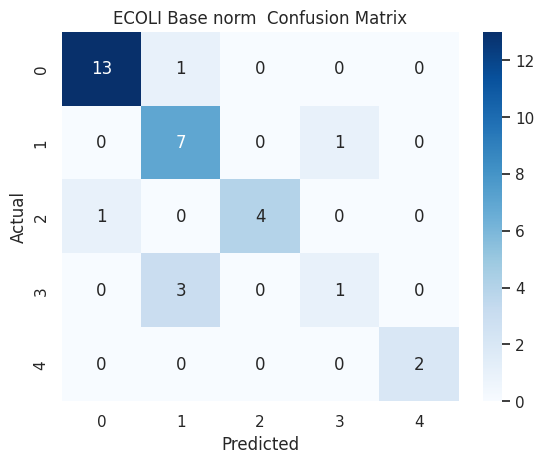

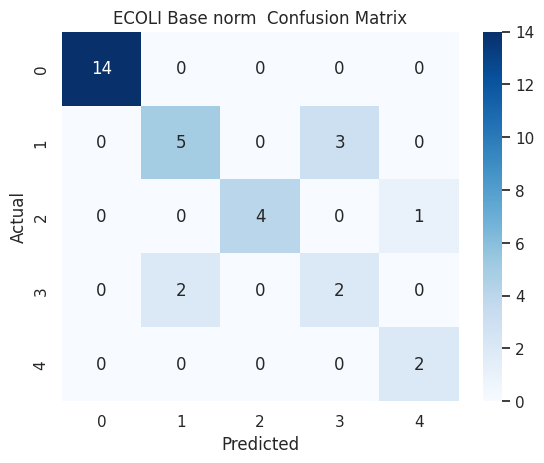

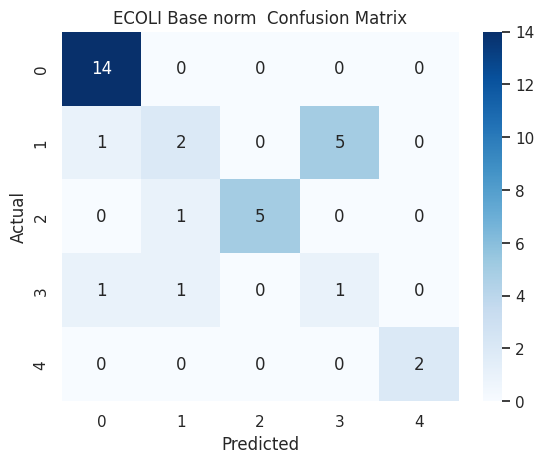

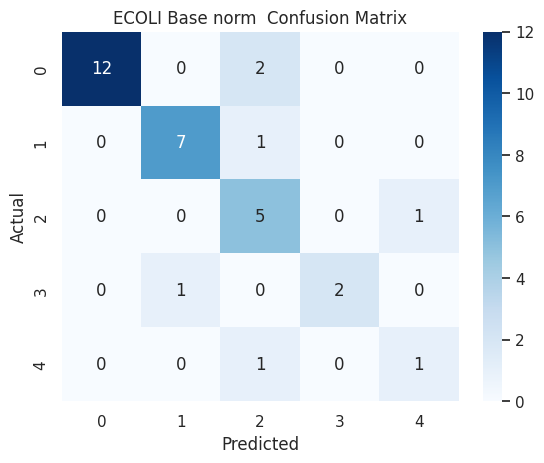

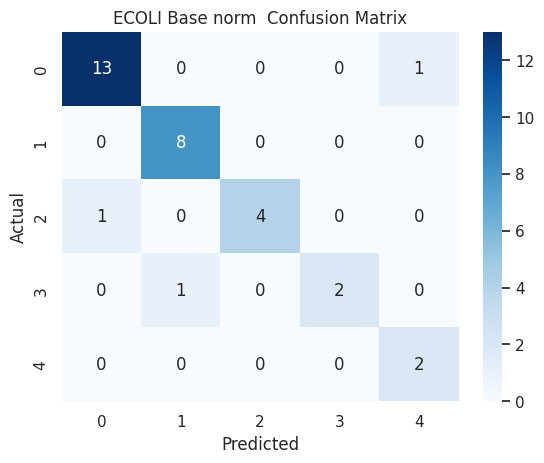

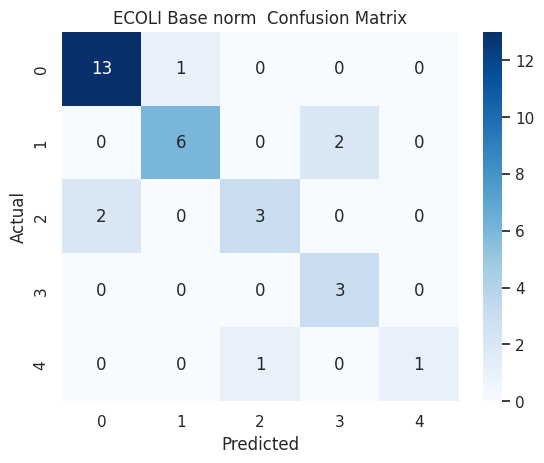

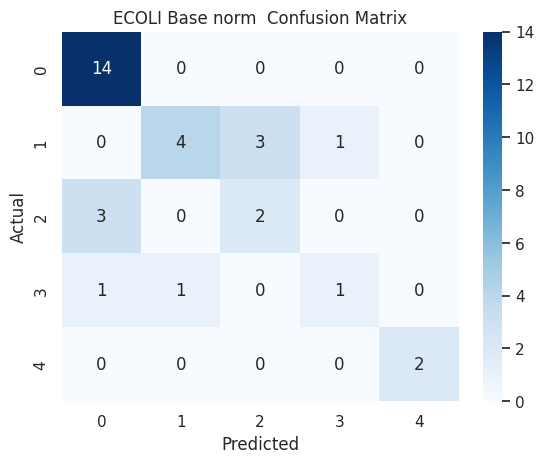

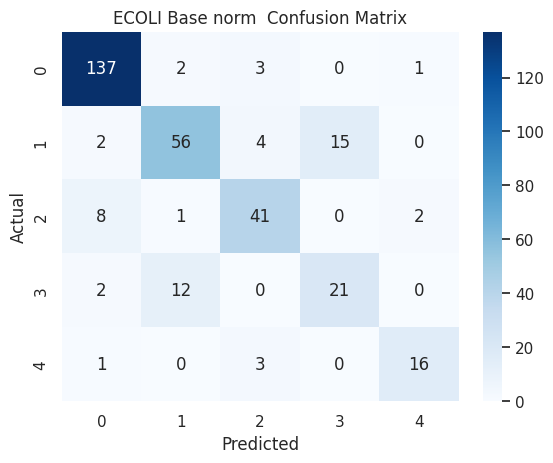



[0.90909091 0.93939394 0.81818182 0.81818182 0.81818182 0.72727273
 0.81818182 0.90625    0.8125     0.71875   ]


time: 7.68 s (started: 2025-10-01 04:37:10 +00:00)


In [ ]:
#@title CrossVal a ECOLI original norm
#from sklearn.metrics import zero_one_loss
reproducibilidad()

ecoli = valCruzada('ECOLI Base norm', df_ecoli_n.drop('CLASS', axis=1).values, df_ecoli_n['CLASS'].values)#, 'Original')
print(ecoli['test_accuracy'])
print()
print()

del ecoli

In [ ]:
df_ecoli.drop('chg', axis = 1, inplace = True)
df_ecoli.drop('lip', axis = 1, inplace = True)

time: 4.25 ms (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title Aplicar SMOTE a ECOLI

reproducibilidad()

#from imblearn.over_sampling import BorderlineSMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline
oversample = SMOTE(sampling_strategy='auto', random_state=1211, k_neighbors=1)#, n_jobs=-1)
X, y = oversample.fit_resample(df_ecoli.drop('CLASS', axis=1), df_ecoli.CLASS)
X['CLASS'] = y
df_ecoli_s = X.copy(True)

# define pipeline
#over = SMOTE(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)
# transform the dataset
#X, y = pipeline.fit_resample(X, y)

print('SMOTE:')
print(df_ecoli_s.CLASS.value_counts())

SMOTE:
CLASS
0    143
1    143
3    143
4    143
2    143
Name: count, dtype: int64
time: 17.2 ms (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title Escalar datos SMOTE
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
df_ecoli_s_n = pd.DataFrame(escalar(df_ecoli_s.drop('CLASS', axis=1).values, 1), columns=df_ecoli_s.columns[:-1]).copy(True)
df_ecoli_s_n.index = df_ecoli_s.index
df_ecoli_s_n['CLASS']=df_ecoli_s['CLASS']
df_ecoli_s_n

mcg       gvh       aac      alm1      alm2  CLASS
0    0.550562  0.154762  0.636364  0.216495  0.353535      0
1    0.078652  0.285714  0.613636  0.329897  0.444444      0
2    0.629213  0.285714  0.556818  0.350515  0.464646      0
3    0.662921  0.392857  0.590909  0.432990  0.363636      0
4    0.258427  0.190476  0.625000  0.226804  0.353535      0
..        ...       ...       ...       ...       ...    ...
710  0.596663  0.731132  0.833850  0.355139  0.403337      4
711  0.750628  0.576582  0.807835  0.383905  0.298206      4
712  0.762898  0.560982  0.827689  0.381654  0.302618      4
713  0.837595  0.735905  0.950921  0.559041  0.300737      4
714  0.623964  0.637122  0.868364  0.342614  0.446288      4

[715 rows x 6 columns]

time: 24.2 ms (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title Limpiar variables

del X, oversample, y

time: 663 µs (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title MLP a ECOLI original
#from sklearn.metrics import zero_one_loss
reproducibilidad()

X = df_ecoli.drop('CLASS', axis=1).values
y = df_ecoli['CLASS'].values

# train_test_split: Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# check how many sample we have
print("Train samples, test samples")
print(X_train.shape[0], X_test.shape[0])
print()

reproducibilidad()
# create mlp classifier df_ecoli_i_s
hidden_layer_sizes = int((df_ecoli.shape[1]-1 + len(df_ecoli.CLASS.unique())) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd',
                    batch_size=100, learning_rate='constant', learning_rate_init=0.03, max_iter=500,
                    random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

Y_pred = fit_predict(mlp, X_train, y_train, X_test, y_test)


# train the model
#mlp.fit(X_train, y_train)

# predict labels for test samples
#y_pred = mlp.predict(X_test)

#print('Accuracy: {:.2f} %\n\nConfussion matrix'.format(accuracy_score(y_test, y_pred)*100))
#print(confusion_matrix(y_test, y_pred))


Train samples, test samples
228 99

Accuracy: 51.52 %

Confussion matrix
[[30 13  0  0  0]
 [ 1 21  1  0  0]
 [14  2  0  0  0]
 [ 0 11  0  0  0]
 [ 6  0  0  0  0]]
time: 32.2 ms (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title Limpiar variables

del X, y, X_train, X_test, y_train, y_test, hidden_layer_sizes, mlp, Y_pred

time: 683 µs (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title MLP a ECOLI SMOTE
#from sklearn.metrics import zero_one_loss
reproducibilidad()

X = df_ecoli_s.drop('CLASS', axis=1).values
y = df_ecoli_s['CLASS'].values

# train_test_split: Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# check how many sample we have
print("Train samples, test samples")
print(X_train.shape[0], X_test.shape[0])
print()

reproducibilidad()
# create mlp classifier df_ecoli_s
hidden_layer_sizes = int((df_ecoli.shape[1]-1 + len(df_ecoli.CLASS.unique())) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd',
                    batch_size=100, learning_rate='constant', learning_rate_init=0.03, max_iter=500,
                    random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

Y_pred = fit_predict(mlp, X_train, y_train, X_test, y_test)

Train samples, test samples
500 215

Accuracy: 52.09 %

Confussion matrix
[[ 0 13 16  2 12]
 [ 0 35  1  7  0]
 [ 0  1  1  4 37]
 [ 0  9  0 34  0]
 [ 0  0  1  0 42]]
time: 114 ms (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title Limpiar variables

del X, y, X_train, X_test, y_train, y_test, hidden_layer_sizes, mlp, Y_pred

time: 675 µs (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title MLP a ECOLI SMOTE normalizado
#from sklearn.metrics import zero_one_loss
reproducibilidad()

X = df_ecoli_s_n.drop('CLASS', axis=1).values
y = df_ecoli_s_n['CLASS'].values

# train_test_split: Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# check how many sample we have
print("Train samples, test samples")
print(X_train.shape[0], X_test.shape[0])
print()

reproducibilidad()
# create mlp classifier df_ecoli_s
hidden_layer_sizes = int((df_ecoli.shape[1]-1 + len(df_ecoli.CLASS.unique())) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd',
                    batch_size=100, learning_rate='constant', learning_rate_init=0.03, max_iter=500,
                    random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

Y_pred = fit_predict(mlp, X_train, y_train, X_test, y_test)

Train samples, test samples
500 215

Accuracy: 53.49 %

Confussion matrix
[[ 0 16 11  4 12]
 [ 0 34  0  9  0]
 [ 0  1  1  4 37]
 [ 0  6  0 37  0]
 [ 0  0  0  0 43]]
time: 129 ms (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title Limpiar variables

del X, y, X_train, X_test, y_train, y_test, hidden_layer_sizes, mlp, Y_pred

time: 473 µs (started: 2025-10-01 04:37:18 +00:00)


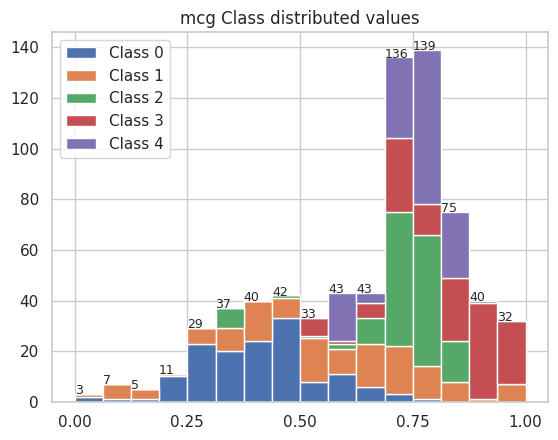

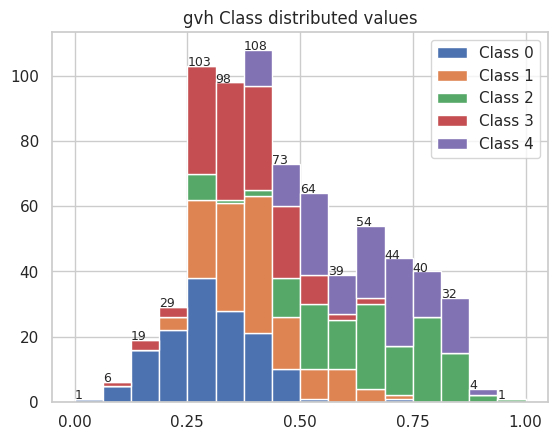

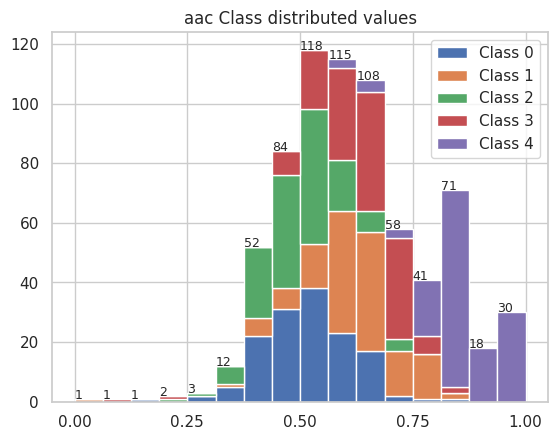

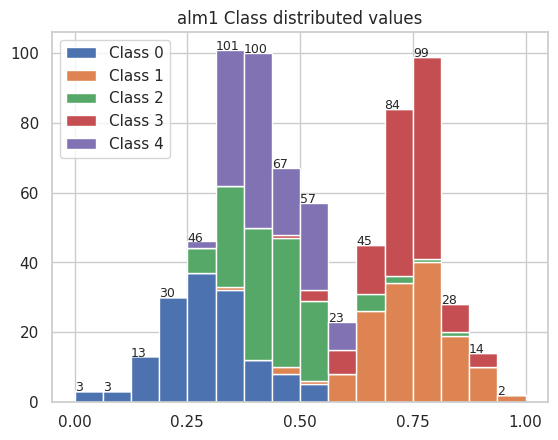

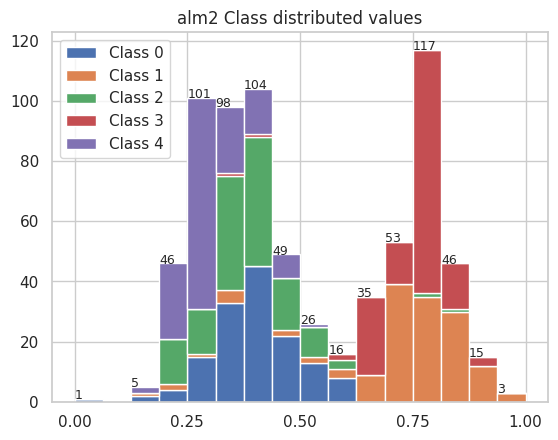

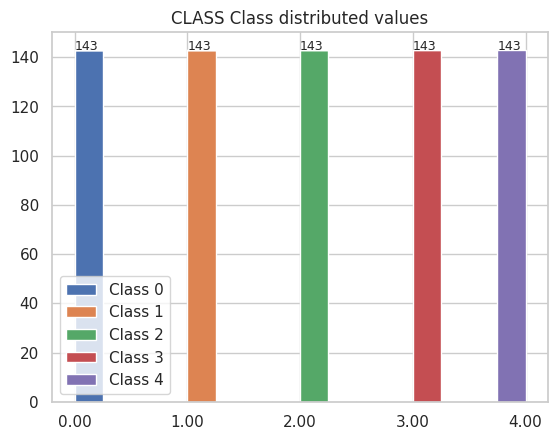

time: 3.85 s (started: 2025-10-01 04:37:18 +00:00)


In [ ]:
#@title S_N ECOLI - Class distributed values

interesantes = df_ecoli_s_n.columns.values
for i in interesantes:
  plt.figure(facecolor='w')
  min_df = df_ecoli_s_n[i].min()
  max_df = df_ecoli_s_n[i].max()
  n, bins, _ = plt.hist([df_ecoli_s_n[df_ecoli_s_n['CLASS']==0][i], df_ecoli_s_n[df_ecoli_s_n['CLASS']==1][i], df_ecoli_s_n[df_ecoli_s_n['CLASS']==2][i], df_ecoli_s_n[df_ecoli_s_n['CLASS']==3][i], df_ecoli_s_n[df_ecoli_s_n['CLASS']==4][i]],
          bins = 16, stacked=True, label=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
  for j in range(len(bins)-1):
    if n[-1][j]:
      plt.text(bins[j], n[-1][j], str(int(n[-1][j])), fontsize=9)
  plt.xticks(np.linspace(min_df, max_df, num=5))
  plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title(f'{i} Class distributed values')
  plt.legend()
  if not os.path.exists('img/smote/'):
    os.makedirs('img/smote/', exist_ok=True)
  plt.savefig(''.join(['img/smote/ECOLI_smote_minmaxscaled' ,i , '_class_distribution', '.png']), bbox_inches='tight')
  plt.show()
  plt.close()

del interesantes, min_df, max_df, n, bins, i, j

In [ ]:
#@title Configurar parámetros GAN

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_ecoli)
metadata.update_column(column_name='CLASS', sdtype='categorical')
#print(metadata.to_dict())
#print(metadata.validate())

model = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=True,
    locales=['es_MX', 'en_US'],
    embedding_dim=128,#10
    generator_dim=(5,5),#(128, 32, 17),#(256, 256),
    discriminator_dim=(5,5),#(128, 32, 17),#(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=100,#500,
    discriminator_steps=1,#5,
    log_frequency=True,
    verbose=True,#False,
    epochs=1000,#300,
    pac=10,
    cuda=True)

# https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/scalarrange
#mcg	gvh	lip	chg	aac	alm1	alm2
mcg_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'mcg',
      'low_value': df_ecoli['mcg'].min(),
      'high_value': df_ecoli['mcg'].max(),
      'strict_boundaries': False
  }
}
gvh_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'gvh',
      'low_value': df_ecoli['gvh'].min(),
      'high_value': df_ecoli['gvh'].max(),
      'strict_boundaries': False
  }
}
# lip_constraint = {
#   'constraint_class': 'ScalarRange',
#   'constraint_parameters': {
#       'column_name': 'lip',
#       'low_value': df_ecoli['lip'].min(),
#       'high_value': df_ecoli['lip'].max(),
#       'strict_boundaries': False
#   }
# }
# chg_constraint = {
#   'constraint_class': 'ScalarRange',
#   'constraint_parameters': {
#       'column_name': 'chg',
#       'low_value': df_ecoli['chg'].min(),
#       'high_value': df_ecoli['chg'].max(),
#       'strict_boundaries': False
#   }
# }
aac_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'aac',
      'low_value': df_ecoli['aac'].min(),
      'high_value': df_ecoli['aac'].max(),
      'strict_boundaries': False
  }
}
alm1_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'alm1',
      'low_value': df_ecoli['alm1'].min(),
      'high_value': df_ecoli['alm1'].max(),
      'strict_boundaries': False
  }
}
alm2_constraint = {
  'constraint_class': 'ScalarRange',
  'constraint_parameters': {
      'column_name': 'alm2',
      'low_value': df_ecoli['alm2'].min(),
      'high_value': df_ecoli['alm2'].max(),
      'strict_boundaries': False
  }
}

model.add_constraints(constraints=[
    mcg_constraint,
    gvh_constraint,
    #lip_constraint,
    #chg_constraint,
    aac_constraint,
    alm1_constraint,
    alm2_constraint
])

time: 25.3 ms (started: 2025-10-01 04:37:22 +00:00)


In [ ]:
#@title Entrenar GAN

model.fit(df_ecoli)

#model.save('CTGAN_500e_256_64_17.pkl')
#model = model.load('CTGAN_500e_256_64_17.pkl')

Gen. (0.31) | Discrim. (-0.11): 100%|██████████| 1000/1000 [00:43<00:00, 22.84it/s]

time: 45.4 s (started: 2025-10-01 04:37:22 +00:00)


In [ ]:
#@title Limpiar variables

#del age_constraint, bmi_constraint, d_constraint, dp_constraint, pg_constraint, si_constraint, st_constraint, tp_constraint, metadata
del metadata, alm1_constraint, alm2_constraint, aac_constraint, gvh_constraint, mcg_constraint

time: 547 µs (started: 2025-10-01 04:38:08 +00:00)


In [ ]:
#@title Generar Clase 1

pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 1}, num_rows=143-77)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
generated = generated.astype('float64')
generated

Sampling conditions: : 70it [00:00, 80.21it/s]


mcg   gvh   aac  alm1  alm2  CLASS
0   0.23  0.48  0.18  0.94  0.43    1.0
1   0.23  0.34  0.52  0.60  0.36    1.0
2   0.39  0.38  0.29  0.69  0.38    1.0
3   0.64  0.25  0.55  0.15  0.63    1.0
4   0.00  0.60  0.47  0.37  0.53    1.0
..   ...   ...   ...   ...   ...    ...
61  0.74  0.27  0.86  0.87  0.97    1.0
62  0.33  0.85  0.22  0.91  0.34    1.0
63  0.89  1.00  0.25  0.85  0.60    1.0
64  0.88  0.39  0.14  0.80  0.48    1.0
65  0.75  0.76  0.48  0.36  0.50    1.0

[66 rows x 6 columns]

time: 896 ms (started: 2025-10-01 04:38:08 +00:00)


In [ ]:
#@title Unir datos generados
df_ecoli_g = df_ecoli.merge(generated, how='outer')
df_ecoli_g

mcg   gvh   aac  alm1  alm2  CLASS
0    0.00  0.38  0.42  0.48  0.55    0.0
1    0.00  0.51  0.35  0.67  0.44    1.0
2    0.00  0.60  0.47  0.37  0.53    1.0
3    0.03  0.58  0.50  0.26  0.22    1.0
4    0.04  0.31  0.41  0.29  0.39    0.0
..    ...   ...   ...   ...   ...    ...
388  0.89  0.55  0.67  0.03  0.71    1.0
389  0.89  0.57  0.36  0.24  0.18    1.0
390  0.89  0.59  0.34  0.70  0.62    1.0
391  0.89  0.70  0.29  0.53  0.52    1.0
392  0.89  1.00  0.25  0.85  0.60    1.0

[393 rows x 6 columns]

time: 27.3 ms (started: 2025-10-01 04:38:09 +00:00)


In [ ]:
#@title Generar Clase 2

pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 2}, num_rows=143-52)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
generated = generated.astype('float64')

Sampling conditions: : 100it [00:01, 68.32it/s]

time: 1.47 s (started: 2025-10-01 04:38:09 +00:00)


In [ ]:
#@title Unir datos generados
df_ecoli_g = df_ecoli_g.merge(generated, how='outer')
df_ecoli_g

mcg   gvh   aac  alm1  alm2  CLASS
0    0.00  0.38  0.42  0.48  0.55    0.0
1    0.00  0.50  0.22  0.48  0.54    2.0
2    0.00  0.51  0.35  0.67  0.44    1.0
3    0.00  0.54  0.31  0.76  0.52    2.0
4    0.00  0.60  0.47  0.37  0.53    1.0
..    ...   ...   ...   ...   ...    ...
479  0.89  0.57  0.22  0.12  0.23    2.0
480  0.89  0.57  0.36  0.24  0.18    1.0
481  0.89  0.59  0.34  0.70  0.62    1.0
482  0.89  0.70  0.29  0.53  0.52    1.0
483  0.89  1.00  0.25  0.85  0.60    1.0

[484 rows x 6 columns]

time: 28.6 ms (started: 2025-10-01 04:38:10 +00:00)


In [ ]:
#@title Generar Clase 3

pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 3}, num_rows=143-35)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=5)
generated = generated.astype('float64')
generated

Sampling conditions: : 110it [00:03, 28.01it/s]


mcg   gvh   aac  alm1  alm2  CLASS
0    0.01  0.28  0.47  0.95  0.72    3.0
1    0.38  0.99  0.24  0.03  0.88    3.0
2    0.75  0.56  0.60  0.56  0.34    3.0
3    0.50  0.50  0.17  0.61  0.48    3.0
4    0.59  0.50  0.33  0.66  0.45    3.0
..    ...   ...   ...   ...   ...    ...
103  0.61  0.61  0.66  0.58  0.16    3.0
104  0.73  0.22  0.28  0.33  0.64    3.0
105  0.13  0.48  0.22  0.82  0.65    3.0
106  0.50  0.64  0.70  0.40  0.99    3.0
107  0.89  0.35  0.33  0.58  0.20    3.0

[108 rows x 6 columns]

time: 3.95 s (started: 2025-10-01 04:38:10 +00:00)


In [ ]:
#@title Unir datos generados
df_ecoli_g = df_ecoli_g.merge(generated, how='outer')
df_ecoli_g

mcg   gvh   aac  alm1  alm2  CLASS
0    0.00  0.38  0.42  0.48  0.55    0.0
1    0.00  0.40  0.28  0.15  0.43    3.0
2    0.00  0.48  0.31  0.15  0.93    3.0
3    0.00  0.50  0.22  0.48  0.54    2.0
4    0.00  0.51  0.35  0.67  0.44    1.0
..    ...   ...   ...   ...   ...    ...
587  0.89  0.57  0.22  0.12  0.23    2.0
588  0.89  0.57  0.36  0.24  0.18    1.0
589  0.89  0.59  0.34  0.70  0.62    1.0
590  0.89  0.70  0.29  0.53  0.52    1.0
591  0.89  1.00  0.25  0.85  0.60    1.0

[592 rows x 6 columns]

time: 26.8 ms (started: 2025-10-01 04:38:14 +00:00)


In [ ]:
#@title Generar Clase 4

pd.options.mode.chained_assignment = None  # default='warn'

conditions = Condition({'CLASS': 4}, num_rows=143-20)
generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=5)
generated = generated.astype('float64')
generated

Sampling conditions:  61%|██████    | 75/123 [00:04<00:03, 15.81it/s]


KeyboardInterrupt: Error: Sampling terminated. No results were saved due to unspecified "output_file_path".

time: 4.82 s (started: 2025-10-01 04:38:14 +00:00)


In [ ]:
#@title Unir datos generados
df_ecoli_g = df_ecoli_g.merge(generated, how='outer')
df_ecoli_g

In [ ]:
#@title Generar Clase 5

# pd.options.mode.chained_assignment = None  # default='warn'

# conditions = Condition({'CLASS': 5}, num_rows=143-5)
# generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
# generated = generated.astype('float64')

In [ ]:
#@title Unir datos generados
# df_ecoli_g = df_ecoli_g.merge(generated, how='outer')
# df_ecoli_g

In [ ]:
#@title Generar Clase 6

# pd.options.mode.chained_assignment = None  # default='warn'

# conditions = Condition({'CLASS': 6}, num_rows=143-2)
# generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
# generated = generated.astype('float64')

In [ ]:
#@title Unir datos generados
# df_ecoli_g = df_ecoli_g.merge(generated, how='outer')
# df_ecoli_g

In [ ]:
#@title Generar Clase 7

# pd.options.mode.chained_assignment = None  # default='warn'

# conditions = Condition({'CLASS': 7}, num_rows=143-2)
# generated = model.sample_from_conditions(conditions=[conditions], max_tries_per_batch=200, batch_size=10)
# generated = generated.astype('float64')

In [ ]:
#@title Unir datos generados
# df_ecoli_g = df_ecoli_g.merge(generated, how='outer')
# df_ecoli_g

In [ ]:
#@title Limpiar variables

del conditions, generated, model

In [ ]:
#@title Normalizar datos GAN

#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
df_ecoli_g_n = pd.DataFrame(escalar(df_ecoli_g.drop('CLASS', axis=1).values, 1), columns=df_ecoli_g.columns[:-1]).copy(True)
df_ecoli_g_n.index = df_ecoli_g.index
df_ecoli_g_n['CLASS']=df_ecoli_g['CLASS']
df_ecoli_g_n

In [ ]:
#@title MLP a ECOLI GAN

#from sklearn.metrics import zero_one_loss
reproducibilidad()

X = df_ecoli_g.drop('CLASS', axis=1).values
y = df_ecoli_g['CLASS'].values

# train_test_split: Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# check how many sample we have
#print(X_train.shape[0], X_test.shape[0])

reproducibilidad()
# create mlp classifier df_pima_i_s
hidden_layer_sizes = int((df_ecoli.shape[1]-1 + len(df_ecoli.CLASS.unique())) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation= 'relu', solver='sgd',
                    batch_size=100, learning_rate='constant', learning_rate_init=0.03, max_iter=500,
                    random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

Y_pred = fit_predict(mlp, X_train, y_train, X_test, y_test)

In [ ]:
#@title Limpiar variables

del X, y, X_train, y_train, X_test, y_test, hidden_layer_sizes, mlp, Y_pred

In [ ]:
#@title MLP a ECOLI GAN normalizado

#from sklearn.metrics import zero_one_loss
reproducibilidad()

X = df_ecoli_g_n.drop('CLASS', axis=1).values
y = df_ecoli_g_n['CLASS'].values

# train_test_split: Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# check how many sample we have
#print(X_train.shape[0], X_test.shape[0])

reproducibilidad()
# create mlp classifier df_ecoli_s
hidden_layer_sizes = int((df_ecoli.shape[1]-1 + len(df_ecoli.CLASS.unique())) / 2)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd',
                    batch_size=100, learning_rate='constant', learning_rate_init=0.03, max_iter=500,
                    random_state=np.random.get_state()[1][0], momentum=0.2, early_stopping=True)

Y_pred = fit_predict(mlp, X_train, y_train, X_test, y_test)

In [ ]:
#@title Limpiar variables

del X, y, X_train, y_train, X_test, y_test, hidden_layer_sizes, mlp, Y_pred

In [ ]:
#@title S_N ECOLI - Class distributed values

interesantes = df_ecoli_g_n.columns.values
for i in interesantes:
  plt.figure(facecolor='w')
  min_df = df_ecoli_g_n[i].min()
  max_df = df_ecoli_g_n[i].max()
  n, bins, _ = plt.hist([df_ecoli_g_n[df_ecoli_g_n['CLASS']==0][i], df_ecoli_g_n[df_ecoli_g_n['CLASS']==1][i], df_ecoli_g_n[df_ecoli_g_n['CLASS']==2][i], df_ecoli_g_n[df_ecoli_g_n['CLASS']==3][i], df_ecoli_g_n[df_ecoli_g_n['CLASS']==4][i]],
          bins = 16, stacked=True, label=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
  for j in range(len(bins)-1):
    if n[-1][j]:
      plt.text(bins[j], n[-1][j], str(int(n[-1][j])), fontsize=9)
  plt.xticks(np.linspace(min_df, max_df, num=5))
  plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title(f'{i} Class distributed values')
  plt.legend()
  if not os.path.exists('img/gan/'):
    os.makedirs('img/gan/', exist_ok=True)
  plt.savefig(''.join(['img/gan/ECOLI_gan_minmaxscaled' ,i , '_class_distribution', '.png']), bbox_inches='tight')
  plt.show()
  plt.close()


In [ ]:
#Todos contra todos, tarda mucho en dibujar, por eso no lo dibujo
if False:
  g = sns.PairGrid(df_s_pima, hue="CLASS", despine=False, layout_pad=3.5)
  #g.map_diag(plt.hist)
  #g.map_offdiag(plt.scatter)
  g.map(plt.scatter)
  g.add_legend();
  for i in range(len(df_s_pima.columns[:-1])):
      for j in range(len(df_s_pima.columns[:-1])):
          g.axes[i,j].yaxis.set_label_text(df_s_pima.columns[i])
          g.axes[i,j].xaxis.set_label_text(df_s_pima.columns[j])
          g.axes[i,j].tick_params(axis='both', direction='out', bottom=True, left=True, labelbottom=True, labelleft=True)

###Utilizando Cross validation

In [ ]:
#ao = valCruzada(X, y)#, 'Original')   eliminar
print('Cross Validation Results')
print('')

pima = valCruzada('PIMA Base', df_pima.drop('CLASS', axis=1).values, df_pima['CLASS'].values)#, 'Original')
print(pima['test_accuracy'])
print()
print()
pima_i = valCruzada('PIMA Imputed values', df_pima_i.drop('CLASS', axis=1).values, df_pima_i['CLASS'].values)#, 'inputada')
print(pima_i['test_accuracy'])
print()
print()
pima_i_g = valCruzada('PIMA Imputed GAN', df_pima_i_g.drop('CLASS', axis=1).values, df_pima_i_g['CLASS'].values)#, 'inputada smote')
print(pima_i_g['test_accuracy'])
print()
print()
pima_i_g_n = valCruzada('PIMA Imputed GAN norm', df_pima_i_g_n.drop('CLASS', axis=1).values, df_pima_i_g_n['CLASS'].values)#, 'inputada smote escalada')
print(pima_i_g_n['test_accuracy'])
print()
print()
pima_i_s = valCruzada('PIMA Imputed SMOTE', df_pima_i_s.drop('CLASS', axis=1).values, df_pima_i_s['CLASS'].values)#, 'inputada smote')
print(pima_i_s['test_accuracy'])
print()
print()
pima_i_s_n = valCruzada('PIMA Imputed SMOTE norm', df_pima_i_s_n.drop('CLASS', axis=1).values, df_pima_i_s_n['CLASS'].values)#, 'inputada smote escalada')
print(pima_i_s_n['test_accuracy'])
print()
print()
ecoli = valCruzada('ECOLI Base', df_ecoli.drop('CLASS', axis=1).values, df_ecoli['CLASS'].values)#, 'Original')
print(ecoli['test_accuracy'])
print()
print()
ecoli_g = valCruzada('ECOLI GAN', df_ecoli_g.drop('CLASS', axis=1).values, df_ecoli_g['CLASS'].values)#, 'gan')
print(ecoli_g['test_accuracy'])
print()
print()
ecoli_g_n = valCruzada('ECOLI GAN norm', df_ecoli_g_n.drop('CLASS', axis=1).values, df_ecoli_g_n['CLASS'].values)#, 'gan escalada')
print(ecoli_g_n['test_accuracy'])
print()
print()
ecoli_s = valCruzada('ECOLI SMOTE', df_ecoli_s.drop('CLASS', axis=1).values, df_ecoli_s['CLASS'].values)#, 'gan')
print(ecoli_s['test_accuracy'])
print()
print()
ecoli_s_n = valCruzada('ECOLI SMOTE norm', df_ecoli_s_n.drop('CLASS', axis=1).values, df_ecoli_s_n['CLASS'].values)#, 'gan escalada')
print(ecoli_s_n['test_accuracy'])
print()
print()

In [ ]:
if not os.path.exists('img/loss_curve/'):
  os.makedirs('img/loss_curve/', exist_ok=True)

In [ ]:
i=0
for mlp in pima['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/PIMA_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in pima_i['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/PIMA_I_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in pima_i_g['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/PIMA_I_G_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in pima_i_g_n['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/PIMA_I_G_N_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in pima_i_s['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/PIMA_I_S_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in pima_i_s_n['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/PIMA_I_S_N_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in ecoli['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/ECOLI_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in ecoli_g['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/ECOLI_G_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in ecoli_g_n['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/ECOLI_G_N_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in ecoli_s['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/ECOLI_S_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

i=0
for mlp in ecoli_s_n['estimator']:
  print(mlp.hidden_layer_sizes)
  print(mlp.n_layers_)
  print(mlp.n_outputs_)
  print(mlp.n_iter_)
  print(mlp.get_params())
  plt.plot([x * 100 for x in mlp.loss_curve_])
  plt.xlabel('Epoch (early stopping true)'); plt.ylabel('Accuracy (%)')
  plt.title('Loss curve')
  plt.savefig(''.join(['img/loss_curve/ECOLI_S_N_loss_', str(i)]), bbox_inches='tight')
  i=i+1
  plt.show()
  plt.close()

In [ ]:
print('Cross Validation Results')
print('')
print('PIMA Base\t\tacc={:.4f}% (+/- {:.4f})'.format(pima['test_accuracy'].mean()*100, pima['test_accuracy'].std() * 2))
print('PIMA Imputed values\tacc={:.4f}% (+/- {:.4f})'.format(pima_i['test_accuracy'].mean()*100, pima_i['test_accuracy'].std() * 2))
print('PIMA Imputed GAN\tacc={:.4f}% (+/- {:.4f})'.format(pima_i_g['test_accuracy'].mean()*100, pima_i_g['test_accuracy'].std() * 2))
print('PIMA Imputed GAN N\tacc={:.4f}% (+/- {:.4f})'.format(pima_i_g_n['test_accuracy'].mean()*100, pima_i_g_n['test_accuracy'].std() * 2))
print('PIMA Imputed SMOTE\tacc={:.4f}% (+/- {:.4f})'.format(pima_i_s['test_accuracy'].mean()*100, pima_i_s['test_accuracy'].std() * 2))
print('PIMA Imputed SMOTE N\tacc={:.4f}% (+/- {:.4f})'.format(pima_i_s_n['test_accuracy'].mean()*100, pima_i_s_n['test_accuracy'].std() * 2))
print('')
print('ECOLI Base\tacc={:.4f}% (+/- {:.4f})'.format(ecoli['test_accuracy'].mean()*100, ecoli['test_accuracy'].std() * 2))
print('ECOLI Imputed GAN\tacc={:.4f}% (+/- {:.4f})'.format(ecoli_g['test_accuracy'].mean()*100, ecoli_g['test_accuracy'].std() * 2))
print('ECOLI Imputed GAN N\tacc={:.4f}% (+/- {:.4f})'.format(ecoli_g_n['test_accuracy'].mean()*100, ecoli_g_n['test_accuracy'].std() * 2))
print('ECOLI Imputed SMOTE\tacc={:.4f}% (+/- {:.4f})'.format(ecoli_s['test_accuracy'].mean()*100, ecoli_s['test_accuracy'].std() * 2))
print('ECOLI Imputed SMOTE N\tacc={:.4f}% (+/- {:.4f})'.format(ecoli_s_n['test_accuracy'].mean()*100, ecoli_s_n['test_accuracy'].std() * 2))

In [ ]:
#@title Limpiar variables
del mlp

In [ ]:
#@title Kernel Density Plots
def kdp(data1, data2, title1, title2):
  if not os.path.exists('img/kdp/'):
    os.makedirs('img/kdp/', exist_ok=True)
  columns = data1.drop('CLASS', axis=1).columns
  for col in columns:
    #----- Defining custom 'xlim' and 'ylim' values.
    custom_xlim = (0, max(max(data1[col]), max(data2[col])))
    #custom_ylim = (-100, 100)

    plt.figure(constrained_layout=True, figsize=[16, 6])
    #----- data1 subplot
    plt.subplot(1, 2, 1)
    ax = sns.histplot(data=data1[col], stat='density', label='Density')

    # Setting the values for all axes.
    plt.setp(ax, xlim=custom_xlim)#, ylim=custom_ylim)

    sns.kdeplot(data=data1[col], color='red', ax=ax, label='KDE')#, clip=[0, max(data2[col])]
    ax.legend(title=col)
    plt.title(title1)

    #----- data2 subplot
    plt.subplot(1, 2, 2, sharey=ax)
    ax = sns.histplot(data=data2[col], stat='density', label='Density')

    # Setting the values for all axes.
    plt.setp(ax, xlim=custom_xlim)#, ylim=custom_ylim)

    sns.kdeplot(data=data2[col], color='red', ax=ax, label='KDE')#, clip=[0, max(data2[col])]
    ax.legend(title=col)
    plt.title(title2)

    #plt.tight_layout()
    plt.savefig(''.join(['img/kdp/', title1, '_vs_', title2, '_', col]), bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
df_pima_i_s_n.describe()

In [ ]:
#@title PIMA

kdp(df_pima, df_pima_i, 'PIMA - Original', 'PIMA - Imputed')
kdp(df_pima, df_pima_i_g, 'PIMA - Original', 'PIMA - Imputed GAN')
kdp(df_pima, df_pima_i_g_n, 'PIMA - Original', 'PIMA - Imputed GAN scaled')
kdp(df_pima, df_pima_i_s, 'PIMA - Original', 'PIMA - Imputed SMOTE')
kdp(df_pima, df_pima_i_s_n, 'PIMA - Original', 'PIMA - Imputed SMOTE scaled')

In [ ]:
#@title ECOLI

kdp(df_ecoli, df_ecoli_g, 'ECOLI - Original', 'ECOLI - GAN')
kdp(df_ecoli, df_ecoli_g_n, 'ECOLI - Original', 'ECOLI - GAN scaled')
kdp(df_ecoli, df_ecoli_s, 'ECOLI - Original', 'ECOLI - SMOTE')
kdp(df_ecoli, df_ecoli_s_n, 'ECOLI - Original', 'ECOLI - SMOTE scaled')

## 2D

In [ ]:
if not os.path.exists('img/2D/'):
  os.makedirs('img/2D/', exist_ok=True)

In [ ]:
reproducibilidad()

X = df_pima.drop('CLASS', axis=1).values
y = df_pima['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full')#, palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_pima - Dataset visualization')
plt.savefig('img/2D/df_pima', bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_ecoli.drop('CLASS', axis=1).values
y = df_ecoli['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full')#, palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_ecoli - Dataset visualization')
plt.savefig('img/2D/df_ecoli', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_pima_i.drop('CLASS', axis=1).values
y = df_pima_i['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full')#, palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_pima_i - Dataset visualization')
plt.savefig('img/2D/df_pima_i', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_pima_i_g.drop('CLASS', axis=1).values
y = df_pima_i_g['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_pima_i_g - Dataset visualization')
plt.savefig('img/2D/df_pima_i_g', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_ecoli_g.drop('CLASS', axis=1).values
y = df_ecoli_g['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_ecoli_g - Dataset visualization')
plt.savefig('img/2D/df_ecoli_g', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_pima_i_g_n.drop('CLASS', axis=1).values
y = df_pima_i_g_n['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_pima_i_g_n - Dataset visualization')
plt.savefig('img/2D/df_pima_i_g_n', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_ecoli_g_n.drop('CLASS', axis=1).values
y = df_ecoli_g_n['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_ecoli_g_n - Dataset visualization')
plt.savefig('img/2D/df_ecoli_g_n', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_ecoli_s.drop('CLASS', axis=1).values
y = df_ecoli_s['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_ecoli_s - Dataset visualization')
plt.savefig('img/2D/df_ecoli_s', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_ecoli_s_n.drop('CLASS', axis=1).values
y = df_ecoli_s_n['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_ecoli_s_n - Dataset visualization')
plt.savefig('img/2D/df_ecoli_s_n', bbox_inches='tight')


plt.show()
plt.close()

## 3D

In [ ]:
reproducibilidad()

X = df_pima.drop('CLASS', axis=1).values
y = df_pima['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
reproducibilidad()

X = df_pima_i.drop('CLASS', axis=1).values
y = df_pima_i['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
reproducibilidad()

X = df_pima_i_g.drop('CLASS', axis=1).values
y = df_pima_i_g['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
reproducibilidad()

X = df_pima_i_g_n.drop('CLASS', axis=1).values
y = df_pima_i_g_n['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
import shelve
my_shelf = shelve.open('shelve.out', 'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except (TypeError, AttributeError):
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()


del my_shelf

In [ ]:
import shelve
my_shelf = shelve.open('shelve.out')
for key in my_shelf:
    try:
      globals()[key]=my_shelf[key]
    except (TypeError, AttributeError, KeyError):
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()


del my_shelf, key

## 2D

In [ ]:
if not os.path.exists('img/2D/'):
  os.makedirs('img/2D/', exist_ok=True)

In [ ]:
reproducibilidad()

X = df_pima_i_s.drop('CLASS', axis=1).values
y = df_pima_i_s['CLASS'].values

oversample = SMOTE(random_state = 1211)
X, y = oversample.fit_resample(X, y)

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_pima_i_s - Dataset visualization')
plt.savefig('img/2D/df_pima_i_s', bbox_inches='tight')


plt.show()
plt.close()

In [ ]:
reproducibilidad()

X = df_pima_i_s_n.drop('CLASS', axis=1).values
y = df_pima_i_s_n['CLASS'].values

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,8), facecolor='w')
ax = sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])

#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('df_pima_i_s_n - Dataset visualization')
plt.savefig('img/2D/df_pima_i_s_n', bbox_inches='tight')


plt.show()
plt.close()

## 3D

In [ ]:
reproducibilidad()

X = df_pima.drop('CLASS', axis=1).values
y = df_pima['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
reproducibilidad()

X = df_pima_i.drop('CLASS', axis=1).values
y = df_pima_i['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
reproducibilidad()

X = df_pima_i_s_n.drop('CLASS', axis=1).values
y = df_pima_i_s_n['CLASS'].values

tsne = TSNE(n_components=3, learning_rate="auto", init="pca", random_state=1211, n_jobs=-1)
X_embedded = tsne.fit_transform(X)

fig = px.scatter_3d(x=X_embedded[:,0], y=X_embedded[:,1], z=X_embedded[:,2], color=y, hover_name=y, color_continuous_scale=['blue', 'red', 'cyan', 'gray', 'pink', 'lime'])# color_discrete_map={"1": "blue", "2": "red", "3":"cyan", "4":"gray", "5":"pink", "6":"lime"})
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# Reducir dimensiones

Low variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold

lv = VarianceThreshold()#80%
lv.fit(X)
importance = lv.variances_

lv = pd.DataFrame()
lv['Feature'] = df_pima_i_g_n.columns[:-1]
lv['Weight'] = importance
#lv.drop(lv[lv['Importance'] <= .8 * (1 - .8)].index, inplace=True)#80%
lv.sort_values('Weight', ascending=False, inplace=True)

plt.figure(figsize=(24,8))
plt.bar(height=lv['Weight'].values, x=lv['Feature'].values)
plt.title("Features Weights via coefficients")
plt.show()
plt.close()

print('Features originales\n', df_pima_i_g_n.columns[:-1].values)
print('Features seleccionadas')
lv

Con $\chi^2$

In [ ]:
#https://www.statisticssolutions.com/using-chi-square-statistic-in-research/
from sklearn.feature_selection import chi2

importance = chi2(X,y)[0]

chidos = pd.DataFrame()
chidos['Feature'] = df_pima_i_g_n.columns[:-1]
chidos['Weight'] = importance
chidos.fillna(0, inplace=True)
#chidos.drop(chidos[chidos['Importance'] == 0].index, inplace=True)
chidos.sort_values('Weight', ascending=False, inplace=True)

plt.figure(figsize=(24,8))
plt.bar(height=chidos['Weight'].values, x=chidos['Feature'].values)
plt.title("Features Weights via coefficients")
plt.show()
plt.close()

print('Features originales\n', df_pima_i_g_n.columns[:-1].values)
print('Features seleccionadas')
chidos

Recursive feature elimination CV

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

svc = SVC(kernel="linear", C=1)
rfecv = RFECV(estimator=svc, step=1, min_features_to_select=1, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='accuracy', n_jobs=-1)
rfecv.fit(X, y)

importance = rfecv.ranking_
importance[importance > 1] = 0

rfecv = pd.DataFrame()
rfecv['Feature'] = df_pima_i_g_n.columns[:-1]
rfecv['Weight'] = importance
#rfecv.drop(rfecv[rfecv['Importance'] == 0].index, inplace=True)
rfecv.sort_values('Weight', ascending=False, inplace=True)

plt.figure(figsize=(24,8))
plt.bar(height=rfecv['Weight'].values, x=rfecv['Feature'].values)
plt.title("Features Weights via coefficients")
plt.show()
plt.close()

print('Features originales\n', df_pima_i_g_n.columns[:-1].values)
print('Features seleccionadas')
rfecv.values

LassoCV

In [ ]:
from sklearn.linear_model import LassoCV

lcv = LassoCV(n_jobs=-1).fit(X, y)
importance = np.abs(lcv.coef_)

lcv = pd.DataFrame()
lcv['Feature'] = df_pima.columns[:-1]
lcv['Weight'] = importance
#lcv.drop(lcv[lcv['Importance'] <= 0].index, inplace=True)
lcv.sort_values('Weight', ascending=False, inplace=True)

plt.figure(figsize=(24,8))
plt.bar(height=lcv['Weight'].values, x=lcv['Feature'].values)
plt.title("Features Weights via coefficients")
plt.show()
plt.close()

print('Features originales\n', df_pima.columns[:-1].values)
print('Features seleccionadas')
lcv

Tree-based feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=50, n_jobs=-1).fit(X, y)
importance = etc.feature_importances_

etc = pd.DataFrame()
etc['Feature'] = df_pima.columns[:-1]
etc['Weight'] = importance
#etc.drop(etc[etc['Importance'] == 0].index, inplace=True)
etc.sort_values('Weight', ascending=False, inplace=True)

plt.figure(figsize=(24,8))
plt.bar(height=etc['Weight'].values, x=etc['Feature'].values)
plt.title("Features Weights via coefficients")
plt.show()
plt.close()

print('Features originales\n', df_pima.columns[:-1].values)
print('Features seleccionadas')
etc

Pearson's correlation

In [ ]:
if aign.mean()*100 > ao.mean()*100:
  cor = df_pima_i_g_n.corr()
else:
  cor = df_pima.corr()
#Correlation with output variable
importance = abs(cor['CLASS']).values[:-1]

cor = pd.DataFrame()
cor['Feature'] = df_pima.columns[:-1]
cor['Weight'] = importance
cor.fillna(0, inplace=True)
#cor.drop(cor[cor['Importance'] <= .5].index, inplace=True)
cor.sort_values('Weight', ascending=False, inplace=True)

plt.figure(figsize=(24,8))
plt.bar(height=cor['Weight'].values, x=cor['Feature'].values)
plt.title("Features Weights via coefficients")
plt.show()
plt.close()

print('Features originales\n', df_pima.columns[:-1].values)
print('Features seleccionadas')
cor

## Quedarme con los índices deseados

In [ ]:
#Antes de reemplazar la variable, imprimir las 10 mejores
# print(lv.drop(lv[lv['Weight'] <= 0.8 * (1 - 0.8)].index).head(10))
print('Low variance')
print(lv.drop(lv[lv['Weight'] <= 0.03].index).head(10))
print()
print('X²')
print(chidos.drop(chidos[chidos['Weight'] <= 10.0].index).head(10))
print()
print('Recursive feature elimination CV')
print(rfecv.drop(rfecv[rfecv['Weight'] <= 0.0].index).head(10))
print()
print('LassoCV')
print(lcv.drop(lcv[lcv['Weight'] <= 0.2].index).head(10))
print()
print('Tree-based feature selection')
print(etc.drop(etc[etc['Weight'] <= 0.1].index).head(10))
print()
print('Pearsons correlation')
print(cor.drop(cor[cor['Weight'] <= 0.3].index).head(10))
#print(cor.drop(cor[cor['Weight'] <= 0.5].index).head(10))

### Todos

In [ ]:
#Antes de reemplazar la variable, imprimir las 10 mejores
#print(len(lv.drop(lv[lv['Weight'] <= 0.0].index)))
print(len(lv.drop(lv[lv['Weight'] <= 0.03].index)))
print(len(chidos.drop(chidos[chidos['Weight'] <= 10.0].index)))
print(len(rfecv.drop(rfecv[rfecv['Weight'] <= 0.0].index)))
print(len(lcv.drop(lcv[lcv['Weight'] <= 0.2].index)))
print(len(etc.drop(etc[etc['Weight'] <= 0.1].index)))
print(len(cor.drop(cor[cor['Weight'] <= 0.3].index)))
#print(len(cor.drop(cor[cor['Weight'] <= 0.0].index)))

In [ ]:
#all_lv = list(lv.drop(lv[lv['Weight'] <= 0.0].index).index.values)
all_lv = list(lv.drop(lv[lv['Weight'] <= 0.03].index).index.values)
all_chidos = list(chidos.drop(chidos[chidos['Weight'] <= 10.0].index).index.values)
all_rfecv = list(rfecv.drop(rfecv[rfecv['Weight'] <= 0.0].index).index.values)
all_lcv = list(lcv.drop(lcv[lcv['Weight'] <= 0.2].index).index.values)
all_etc = list(etc.drop(etc[etc['Weight'] <= 0.1].index).index.values)
all_cor = list(cor.drop(cor[cor['Weight'] <= 0.3].index).index.values)
#all_cor = list(cor.drop(cor[cor['Weight'] <= 0.0].index).index.values)

all_lv.sort()
all_chidos.sort()
all_rfecv.sort()
all_lcv.sort()
all_etc.sort()
all_cor.sort()

#### Evaluación de la selección de atributos

In [ ]:
all_orig = valCruzada('all_orig', X, y)
#all_lv = valCruzada('all_lv', X[:, all_lv], y) #no se seleccionó ninguna columna
all_chidos = valCruzada('all_chidos', X[:, all_chidos], y)
all_rfecv = valCruzada('all_rfecv', X[:, all_rfecv], y)
all_lcv = valCruzada('all_lcv', X[:, all_lcv], y)
all_etc = valCruzada('all_etc', X[:, all_etc], y)
all_cor = valCruzada('all_cor', X[:, all_cor], y) #no se seleccionó ninguna columna

values = np.concatenate(([all_orig], [all_lv], [all_chidos], [all_rfecv], [all_lcv], [all_etc], [all_cor]))*100
#values = np.concatenate(([all_orig], [all_chidos], [all_rfecv], [all_lcv], [all_etc]))*100
all_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Low Variance', 'Chi^2', 'RFECV', 'Lasso', 'Trees', 'Pearson\'s correlation'])
#all_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Chi^2', 'RFECV', 'Lasso', 'Trees'])

print('Accuracy')
print(all_res_df.mean())

In [ ]:
df_pima_i.to_csv('pima_imputed.csv')
df_pima_i_s.to_csv('pima_imputed_smote.csv')
df_pima_i_g_n.to_csv('pima_imputed_gan_norm.csv')
df_pima_i_g.to_csv('pima_imputed_gan.csv')
df_pima_i_s_n.to_csv('pima_imputed_smote_norm.csv')

### Top 25%

In [ ]:
#claro que sería más fácil cor[0:10] pero si hay menos de 10 va a dar error
#top10_lv = list(lv.drop(lv[lv['Weight'] <= 0.0].index).head(13).index.values)
top10_lv = list(lv.drop(lv[lv['Weight'] <= 0.8 * (1 - 0.8)].index).head(13).index.values)
top10_chidos = list(chidos.drop(chidos[chidos['Weight'] <= 0.0].index).head(13).index.values)
top10_rfecv = list(rfecv.drop(rfecv[rfecv['Weight'] <= 0.0].index).head(13).index.values)
top10_lcv = list(lcv.drop(lcv[lcv['Weight'] <= 0.0].index).head(13).index.values)
top10_etc = list(etc.drop(etc[etc['Weight'] <= 0.0].index).head(13).index.values)
top10_cor = list(cor.drop(cor[cor['Weight'] <= 0.5].index).head(13).index.values)
#top10_cor = list(cor.drop(cor[cor['Weight'] <= 0.0].index).head(13).index.values)

top10_lv.sort()
top10_chidos.sort()
top10_rfecv.sort()
top10_lcv.sort()
top10_etc.sort()
top10_cor.sort()

#### Evaluación de la selección de atributos

In [ ]:
top10_orig = valCruzada(X, y)
#top10_lv = valCruzada(X[:, top10_lv], y)
top10_chidos = valCruzada(X[:, top10_chidos], y)
top10_rfecv = valCruzada(X[:, top10_rfecv], y)
top10_lcv = valCruzada(X[:, top10_lcv], y)
top10_etc = valCruzada(X[:, top10_etc], y)
#top10_cor = valCruzada(X[:, top10_cor], y)

#values = np.concatenate(([top10_orig], [top10_lv], [top10_chidos], [top10_rfecv], [top10_lcv], [top10_etc], [top10_cor]))*100
values = np.concatenate(([top10_orig], [top10_chidos], [top10_rfecv], [top10_lcv], [top10_etc]))*100
#top10_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Low Variance', 'Chi^2', 'RFECV', 'Lasso', 'Trees', 'Pearson\'s correlation'])
top10_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Chi^2', 'RFECV', 'Lasso', 'Trees'])

print('Accuracy')
print(top10_res_df.mean())

### Expertos

In [ ]:
exp = ['CycD', 'STAT*', 'RAS', 'BCLXL1', 'P21', 'P27', 'AKT', 'E1F4E', 'PI3K', 'BCL2', 'XIAP', 'FKHR_FOXO']

exp_lv = list(lv.drop(lv['Feature'][(~lv['Feature'].isin(exp))].index).index.values)
exp_chidos = list(chidos.drop(chidos['Feature'][(~chidos['Feature'].isin(exp))].index).index.values)
exp_rfecv = list(rfecv.drop(rfecv['Feature'][(~rfecv['Feature'].isin(exp))].index).index.values)
exp_lcv = list(lcv.drop(lcv['Feature'][(~lcv['Feature'].isin(exp))].index).index.values)
exp_etc = list(etc.drop(etc['Feature'][(~etc['Feature'].isin(exp))].index).index.values)
exp_cor = list(cor.drop(cor['Feature'][(~cor['Feature'].isin(exp))].index).index.values)

exp_lv.sort()
exp_chidos.sort()
exp_rfecv.sort()
exp_lcv.sort()
exp_etc.sort()
exp_cor.sort()

#### Evaluación de la selección de atributos

In [ ]:
exp_orig = valCruzada(X, y)
exp_lv = valCruzada(X[:, exp_lv], y)
exp_chidos = valCruzada(X[:, exp_chidos], y)
exp_rfecv = valCruzada(X[:, exp_rfecv], y)
exp_lcv = valCruzada(X[:, exp_lcv], y)
exp_etc = valCruzada(X[:, exp_etc], y)
exp_cor = valCruzada(X[:, exp_cor], y)

values = np.concatenate(([exp_orig], [exp_lv], [exp_chidos], [exp_rfecv], [exp_lcv], [exp_etc], [exp_cor]))*100
exp_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Low Variance', 'Chi^2', 'RFECV', 'Lasso', 'Trees', 'Pearson\'s correlation'])

print('Accuracy')
print(exp_res_df.mean())

---------------------------

### Expertos + Todos

In [ ]:
exp = ['CycD', 'STAT*', 'RAS', 'BCLXL1', 'P21', 'P27', 'AKT', 'E1F4E', 'PI3K', 'BCL2', 'XIAP', 'FKHR_FOXO']

exp_lv = lv.drop(lv['Feature'][(~lv['Feature'].isin(exp))].index)
exp_chidos = chidos.drop(chidos['Feature'][(~chidos['Feature'].isin(exp))].index)
exp_rfecv = rfecv.drop(rfecv['Feature'][(~rfecv['Feature'].isin(exp))].index)
exp_lcv = lcv.drop(lcv['Feature'][(~lcv['Feature'].isin(exp))].index)
exp_etc = etc.drop(etc['Feature'][(~etc['Feature'].isin(exp))].index)
exp_cor = cor.drop(cor['Feature'][(~cor['Feature'].isin(exp))].index)

all_lv = lv.drop(lv[lv['Weight'] <= 0.8 * (1 - 0.8)].index)
#all_lv = lv.drop(lv[lv['Weight'] <= 0].index)
all_chidos = chidos.drop(chidos[chidos['Weight'] <= 0.0].index)
all_rfecv = rfecv.drop(rfecv[rfecv['Weight'] <= 0.0].index)
all_lcv = lcv.drop(lcv[lcv['Weight'] <= 0.0].index)
all_etc = etc.drop(etc[etc['Weight'] <= 0.0].index)
all_cor = cor.drop(cor[cor['Weight'] <= 0.5].index)
#all_cor = cor.drop(cor[cor['Weight'] <= 0.0].index)

expA_lv = list(pd.concat([exp_lv, all_lv]).drop_duplicates(subset=['Feature']).index.values)
expA_chidos = list(pd.concat([exp_chidos, all_chidos]).drop_duplicates(subset=['Feature']).index.values)
expA_rfecv = list(pd.concat([exp_rfecv, all_rfecv]).drop_duplicates(subset=['Feature']).index.values)
expA_lcv = list(pd.concat([exp_lcv, all_lcv]).drop_duplicates(subset=['Feature']).index.values)
expA_etc = list(pd.concat([exp_etc, all_etc]).drop_duplicates(subset=['Feature']).index.values)
expA_cor = list(pd.concat([exp_cor, all_cor]).drop_duplicates(subset=['Feature']).index.values)

expA_lv.sort()
expA_chidos.sort()
expA_rfecv.sort()
expA_lcv.sort()
expA_etc.sort()
expA_cor.sort()

#### Evaluación de la selección de atributos

In [ ]:
#Antes de reemplazar la variable, imprimir las 10 mejores
print(len(expA_lv))
#print(len(lv.drop(lv[lv['Weight'] <= 0.0].index)))
print(len(expA_chidos))
print(len(expA_rfecv))
print(len(expA_lcv))
print(len(expA_etc))
print(len(expA_cor))
#print(len(cor.drop(cor[cor['Weight'] <= 0.0].index)))

In [ ]:
expA_orig = valCruzada(X, y)
expA_lv = valCruzada(X[:, expA_lv], y)
expA_chidos = valCruzada(X[:, expA_chidos], y)
expA_rfecv = valCruzada(X[:, expA_rfecv], y)
expA_lcv = valCruzada(X[:, expA_lcv], y)
expA_etc = valCruzada(X[:, expA_etc], y)
expA_cor = valCruzada(X[:, expA_cor], y)

values = np.concatenate(([expA_orig], [expA_lv], [expA_chidos], [expA_rfecv], [expA_lcv], [expA_etc], [expA_cor]))*100
expA_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Low Variance', 'Chi^2', 'RFECV', 'Lasso', 'Trees', 'Pearson\'s correlation'])

print('Accuracy')
print(expA_res_df.mean())

### Expertos + TOP 25%

In [ ]:
exp = ['CycD', 'STAT*', 'RAS', 'BCLXL1', 'P21', 'P27', 'AKT', 'E1F4E', 'PI3K', 'BCL2', 'XIAP', 'FKHR_FOXO']

exp_lv = lv.drop(lv['Feature'][(~lv['Feature'].isin(exp))].index)
exp_chidos = chidos.drop(chidos['Feature'][(~chidos['Feature'].isin(exp))].index)
exp_rfecv = rfecv.drop(rfecv['Feature'][(~rfecv['Feature'].isin(exp))].index)
exp_lcv = lcv.drop(lcv['Feature'][(~lcv['Feature'].isin(exp))].index)
exp_etc = etc.drop(etc['Feature'][(~etc['Feature'].isin(exp))].index)
exp_cor = cor.drop(cor['Feature'][(~cor['Feature'].isin(exp))].index)

top10_lv = lv.drop(lv[lv['Weight'] <= 0.8 * (1 - 0.8)].index).head(13)
#top10_lv = lv.drop(lv[lv['Weight'] <= 0].index).head(13)
top10_chidos = chidos.drop(chidos[chidos['Weight'] <= 0.0].index).head(13)
top10_rfecv = rfecv.drop(rfecv[rfecv['Weight'] <= 0.0].index).head(13)
top10_lcv = lcv.drop(lcv[lcv['Weight'] <= 0.0].index).head(13)
top10_etc = etc.drop(etc[etc['Weight'] <= 0.0].index).head(13)
top10_cor = cor.drop(cor[cor['Weight'] <= 0.5].index).head(13)
#top10_cor = cor.drop(cor[cor['Weight'] <= 0.0].index).head(13)

expT_lv = list(pd.concat([exp_lv, top10_lv]).drop_duplicates(subset=['Feature']).index.values)
expT_chidos = list(pd.concat([exp_chidos, top10_chidos]).drop_duplicates(subset=['Feature']).index.values)
expT_rfecv = list(pd.concat([exp_rfecv, top10_rfecv]).drop_duplicates(subset=['Feature']).index.values)
expT_lcv = list(pd.concat([exp_lcv, top10_lcv]).drop_duplicates(subset=['Feature']).index.values)
expT_etc = list(pd.concat([exp_etc, top10_etc]).drop_duplicates(subset=['Feature']).index.values)
expT_cor = list(pd.concat([exp_cor, top10_cor]).drop_duplicates(subset=['Feature']).index.values)

expT_lv.sort()
expT_chidos.sort()
expT_rfecv.sort()
expT_lcv.sort()
expT_etc.sort()
expT_cor.sort()

#### Evaluación de la selección de atributos

In [ ]:
expT_orig = valCruzada(X, y)
expT_lv = valCruzada(X[:, expT_lv], y)
expT_chidos = valCruzada(X[:, expT_chidos], y)
expT_rfecv = valCruzada(X[:, expT_rfecv], y)
expT_lcv = valCruzada(X[:, expT_lcv], y)
expT_etc = valCruzada(X[:, expT_etc], y)
expT_cor = valCruzada(X[:, expT_cor], y)

values = np.concatenate(([expT_orig], [expT_lv], [expT_chidos], [expT_rfecv], [expT_lcv], [expT_etc], [expT_cor]))*100
expT_res_df = pd.DataFrame(data=values.T, columns=['Base', 'Low Variance', 'Chi^2', 'RFECV', 'Lasso', 'Trees', 'Pearson\'s correlation'])

print('Accuracy')
print(expT_res_df.mean())

In [ ]:
values = pd.DataFrame()
values['Technique'] = np.concatenate((np.array(['Base']*10), np.array(['Low Variance']*10), np.array(['Chi^2']*10), np.array(['RFECV']*10), np.array(['Lasso']*10), np.array(['Trees']*10), np.array(['Pearson\'s correlation']*10)))
values['Accuracy'] = np.concatenate((expA_orig, expA_lv, expA_chidos, expA_rfecv, expA_lcv, expA_etc, expA_cor))*100
values.set_index('Technique', drop=False, inplace=True)

plt.figure(facecolor='w')
ax1 = sns.catplot(data=values, kind='box', height=5, aspect=2, x = 'Technique', y = 'Accuracy', hue='Technique')
plt.legend()
ax1.add_legend()
plt.title('Accuracy Results from Cross Validated Feature Selection')


plt.show()
plt.close()

In [ ]:
plt.figure(facecolor='w')
ax = sns.catplot(data=expA_res_df, kind='box', height=5, aspect=2)# Whiskers show 5th and 95th percentiles, whis=[5, 95]
ax.set_ylabels('Accuracy')

legends = [
  '{:.2f}%  {}'.format(expA_res_df['Base'].mean(), 'Base'),
  '{:.2f}%  {}'.format(expA_res_df['Low Variance'].mean(), 'Low Variance'),
  '{:.2f}%  {}'.format(expA_res_df['Chi^2'].mean(), 'Chi^2'),
  '{:.2f}%  {}'.format(expA_res_df['RFECV'].mean(), 'Recursive feature elimination'),
  '{:.2f}%  {}'.format(expA_res_df['Lasso'].mean(), 'Lasso'),
  '{:.2f}%  {}'.format(expA_res_df['Trees'].mean(), 'Extra Trees'),
  '{:.2f}%  {}'.format(expA_res_df['Pearson\'s correlation'].mean(), 'Pearson\'s correlation')
]

plt.legend(handles=ax1._legend_data.values(), labels=legends)
#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('Accuracy Results from Cross Validated Feature Selection')


plt.show()
plt.close()

In [ ]:
plt.figure(facecolor='w')
ax = sns.catplot(data=all_res_df, kind='box', height=5, aspect=2)# Whiskers show 5th and 95th percentiles, whis=[5, 95]
ax.set_ylabels('Accuracy')

legends = [
  '{:.2f}%  {}'.format(all_res_df['Base'].mean(), 'Base'),
  #'{:.2f}%  {}'.format(all_res_df['Low Variance'].mean(), 'Low Variance'),
  '{:.2f}%  {}'.format(all_res_df['Chi^2'].mean(), 'Chi^2'),
  '{:.2f}%  {}'.format(all_res_df['RFECV'].mean(), 'Recursive feature elimination'),
  '{:.2f}%  {}'.format(all_res_df['Lasso'].mean(), 'Lasso'),
  '{:.2f}%  {}'.format(all_res_df['Trees'].mean(), 'Extra Trees')#,
  #'{:.2f}%  {}'.format(all_res_df['Pearson\'s correlation'].mean(), 'Pearson\'s correlation')
]

plt.legend(handles=ax1._legend_data.values(), labels=legends)
#plt.legend(['Class ' + str(i) for i in range(1, int(max(df['CLASS'].unique()))+1)])
plt.title('Accuracy Results from Cross Validated Feature Selection')


plt.show()
plt.close()

In [ ]:
#%load_ext google.colab.data_table
pd.set_option("display.max_rows", None, "display.max_columns", None)
#weight
print(lv)
print(chidos)
print(rfecv)
print(lcv)
print(etc)
print(cor)
